Compare the cases of L0=250, nup=25, with and without the added term of heterogeneity based on Nathan Arnold's approach 

In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
# - - - - - - - - - - - - - - - 
# Pressure interpolation 
# - - - - - - - - - - - - - - - 

def interpolateToPressure_v2(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [4]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()   

    return dsSel

def preprocess_h1(ds):
    
    keepVars = [
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
        
    return dsSel


def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                      'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})

    ## Replacing 'missing' updraft values with NaN 
    dsSel = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    dsSel = dsSel.load()

    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW', 'edmf_L0',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
    
    return dsSel

def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    dsSel = dsSel.load()
    
    return dsSel

def preprocessCLM_h0(ds):
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h2(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','landunit'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

In [5]:
# - - - - - - - - - - - - - - - 
# Additional processing after files are read in 
# - - - - - - - - - - - - - - - 

def process_camData(DS):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL',
                          'CONCLD','QT','GCLDLWP',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS


def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                           ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    return DS

def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    # varSels = np.asarray([
    #                       'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
    #                       'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
    #                       'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
    #                       'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
    #                        ])
    
    varSels = np.asarray(['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
               'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg' ])
    
    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)
        
    return DS


In [6]:
def combineMacmic(ds_h3, ds_h2):
    var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

    var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
               'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

    varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
               'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]
        
        ## ADDED 8/8/23: Need to filter out areas that are zero...
        condition1 = ds_h3['upa_macmic1']>0
        subset_ds1 = varCyc1.where(condition1)

        condition2 = ds_h3['upa_macmic2']>0
        subset_ds2 = varCyc2.where(condition2)

        ## This seems to work... 
        # s = np.stack((varCyc1, varCyc2))
        s = np.stack((subset_ds1, subset_ds2))
        # C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        ds_h2[varSave[iVar]]  = (('time','nens','levInterp'), np.squeeze(C))
    
    return ds_h2

In [7]:
def combineMacmic_beforeInterp(ds_h3):
    var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
           'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

    var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
               'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']

    varSave = ['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
               'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]
        
        ## ADDED 8/8/23: Need to filter out areas that are zero...
        condition1 = ds_h3['upa_macmic1']>0
        subset_ds1 = varCyc1.where(condition1)

        condition2 = ds_h3['upa_macmic2']>0
        subset_ds2 = varCyc2.where(condition2)

        ## This seems to work... 
        # s = np.stack((varCyc1, varCyc2))
        s = np.stack((subset_ds1, subset_ds2))
        # C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        # ds_h3[varSave[iVar]]  = (('time','nens','ilev','lat','lon'), C)
        ds_h3[varSave[iVar]]  = (('time','nens','ilev'), np.squeeze(C))
        
        ds_h3[varSave[iVar]] = ds_h3[varSave[iVar]].expand_dims({'lat': 1}, axis=-1)
        ds_h3[varSave[iVar]] = ds_h3[varSave[iVar]].expand_dims({'lon': 1}, axis=-1)
        
        if var1[iVar]!='upa_macmic1': 
            ds_h3 = ds_h3.drop_vars(var1[iVar])
        if var2[iVar]!='upa_macmic2':
            ds_h3 = ds_h3.drop_vars(var2[iVar])
    
    return ds_h3

## Read in files

In [8]:
## Add HET term with L0 = 250
file_name_h0_addTerm = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq250addedTerm_20231012.nc'
file_name_h2_addTerm = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq250addedTerm_20231012.nc'
scamDS_addTerm    = xr.open_dataset(file_name_h0_addTerm).load()
scamDS_h2_addTerm = xr.open_dataset(file_name_h2_addTerm).load()

file_name_clmh1  = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq250addedTerm_20231012.nc'
file_name_clmh2  = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq250addedTerm_20231012.nc'
clmDS_h1_addTerm = xr.open_dataset(file_name_clmh1).load()
clmDS_h2_addTerm = xr.open_dataset(file_name_clmh2).load()


In [8]:
## Lopt6_perPlume
file_name_h0_addTerm = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_Lopt6PP_addedTerm_20231108.nc'
file_name_h2_addTerm = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_Lopt6PP_addedTerm_20231108.nc'
scamDS_Lopt6pp    = xr.open_dataset(file_name_h0_addTerm).load()
scamDS_h2_Lopt6pp = xr.open_dataset(file_name_h2_addTerm).load()


file_name_clmh1  = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_Lopt6PP_addedTerm_20231108.nc'
file_name_clmh2  = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_Lopt6PP_addedTerm_20231108.nc'
clmDS_h1_Lopt6pp = xr.open_dataset(file_name_clmh1).load()
clmDS_h2_Lopt6pp = xr.open_dataset(file_name_clmh2).load()


In [10]:
## Original implementation of L0=250
file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq50_L0eq250_LoptEq6_20230831.nc'
file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_L0eq250_LoptEq6_20230831.nc'

## Read in those files 
scamDS    = xr.open_dataset(file_name_h0).sel(case=['clubbMF_L0eq250','claspMF_L0eq250']).load()
scamDS_h2 = xr.open_dataset(file_name_h2).sel(case=['clubbMF_L0eq250','claspMF_L0eq250']).load()

file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq50_L0eq250_LoptEq6_20230831.nc'
file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq50_L0eq250_LoptEq6_20230831.nc'
clmDS_h1 = xr.open_dataset(file_name_clmh1).sel(case=['clubbMF_L0eq250','claspMF_L0eq250']).load()
clmDS_h2 = xr.open_dataset(file_name_clmh2).sel(case=['clubbMF_L0eq250','claspMF_L0eq250']).load()


In [54]:
diurnal_h2_Lopt6pp = scamDS_h2_Lopt6pp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h2_addTerm = scamDS_h2_addTerm.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h2         = scamDS_h2.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


KeyboardInterrupt: 

In [12]:
diurnal_h0_Lopt6pp = scamDS_Lopt6pp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h0_addTerm = scamDS_addTerm.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h0         = scamDS.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


In [ ]:
# clmDS_h2_addTerm
# clmDS_h2_Lopt6pp
# clmDS_h2

In [24]:
iday = np.where((scamDS_h2_Lopt6pp['time.month'].values==8) & (scamDS_h2_Lopt6pp['time.day'].values==19) )[0]
testDay = scamDS_h2_Lopt6pp.isel(time=iday)

In [37]:
testDay.up_macmicAvg_interp.levInterp.values[53]

730.0

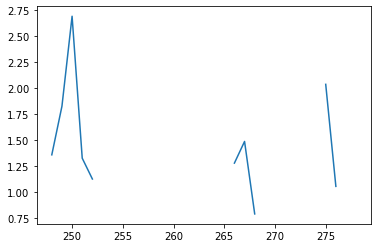

In [40]:
plt.plot(testDay.up_macmicAvg_interp.isel(levInterp=53,nens=0,case=1).values)

## Change in diurnal cycles?

In [13]:
def plots_timeHeight(DS1, DS2, DS3, 
                     DS1raw, DS2raw, DS3raw,
                     varPlot, unitsStr, clims, dlims, topLev=500): 
    
    
    # - - - - - - - - - - - - - - - -  
    ## Paired T-test for significance
    # - - - - - - - - - - - - - - - -  
    pVal_DS1 = np.full([24, len(DS1.levInterp.values)], np.nan)
    pVal_DS2 = np.full([24, len(DS2.levInterp.values)], np.nan)
    pVal_DS3 = np.full([24, len(DS3.levInterp.values)], np.nan)
    for iHr in range(24): 
            t,pDS1 = stats.ttest_rel(DS1raw[varPlot].isel(case=0).where(DS1raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     DS1raw[varPlot].isel(case=1).where(DS1raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     nan_policy = 'omit')
            iValDS1 = np.where(pDS1<0.05)[0]
            pVal_DS1[iHr,iValDS1]=1
            
            t,pDS2 = stats.ttest_rel(DS2raw[varPlot].isel(case=0).where(DS2raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     DS2raw[varPlot].isel(case=1).where(DS2raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     nan_policy = 'omit')
            iValDS2 = np.where(pDS2<0.05)[0]
            pVal_DS2[iHr,iValDS2]=1

            t,pDS3 = stats.ttest_rel(DS3raw[varPlot].isel(case=0).where(DS3raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     DS3raw[varPlot].isel(case=1).where(DS3raw['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                     nan_policy = 'omit')
            iValDS3 = np.where(pDS3<0.05)[0]
            pVal_DS3[iHr,iValDS3]=1
            
    
    fig,axs = plt.subplots(3,3, figsize=(18,18))
    axs     = axs.ravel()

    axs[0].contourf(DS1.hour.values, DS1.levInterp.values, DS1[varPlot].isel(case=0).transpose().values, clims, cmap = 'jet', extend='both')
    axs[1].contourf(DS1.hour.values, DS1.levInterp.values, DS1[varPlot].isel(case=1).transpose().values, clims, cmap = 'jet', extend='both')
    axs[2].contourf(DS1.hour.values, DS1.levInterp.values, 
                    DS1[varPlot].isel(case=1).transpose().values - DS1[varPlot].isel(case=0).transpose().values, 
                    dlims, cmap = 'seismic', extend='both')
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(DS1.levInterp.values)):
            if pVal_DS1[iHr,iLev]==1:
                axs[2].plot(DS1.hour.values[iHr], DS1.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')



    axs[3].contourf(DS2.hour.values, DS2.levInterp.values, DS2[varPlot].isel(case=0).transpose().values, clims, cmap = 'jet', extend='both')
    axs[4].contourf(DS2.hour.values, DS2.levInterp.values, DS2[varPlot].isel(case=1).transpose().values, clims, cmap = 'jet', extend='both')
    axs[5].contourf(DS2.hour.values, DS2.levInterp.values, 
                    DS2[varPlot].isel(case=1).transpose().values-DS2[varPlot].isel(case=0).transpose().values, 
                    dlims, cmap = 'seismic', extend='both')
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(DS1.levInterp.values)):
            if pVal_DS2[iHr,iLev]==1:
                axs[5].plot(DS2.hour.values[iHr], DS2.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')



    axs[6].contourf(DS3.hour.values, DS3.levInterp.values, DS3[varPlot].isel(case=0).transpose().values, clims, cmap = 'jet', extend='both')
    cplt=axs[7].contourf(DS3.hour.values, DS3.levInterp.values, DS3[varPlot].isel(case=1).transpose().values, clims, cmap = 'jet', extend='both')
    #Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.08, 0.015])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

    cplt=axs[8].contourf(DS3.hour.values, DS3.levInterp.values, 
                         DS3[varPlot].isel(case=1).transpose().values-DS3[varPlot].isel(case=0).transpose().values, 
                         dlims, cmap = 'seismic', extend='both')
    #Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(DS1.levInterp.values)):
            if pVal_DS3[iHr,iLev]==1:
                axs[8].plot(DS3.hour.values[iHr], DS3.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


    axs[0].set_title(str(varPlot)+'\n'+str(DS1[varPlot].isel(case=0).case.values))
    axs[1].set_title(DS1[varPlot].isel(case=1).case.values)
    axs[2].set_title('HET-HOM')

    axs[3].set_title(str(DS2[varPlot].isel(case=0).case.values)+' [AddHETterm]')
    axs[4].set_title(str(DS2[varPlot].isel(case=1).case.values)+' [AddHETterm]')
    axs[5].set_title('HET-HOM')

    axs[6].set_title(str(DS3[varPlot].isel(case=0).case.values)+' [AddHETterm]')
    axs[7].set_title(str(DS3[varPlot].isel(case=1).case.values)+' [AddHETterm]')
    axs[8].set_title('HET-HOM')

    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([980, topLev])
    axs[1].set_ylim([980, topLev])
    axs[2].set_ylim([980, topLev])
    axs[3].set_ylim([980, topLev])
    axs[4].set_ylim([980, topLev])
    axs[5].set_ylim([980, topLev])
    axs[6].set_ylim([980, topLev])
    axs[7].set_ylim([980, topLev])
    axs[8].set_ylim([980, topLev])

    
    return axs

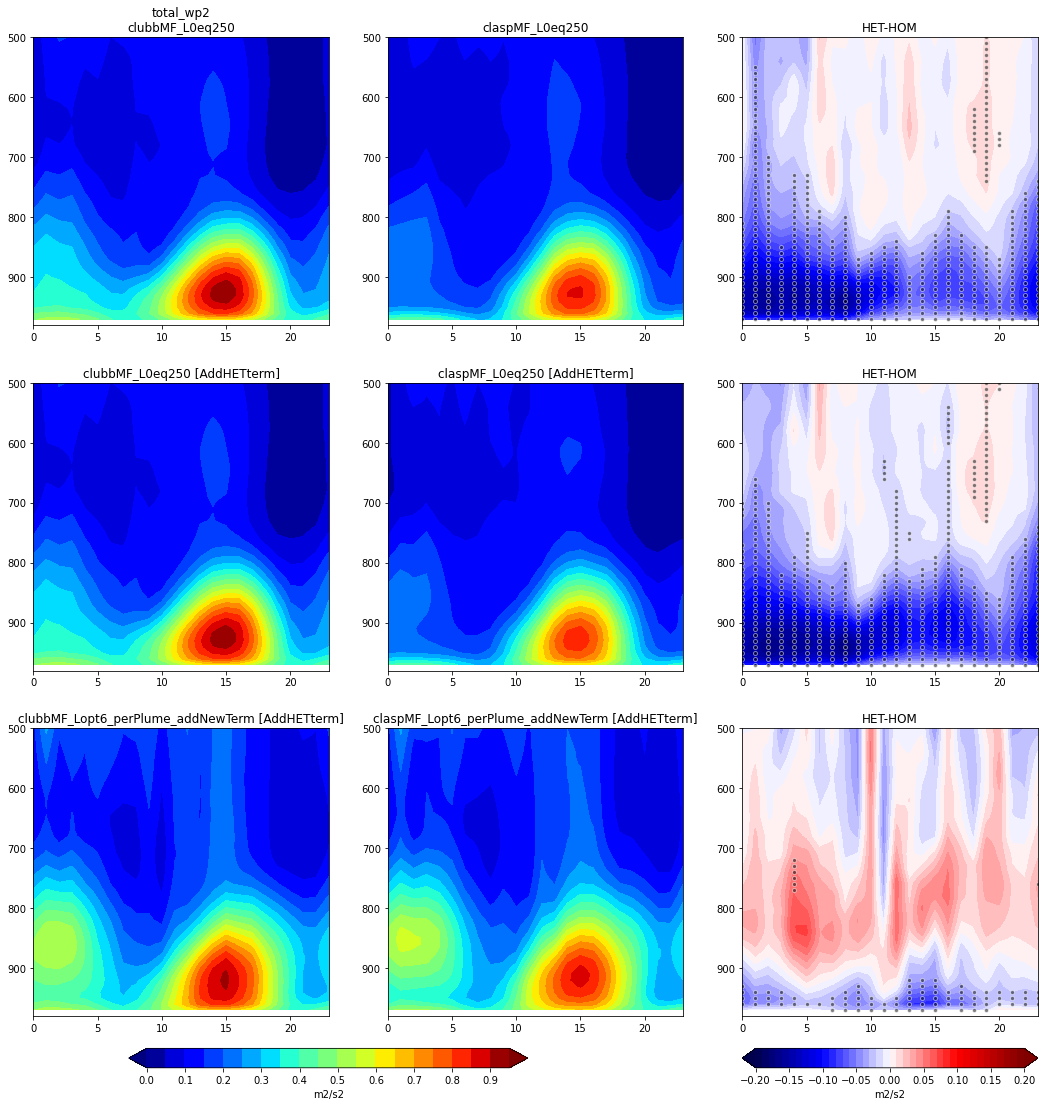

In [18]:
varPlot = 'total_wp2'
unitsStr = 'm2/s2'

topLev = 500

clims = np.arange(0,1,0.05)
dlims = np.arange(-0.2, 0.21, 0.01)

axs = plots_timeHeight(diurnal_h2, diurnal_h2_addTerm, diurnal_h2_Lopt6pp, 
                       scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)


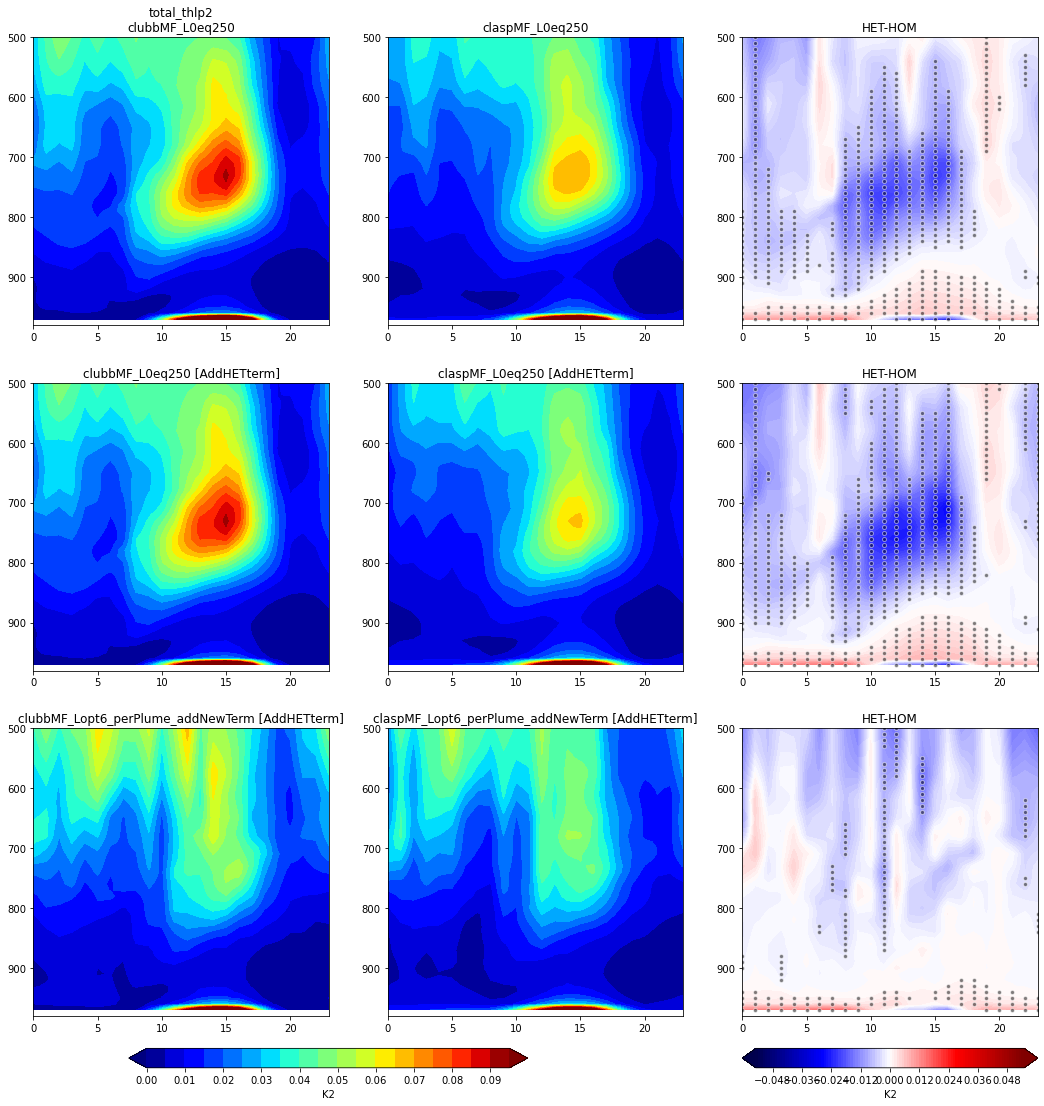

In [19]:
varPlot = 'total_thlp2'
unitsStr = 'K2'

topLev = 500

clims = np.arange(0,0.1,0.005)
dlims = np.arange(-0.055, 0.056, 0.001)

axs = plots_timeHeight(diurnal_h2, diurnal_h2_addTerm, diurnal_h2_Lopt6pp, 
                       scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)



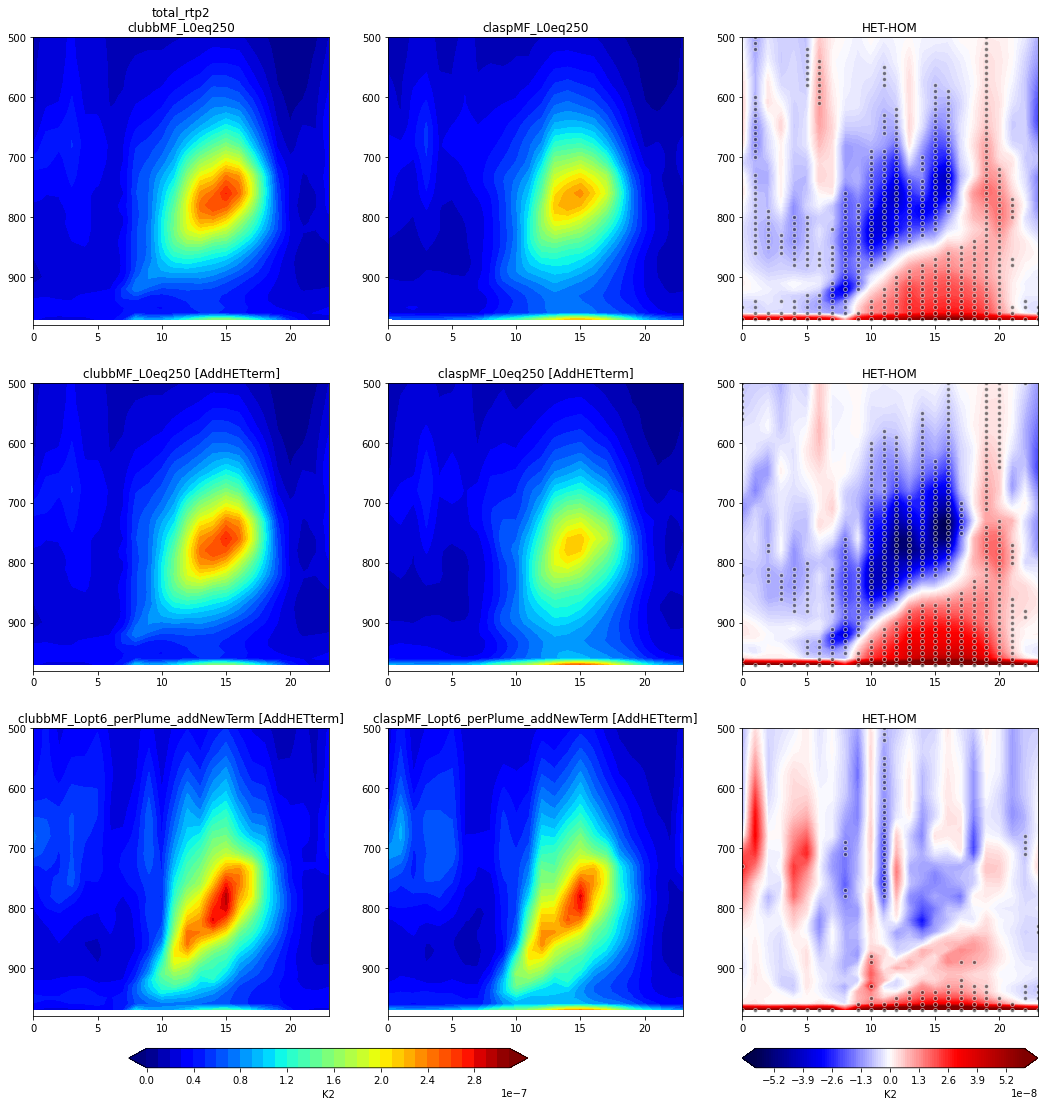

In [20]:
varPlot = 'total_rtp2'
unitsStr = 'K2'

topLev = 500

clims = np.arange(0,3.2e-7,1e-8)
dlims = np.arange(-6e-8, 6.1e-8, 0.1e-8)

axs = plots_timeHeight(diurnal_h2, diurnal_h2_addTerm, diurnal_h2_Lopt6pp, 
                       scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)


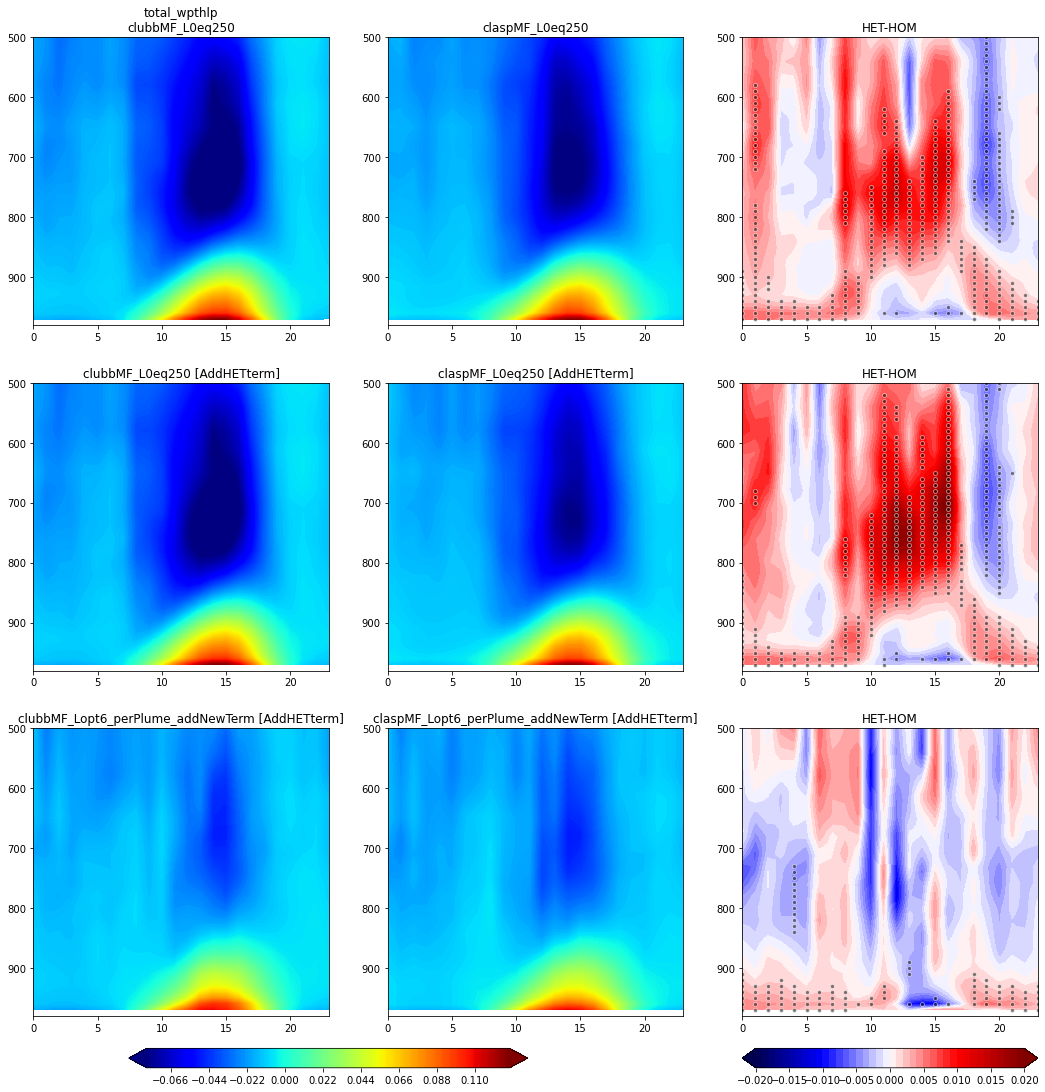

In [21]:
varPlot = 'total_wpthlp'
unitsStr = ''

topLev = 500

clims = np.arange(-0.08,0.13,0.001)
dlims = np.arange(-2e-2, 2.1e-2, 0.1e-2)

axs = plots_timeHeight(diurnal_h2, diurnal_h2_addTerm, diurnal_h2_Lopt6pp, 
                       scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)


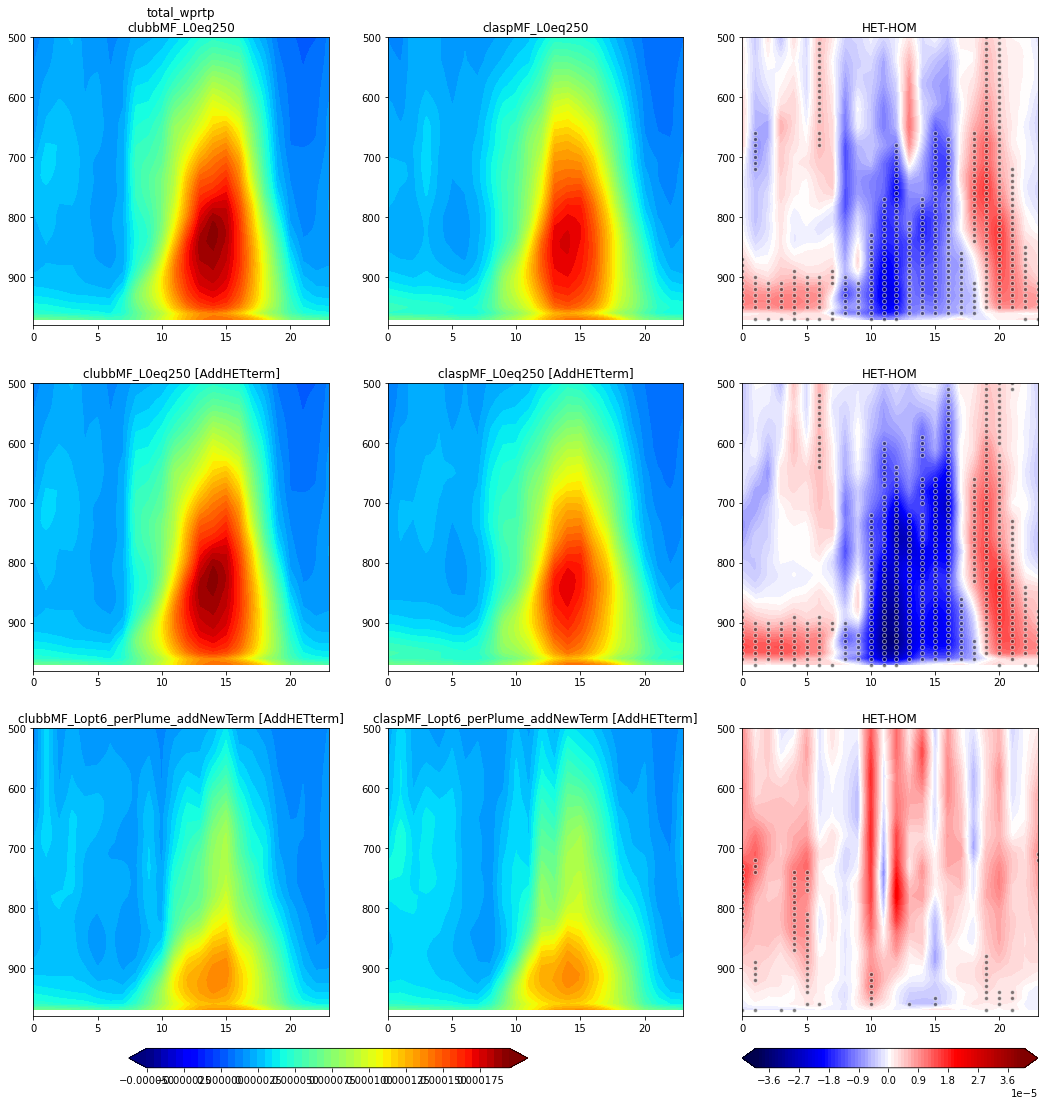

In [22]:
varPlot = 'total_wprtp'
unitsStr = ''

topLev = 500

clims = np.arange(-0.5e-4,2e-4,0.05e-4)
dlims = np.arange(-4e-5, 4.1e-5, 0.1e-5)

axs = plots_timeHeight(diurnal_h2, diurnal_h2_addTerm, diurnal_h2_Lopt6pp, 
                       scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)



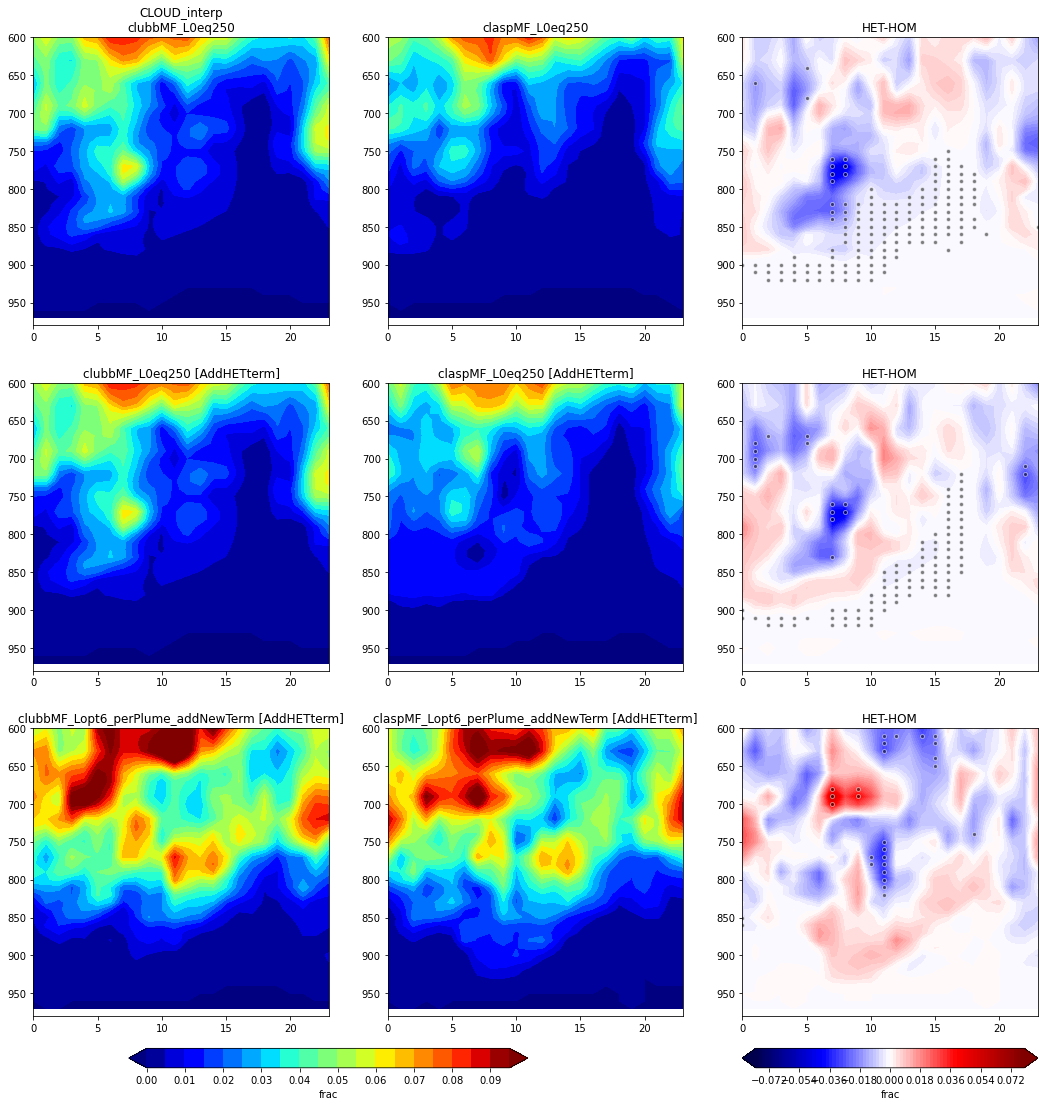

In [23]:
varPlot = 'CLOUD_interp'
unitsStr = 'frac'

topLev = 600

clims = np.arange(0,0.1,0.005)
dlims = np.arange(-0.08, 0.082, 0.002)


axs = plots_timeHeight(diurnal_h0, diurnal_h0_addTerm, diurnal_h0_Lopt6pp, 
                       scamDS, scamDS_addTerm, scamDS_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)



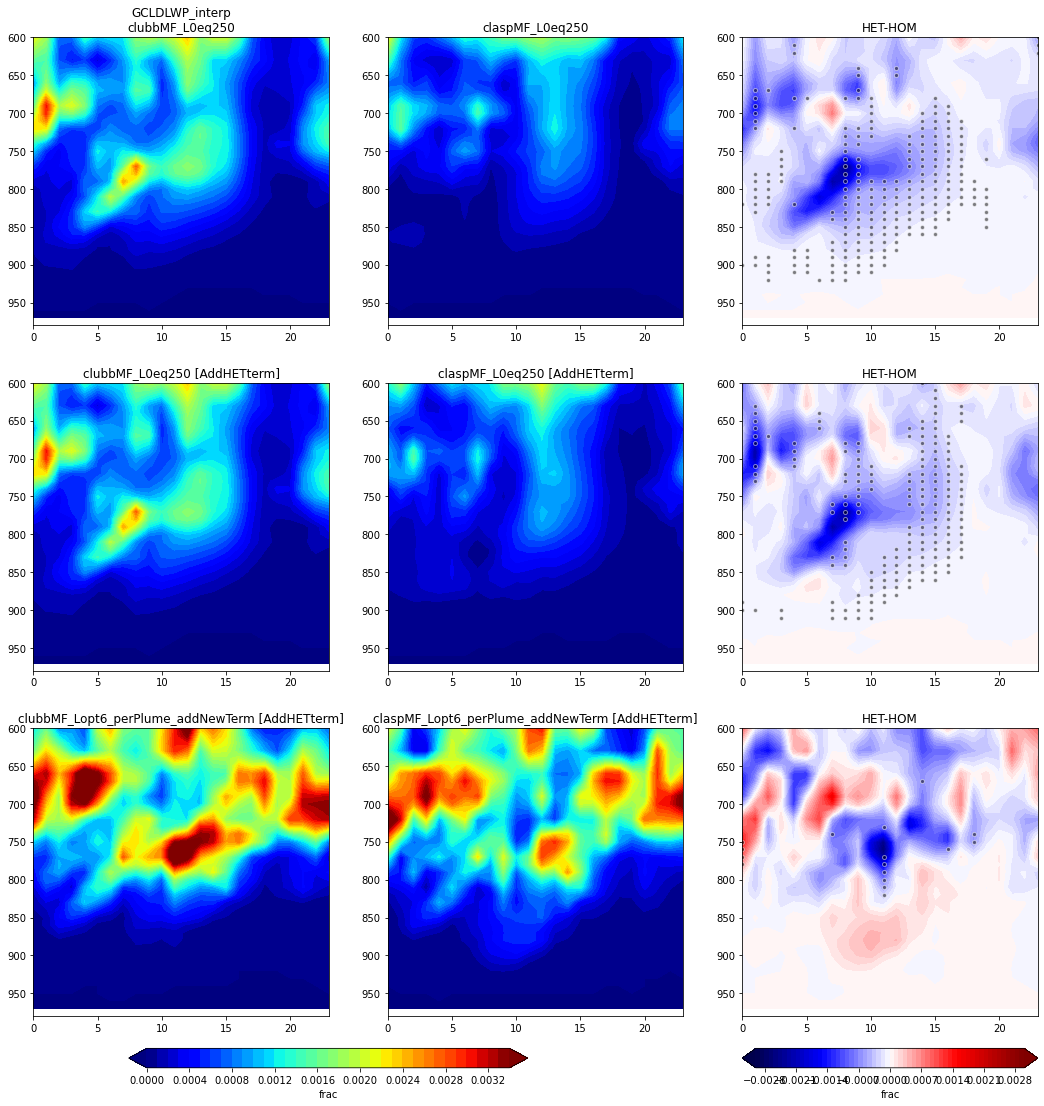

In [24]:
varPlot = 'GCLDLWP_interp'
unitsStr = 'frac'

topLev = 600

clims = np.arange(0,3.5e-3,1e-4)
dlims = np.arange(-3e-3, 3.1e-3, 0.1e-3)


axs = plots_timeHeight(diurnal_h0, diurnal_h0_addTerm, diurnal_h0_Lopt6pp, 
                       scamDS, scamDS_addTerm, scamDS_Lopt6pp,
                      varPlot, unitsStr, clims, dlims, topLev)



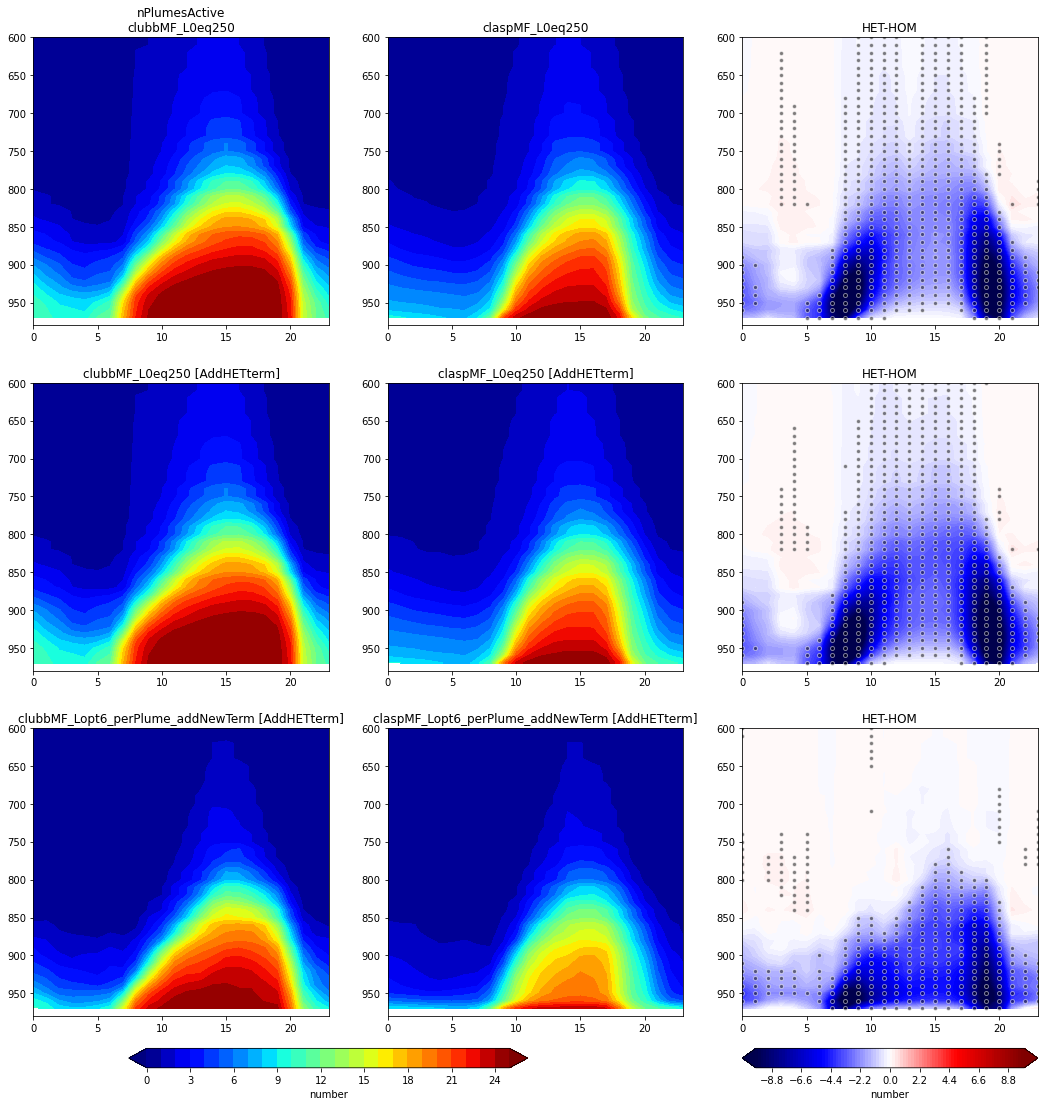

In [25]:
varPlot = 'nPlumesActive'
unitsStr = 'number'

topLev = 600

clims = np.arange(0,26,1)
dlims = np.arange(-10, 10.2, 0.2)


axs = plots_timeHeight(diurnal_h0, diurnal_h0_addTerm, diurnal_h0_Lopt6pp, 
                       scamDS, scamDS_addTerm, scamDS_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)



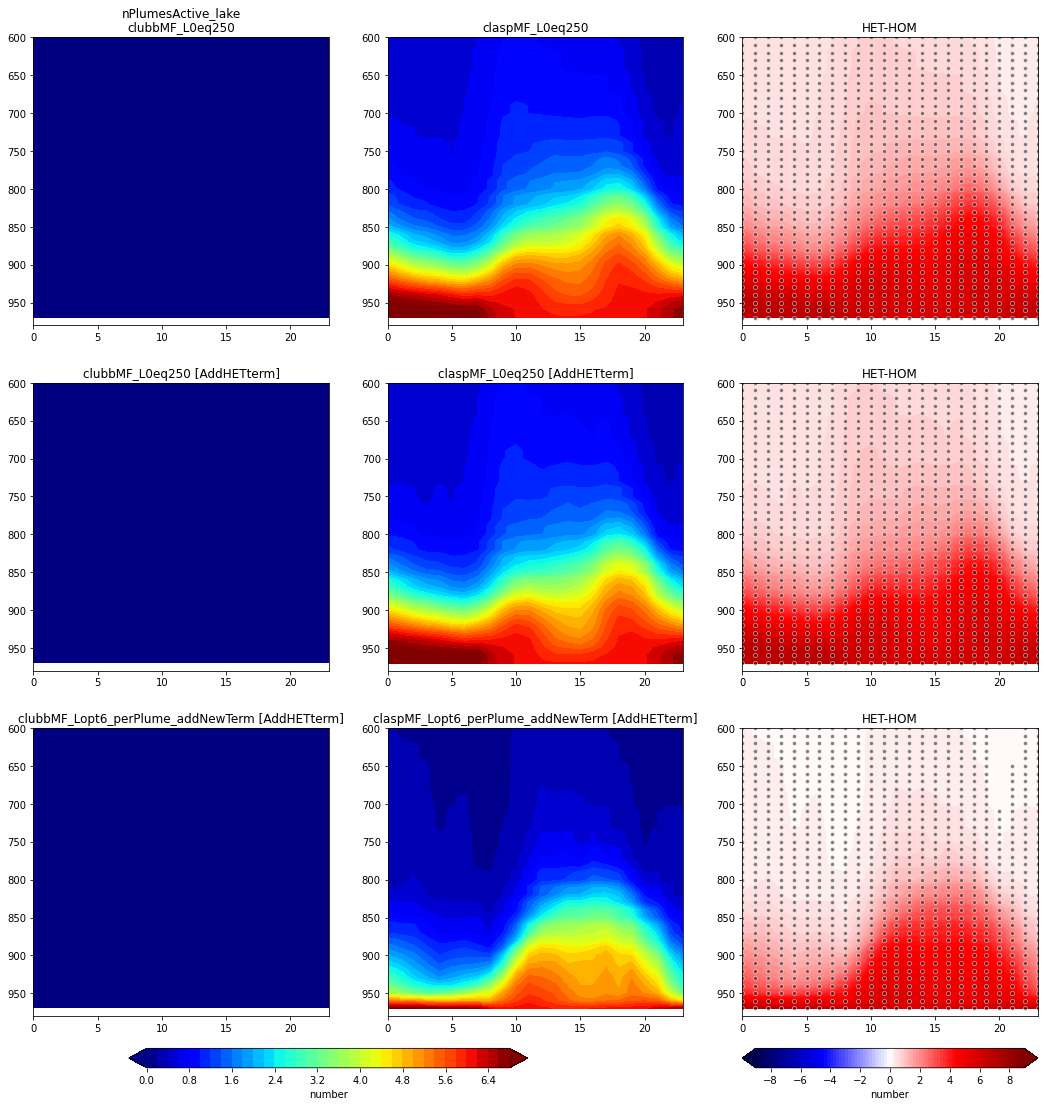

In [20]:
varPlot = 'nPlumesActive_lake'
unitsStr = 'number'

topLev = 600

clims = np.arange(0,7,0.2)
dlims = np.arange(-9, 9.2, 0.2)


axs = plots_timeHeight(diurnal_h0, diurnal_h0_addTerm, diurnal_h0_Lopt6pp, 
                       scamDS, scamDS_addTerm, scamDS_Lopt6pp,
                       varPlot, unitsStr, clims, dlims, topLev)



In [11]:
def plots_timeHeight_weightMFplumes(DS1, DS2, DS3, 
                     varPlot, unitsStr, clims, dlims, topLev=500): 
    
    ## Get the weights 
    HOMwgts_DS1 = DS1.upa_macmicAvg_interp.isel(case=0).resample(time='1H').mean().fillna(0)
    HETwgts_DS1 = DS1.upa_macmicAvg_interp.isel(case=1).resample(time='1H').mean().fillna(0)
    homMean_DS1 = DS1[varPlot].where(DS1.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS1).mean(dim='nens').groupby('time.hour').mean(dim='time')
    hetMean_DS1 = DS1[varPlot].where(DS1.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS1).mean(dim='nens').groupby('time.hour').mean(dim='time')
    diff_DS1    = (DS1[varPlot].where(DS1.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS1).mean(dim='nens') - DS1[varPlot].where(DS1.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS1).mean(dim='nens')).groupby('time.hour').mean(dim='time')

    HOMwgts_DS2 = DS2.upa_macmicAvg_interp.isel(case=0).resample(time='1H').mean().fillna(0)
    HETwgts_DS2 = DS2.upa_macmicAvg_interp.isel(case=1).resample(time='1H').mean().fillna(0)
    homMean_DS2 = DS2[varPlot].where(DS2.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS2).mean(dim='nens').groupby('time.hour').mean(dim='time')
    hetMean_DS2 = DS2[varPlot].where(DS2.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS2).mean(dim='nens').groupby('time.hour').mean(dim='time')
    diff_DS2    = (DS2[varPlot].where(DS2.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS2).mean(dim='nens') - DS2[varPlot].where(DS2.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS2).mean(dim='nens')).groupby('time.hour').mean(dim='time')
    
    HOMwgts_DS3 = DS3.upa_macmicAvg_interp.isel(case=0).resample(time='1H').mean().fillna(0)
    HETwgts_DS3 = DS3.upa_macmicAvg_interp.isel(case=1).resample(time='1H').mean().fillna(0)
    homMean_DS3 = DS3[varPlot].where(DS3.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS3).mean(dim='nens').groupby('time.hour').mean(dim='time')
    hetMean_DS3 = DS3[varPlot].where(DS3.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS3).mean(dim='nens').groupby('time.hour').mean(dim='time')
    diff_DS3    = (DS3[varPlot].where(DS3.levInterp.values>=topLev).isel(case=1).resample(time='1H').mean().weighted(HETwgts_DS3).mean(dim='nens') - DS3[varPlot].where(DS3.levInterp.values>=topLev).isel(case=0).resample(time='1H').mean().weighted(HOMwgts_DS3).mean(dim='nens')).groupby('time.hour').mean(dim='time')

    
        
    # - - - - - - - - - - - - - - - -  
    ## Paired T-test for significance
    # - - - - - - - - - - - - - - - -  
    pVal_DS1 = np.full([24, len(DS1.levInterp.values)], np.nan)
    pVal_DS2 = np.full([24, len(DS2.levInterp.values)], np.nan)
    pVal_DS3 = np.full([24, len(DS3.levInterp.values)], np.nan)
    for iHr in range(24): 
        HOMwgtsDS1 = DS1.upa_macmicAvg_interp.isel(case=0).where(DS1['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsDS1 = DS1.upa_macmicAvg_interp.isel(case=1).where(DS1['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        t,pDS1 = stats.ttest_rel(
                                DS1[varPlot].isel(case=0).where(DS1['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS1).mean(dim='nens'),
                                DS1[varPlot].isel(case=1).where(DS1['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS1).mean(dim='nens'),
                                nan_policy = 'omit')
        iValDS1 = np.where(pDS1<0.05)[0]
        pVal_DS1[iHr,iValDS1]=1
        
        HOMwgtsDS2 = DS2.upa_macmicAvg_interp.isel(case=0).where(DS2['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsDS2 = DS2.upa_macmicAvg_interp.isel(case=1).where(DS2['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        t,pDS2 = stats.ttest_rel(
                                DS2[varPlot].isel(case=0).where(DS2['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS2).mean(dim='nens'),
                                DS2[varPlot].isel(case=1).where(DS2['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS2).mean(dim='nens'),
                                nan_policy = 'omit')
        iValDS2 = np.where(pDS2<0.05)[0]
        pVal_DS2[iHr,iValDS2]=1
        
        HOMwgtsDS3 = DS3.upa_macmicAvg_interp.isel(case=0).where(DS3['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsDS3 = DS3.upa_macmicAvg_interp.isel(case=1).where(DS3['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        t,pDS3 = stats.ttest_rel(
                                DS3[varPlot].isel(case=0).where(DS3['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS2).mean(dim='nens'),
                                DS3[varPlot].isel(case=1).where(DS3['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS2).mean(dim='nens'),
                                nan_policy = 'omit')
        iValDS3 = np.where(pDS3<0.05)[0]
        pVal_DS3[iHr,iValDS3]=1
            
        
    fig,axs = plt.subplots(3,3, figsize=(18,18))
    axs     = axs.ravel()

    axs[0].contourf(homMean_DS1.hour.values, homMean_DS1.levInterp.values, homMean_DS1.transpose().values, clims, cmap = 'jet', extend='both')
    axs[1].contourf(hetMean_DS1.hour.values, hetMean_DS1.levInterp.values, hetMean_DS1.transpose().values, clims, cmap = 'jet', extend='both')
    axs[2].contourf(diff_DS1.hour.values, diff_DS1.levInterp.values, 
                    diff_DS1.transpose().values, 
                    dlims, cmap = 'seismic', extend='both')
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(diff_DS1.levInterp.values)):
            if pVal_DS1[iHr,iLev]==1:
                axs[2].plot(diff_DS1.hour.values[iHr], diff_DS1.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')



    axs[3].contourf(homMean_DS2.hour.values, homMean_DS2.levInterp.values, homMean_DS2.transpose().values, clims, cmap = 'jet', extend='both')
    axs[4].contourf(hetMean_DS2.hour.values, hetMean_DS2.levInterp.values, hetMean_DS2.transpose().values, clims, cmap = 'jet', extend='both')
    axs[5].contourf(diff_DS2.hour.values, diff_DS2.levInterp.values, 
                    diff_DS2.transpose().values, 
                    dlims, cmap = 'seismic', extend='both')
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(diff_DS2.levInterp.values)):
            if pVal_DS2[iHr,iLev]==1:
                axs[5].plot(diff_DS2.hour.values[iHr], diff_DS2.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


    axs[6].contourf(homMean_DS3.hour.values, homMean_DS3.levInterp.values, homMean_DS3.transpose().values, clims, cmap = 'jet', extend='both')
    cplt=axs[7].contourf(hetMean_DS3.hour.values, hetMean_DS3.levInterp.values, hetMean_DS3.transpose().values, clims, cmap = 'jet', extend='both')
    #Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.08, 0.015])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

    cplt=axs[8].contourf(diff_DS3.hour.values, diff_DS3.levInterp.values, 
                         diff_DS3.transpose().values, 
                         dlims, cmap = 'seismic', extend='both')
    #Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.04, ax_position.width, 0.015])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
    ## Add significance test?
    for iHr in range(24): 
        for iLev in range(len(diff_DS3.levInterp.values)):
            if pVal_DS3[iHr,iLev]==1:
                axs[8].plot(diff_DS3.hour.values[iHr], diff_DS3.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')



    axs[0].set_title(str(varPlot)+'\n'+str(DS1[varPlot].isel(case=0).case.values))
    axs[1].set_title(DS1[varPlot].isel(case=1).case.values)
    axs[2].set_title('HET-HOM')

    axs[3].set_title(str(DS2[varPlot].isel(case=0).case.values)+' [AddHETterm]')
    axs[4].set_title(str(DS2[varPlot].isel(case=1).case.values)+' [AddHETterm]')
    axs[5].set_title('HET-HOM')

    axs[6].set_title(str(DS3[varPlot].isel(case=0).case.values)+' [AddHETterm]')
    axs[7].set_title(str(DS3[varPlot].isel(case=1).case.values)+' [AddHETterm]')
    axs[8].set_title('HET-HOM')

    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([980, topLev])
    axs[1].set_ylim([980, topLev])
    axs[2].set_ylim([980, topLev])
    axs[3].set_ylim([980, topLev])
    axs[4].set_ylim([980, topLev])
    axs[5].set_ylim([980, topLev])
    axs[6].set_ylim([980, topLev])
    axs[7].set_ylim([980, topLev])
    axs[8].set_ylim([980, topLev])

    return axs

(0.0, 26.0)

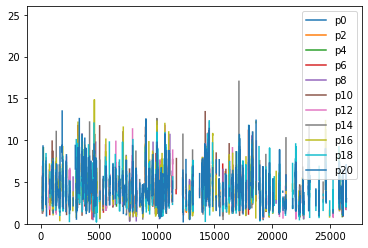

In [18]:
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=0).values, label='p0')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=2).values, label='p2')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=4).values, label='p4')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=6).values, label='p6')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=8).values, label='p8')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=10).values, label='p10')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=12).values, label='p12')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=14).values, label='p14')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=16).values, label='p16')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=18).values, label='p18')
plt.plot(scamDS_h2.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=20).values, label='p20')
plt.legend()
plt.ylim([0,26])

(0.0, 26.0)

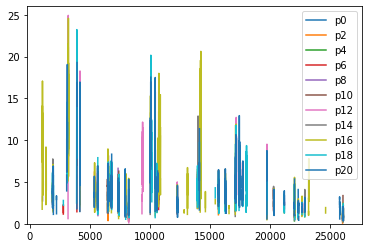

In [20]:
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=0).values, label='p0')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=2).values, label='p2')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=4).values, label='p4')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=6).values, label='p6')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=8).values, label='p8')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=10).values, label='p10')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=12).values, label='p12')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=14).values, label='p14')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=16).values, label='p16')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=18).values, label='p18')
plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=20).values, label='p20')
plt.legend()
plt.ylim([0,26])

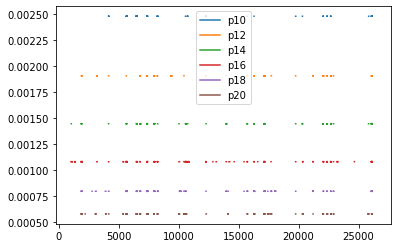

In [13]:
# plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=0).values, label='p0')
# plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=2).values, label='p2')
# plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=4).values, label='p4')
# plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=6).values, label='p6')
# plt.plot(scamDS_h2_Lopt6pp.up_macmicAvg_interp.isel(case=0,levInterp=53,nens=8).values, label='p8')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=10).values, label='p10')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=12).values, label='p12')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=14).values, label='p14')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=16).values, label='p16')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=18).values, label='p18')
plt.plot(scamDS_h2_Lopt6pp.upa_macmicAvg_interp.isel(case=0,levInterp=53,nens=20).values, label='p20')
plt.legend()


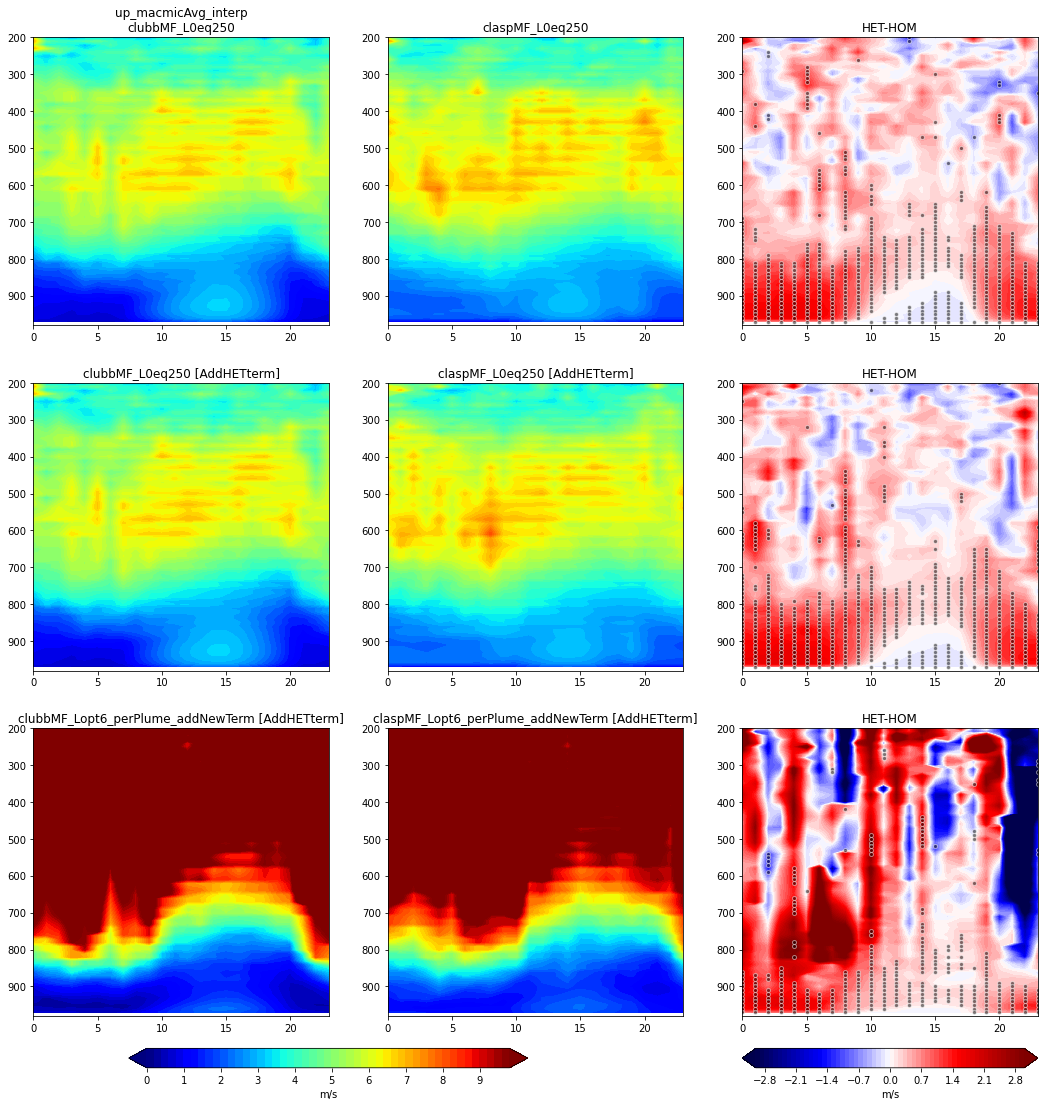

In [14]:
varPlot = 'up_macmicAvg_interp'
unitsStr = 'm/s'

topLev = 200

clims = np.arange(0, 10, 0.2)
dlims = np.arange(-3, 3.1, 0.1)

axs = plots_timeHeight_weightMFplumes(scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp, 
                                      varPlot, unitsStr, clims, dlims, topLev)


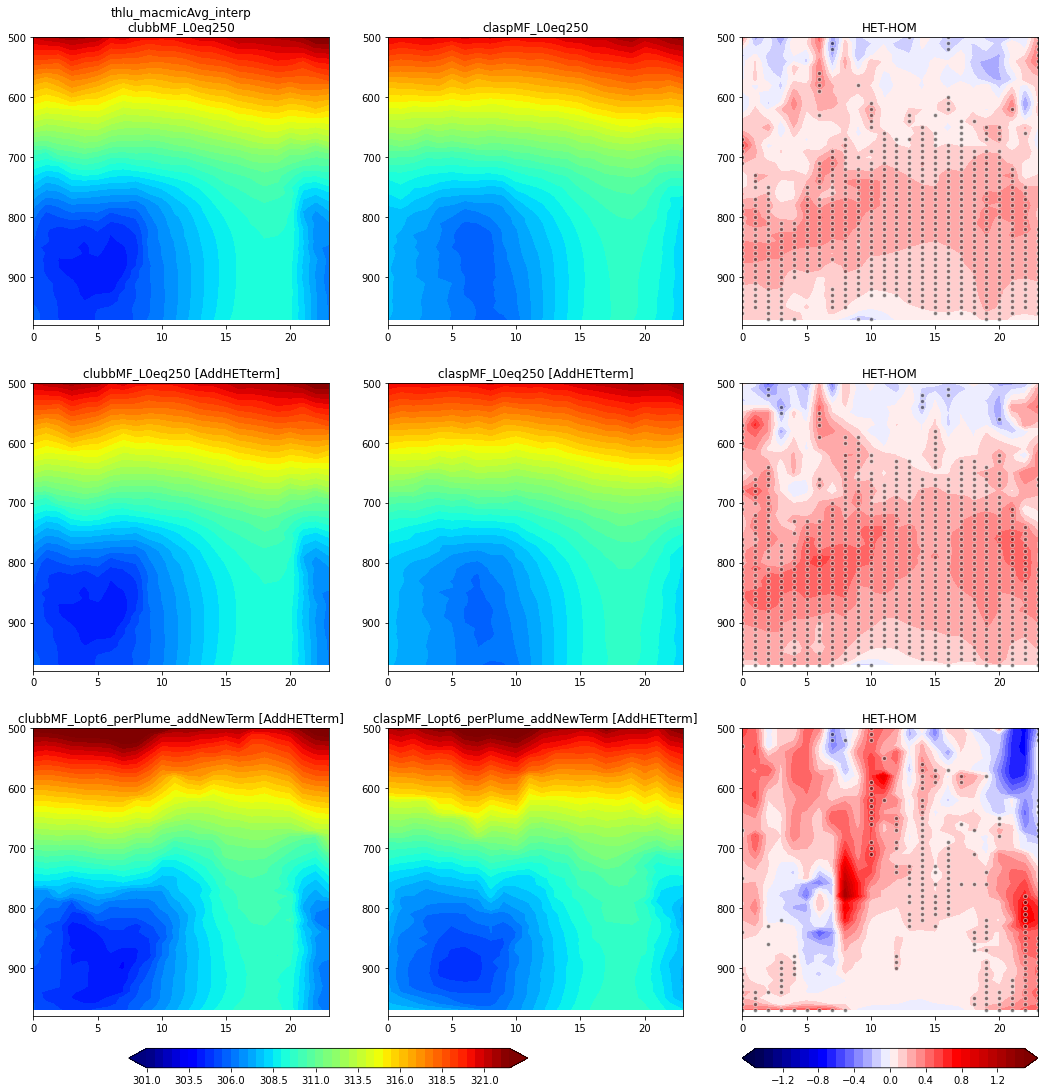

In [60]:
varPlot = 'thlu_macmicAvg_interp'
unitsStr = ''

topLev = 500

clims = np.arange(301, 323, 0.5)
dlims = np.arange(-1.5, 1.6, 0.1)

axs = plots_timeHeight_weightMFplumes(scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp, 
                                      varPlot, unitsStr, clims, dlims, topLev)


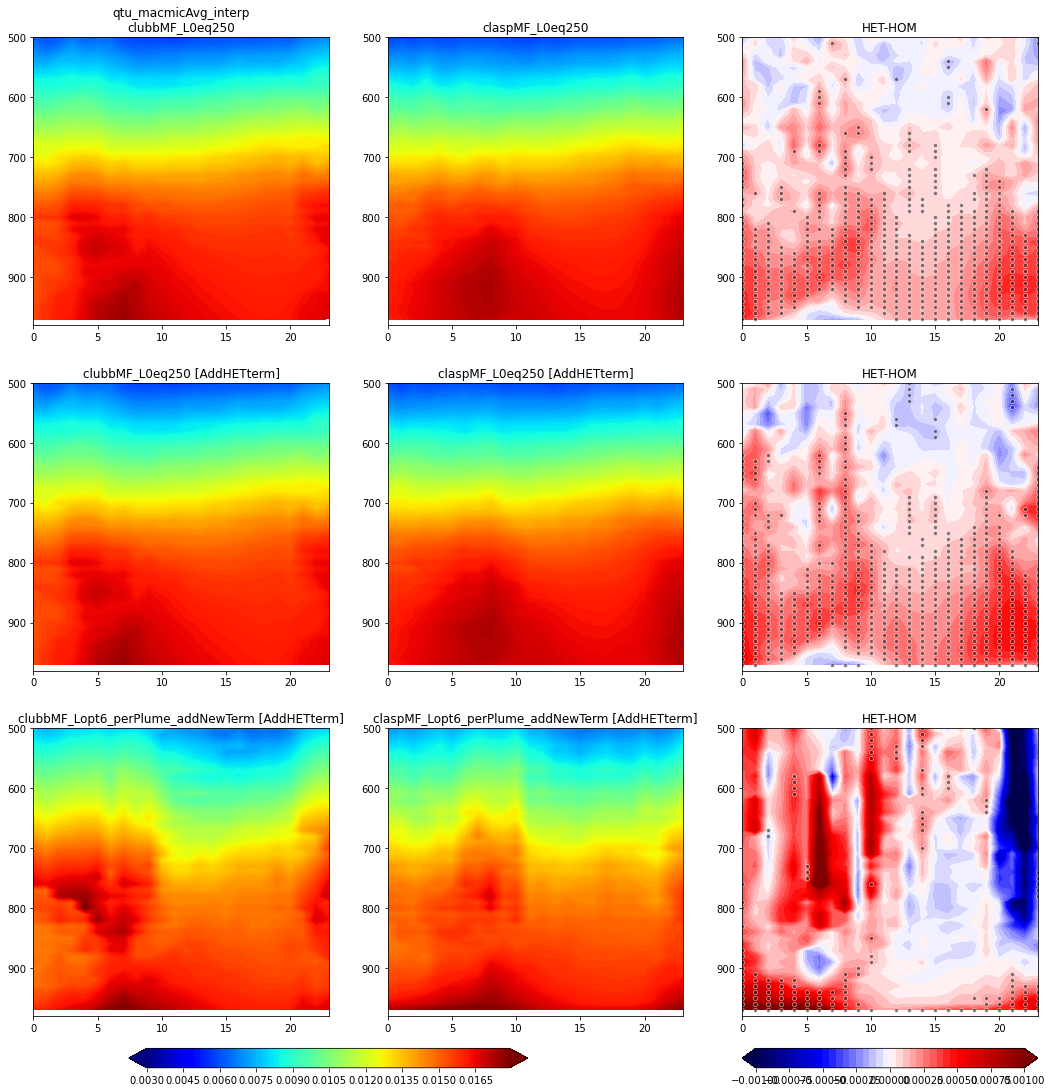

In [61]:
varPlot  = 'qtu_macmicAvg_interp'
unitsStr = ''

topLev = 500

clims = np.arange(0.003, 1.8e-2, 1e-4)
dlims = np.arange(-1e-3, 1.05e-3, 0.05e-3)

axs = plots_timeHeight_weightMFplumes(scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp, 
                                      varPlot, unitsStr, clims, dlims, topLev)


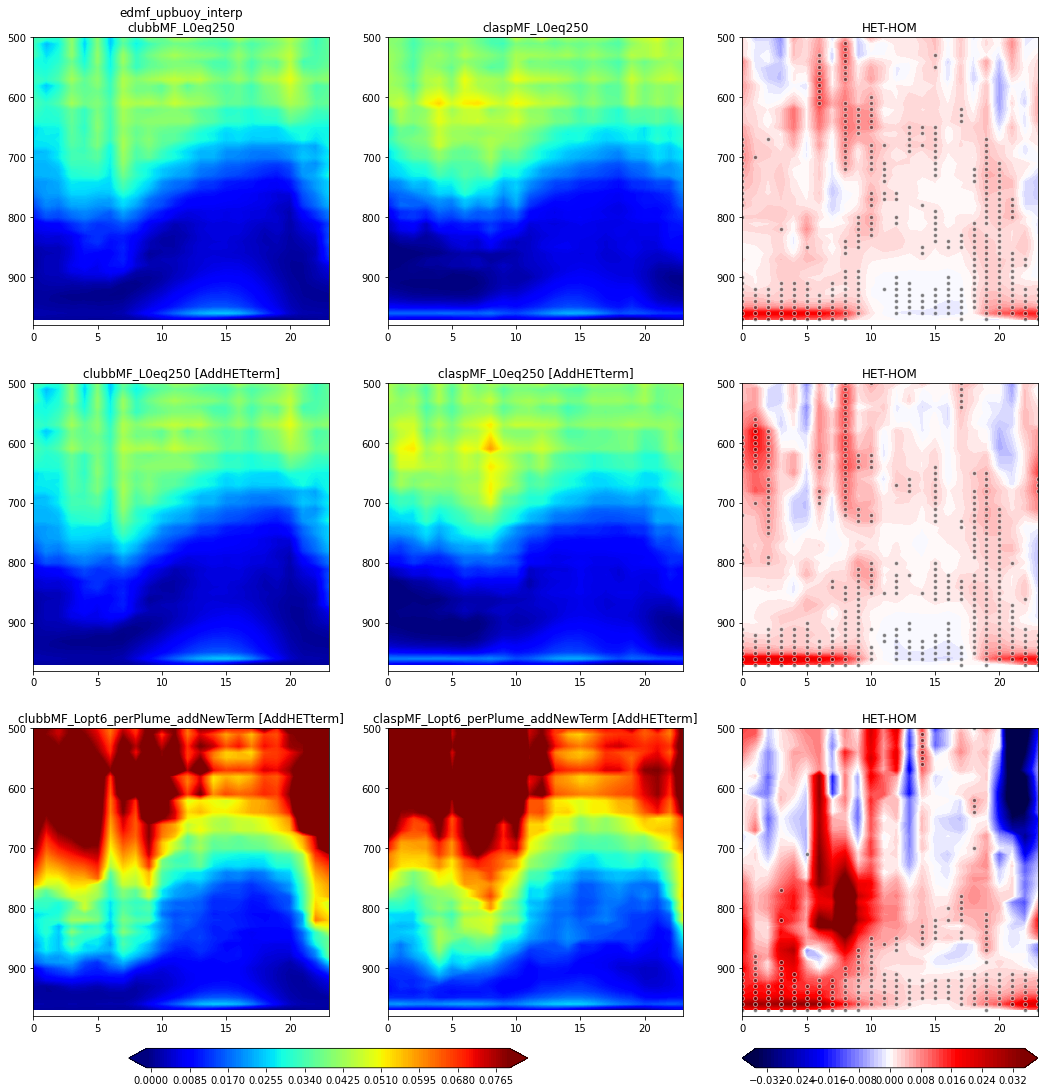

In [29]:
varPlot  = 'edmf_upbuoy_interp'
unitsStr = ''

topLev = 500

clims = np.arange(-0.001, 0.08, 0.0005)
dlims = np.arange(-0.035, .0351, 0.001)

axs = plots_timeHeight_weightMFplumes(scamDS_h2, scamDS_h2_addTerm, scamDS_h2_Lopt6pp, 
                                      varPlot, unitsStr, clims, dlims, topLev)


In [22]:
scamDS_h2_Lopt6pp

<xarray.Dataset>
Dimensions:                (case: 2, ilev: 59, lev: 58, levInterp: 78, nens: 25, time: 26496)
Coordinates:
    lat                    float64 36.6
    lon                    float64 262.5
  * lev                    (lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * ilev                   (ilev) float64 2.055 3.98 6.909 ... 987.4 995.1 1e+03
  * time                   (time) datetime64[ns] 2015-06-02T00:03:30 ... 2015...
  * nens                   (nens) int64 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * levInterp              (levInterp) float64 200.0 210.0 220.0 ... 960.0 970.0
    ncyc                   int64 0
  * case                   (case) object 'clubbMF_Lopt6_perPlume_addNewTerm' ...
Data variables:
    edmf_upa               (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_upw               (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_upqt              (case, time, nens, ilev) float32 nan nan ... 0.01388
    edmf_upthl             (case, time, nens, ilev) float32 nan nan ... 308.6
    edmf_cloudfrac         (case, time, lev, nens, ilev) float32 0.0 0.0 ... 0.0
    edmf_dnw               (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_precc             (case, time, ilev, nens) float32 0.0 0.0 ... 0.0 0.0
    edmf_uplh              (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_ent               (case, time, lev, nens, ilev) float32 nan ... -0.0...
    edmf_upent             (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_updet             (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_upbuoy            (case, time, nens, ilev) float32 nan nan ... nan 0.0
    edmf_qtflxup           (case, time, ilev) float32 0.0 0.0 ... 1.761e-05 0.0
    edmf_thlflxup          (case, time, ilev) float32 0.0 0.0 ... 0.003381 0.0
    edmf_S_ATHLTHL         (case, time, ilev) float32 0.0 0.0 ... 0.0006476
    edmf_S_AQTQT           (case, time, ilev) float32 0.0 0.0 ... 1.403e-08
    edmf_S_AWW             (case, time, ilev) float32 0.0 0.0 ... 0.029 0.03461
    edmf_L0                (case, time) float32 21.39 20.29 ... 75.41 75.41
    edmf_upa_interp        (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_upw_interp        (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_upqt_interp       (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_upthl_interp      (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_qtflxup_interp    (case, time, levInterp) float64 0.0 0.0 ... 6.034e-06
    edmf_thlflxup_interp   (case, time, levInterp) float64 0.0 0.0 ... 0.001159
    edmf_S_ATHLTHL_interp  (case, time, levInterp) float64 0.0 0.0 ... 0.0005622
    edmf_S_AQTQT_interp    (case, time, levInterp) float64 0.0 0.0 ... 1.29e-08
    edmf_S_AWW_interp      (case, time, levInterp) float64 0.0 0.0 ... 0.03269
    edmf_upent_interp      (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_updet_interp      (case, time, nens, levInterp) float64 nan nan ... nan
    edmf_upbuoy_interp     (case, time, nens, levInterp) float64 nan nan ... nan
    up_macmicAvg_interp    (case, time, nens, levInterp) float64 nan nan ... nan
    upa_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    thlu_macmicAvg_interp  (case, time, nens, levInterp) float64 nan nan ... nan
    qtu_macmicAvg_interp   (case, time, nens, levInterp) float64 nan nan ... nan
    plumeLabel             (case, time, nens) object 'SurfaceAvg' ... 'Surfac...
    total_wp2              (case, time, levInterp) float64 0.0004 ... 1.05
    total_thlp2            (case, time, levInterp) float64 0.0001255 ... 0.00...
    total_rtp2             (case, time, levInterp) float64 7.782e-16 ... 1.57...
    total_wpthlp           (case, time, levInterp) float64 -1.618e-05 ... -0....
    total_wprtp            (case, time, levInterp) float64 9.136e-11 ... 4.39...

In [ ]:
# diurnal_h2_Lopt6pp = scamDS_h2_Lopt6pp.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# diurnal_h2_addTerm = scamDS_h2_addTerm.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# diurnal_h2         = scamDS_h2.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


### Diurnal cycle

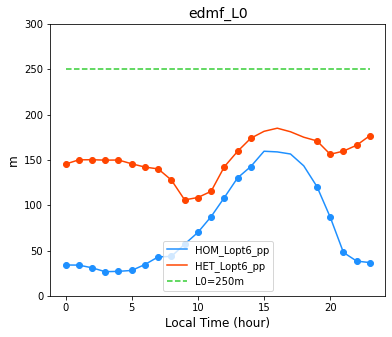

In [39]:
# - - - - - - - - - - - - - - - - - - - - - -
#  Plot mean diurnal cycle with error bars
# - - - - - - - - - - - - - - - - - - - - - - 

scamDS['edmf_L0']         = scamDS_h2['edmf_L0']
scamDS_addTerm['edmf_L0'] = scamDS_h2_addTerm['edmf_L0']
scamDS_Lopt6pp['edmf_L0'] = scamDS_h2_Lopt6pp['edmf_L0']

varPlot = 'edmf_L0'
yMax    = 300
yMin    = 0
unitsString = scamDS[varPlot].units
# unitsString = 'mm/hr'
setYlims = True 

# valueMultiplier = (3600*1e3)
valueMultiplier =  1
CIlevel = 1.960   ## 95% CI 

# - - - - - - - - - - - - - - - - - 
fig,axs = plt.subplots(1,1, figsize=(6,5))

DS_mean  = (valueMultiplier*scamDS_Lopt6pp[varPlot]).groupby('time.hour').mean(dim='time')
DS_std   = (valueMultiplier*scamDS_Lopt6pp[varPlot]).groupby('time.hour').std(dim='time')
DS_count = (valueMultiplier*scamDS_Lopt6pp[varPlot]).groupby('time.hour').count(dim='time')
DS_SE    = DS_std/np.sqrt(DS_count)

## Paired T-test for significance
pVal_Lopt = np.full([24], np.nan)
for iHr in range(24):         
    t,pLopt = stats.ttest_rel(scamDS_Lopt6pp[varPlot].isel(case=0).where(scamDS_Lopt6pp['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              scamDS_Lopt6pp[varPlot].isel(case=1).where(scamDS_Lopt6pp['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              nan_policy = 'omit')
    if pLopt<0.05: 
        pVal_Lopt[iHr]=1
            
# - - - - - - - - - - - - - - - - - 

axs.plot(DS_mean.hour.values, DS_mean.isel(case=0).values, color='dodgerblue', label='HOM_Lopt6_pp') 
axs.plot(DS_mean.hour.values, DS_mean.isel(case=1).values, color='orangered', label='HET_Lopt6_pp') 
axs.plot(DS_mean.hour.values, 250*np.ones(len(DS_mean.hour.values)),'--', color='limegreen', label='L0=250m') 
axs.legend()

axs.plot(DS_mean.hour.values, DS_mean.isel(case=0).values*pVal_Lopt, 'o', color='dodgerblue')
axs.plot(DS_mean.hour.values, DS_mean.isel(case=1).values*pVal_Lopt, 'o', color='orangered')

axs.set_title(varPlot,fontsize=14)
axs.set_ylabel(unitsString, fontsize=12)
axs.set_xlabel('Local Time (hour)', fontsize=12)

if setYlims==True: 
    axs.set_ylim([yMin, yMax])


In [55]:
def getMeansAndSig(valMult, DS, varPlot): 
    DS_mean  = (valMult*DS[varPlot]).groupby('time.hour').mean(dim='time')
    DS_std   = (valMult*DS[varPlot]).groupby('time.hour').std(dim='time')
    DS_count = (valMult*DS[varPlot]).groupby('time.hour').count(dim='time')
    DS_SE    = DS_std/np.sqrt(DS_count)
    
    ## Paired T-test for significance
    pVal = np.full([24], np.nan)
    for iHr in range(24): 
        t,p = stats.ttest_rel(DS[varPlot].isel(case=0).where(DS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              DS[varPlot].isel(case=1).where(DS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              nan_policy = 'omit')
        if p<0.05: 
            pVal[iHr]=1


    return DS_mean,pVal

def plotDiurnalCycle(DS1, DS2, DS3, 
                     varPlot, valMult, unitsString,
                     setYlims, yMin, yMax): 
    
    fig,axs = plt.subplots(1,2, figsize=(12,5))
    axs     = axs.ravel()
    
    DS1_mean,pVal_DS1 = getMeansAndSig(valMult, DS1, varPlot)
    DS2_mean,pVal_DS2 = getMeansAndSig(valMult, DS2, varPlot)
    DS3_mean,pVal_DS3 = getMeansAndSig(valMult, DS3, varPlot)
    
    
    axs[0].plot(DS1_mean.hour.values, DS1_mean.isel(case=0).values, color='dodgerblue', label=DS1_mean.isel(case=0).case.values) 
    axs[0].plot(DS1_mean.hour.values, DS1_mean.isel(case=1).values, color='orangered',  label=DS1_mean.isel(case=1).case.values) 
    
    # axs[0].plot(DS2_mean.hour.values, DS2_mean.isel(case=0).values, color='blue',    label=str(DS2_mean.isel(case=0).case.values)+' [Add HET term]')
    axs[0].plot(DS2_mean.hour.values, DS2_mean.isel(case=1).values, color='orange',  label=str(DS2_mean.isel(case=1).case.values)+' [Add HET term]')

    axs[0].legend()

    axs[0].plot(DS1_mean.hour.values, DS1_mean.isel(case=0).values*pVal_DS1, 'o', color='dodgerblue')
    axs[0].plot(DS1_mean.hour.values, DS1_mean.isel(case=1).values*pVal_DS1, 'o', color='orangered')
    
    # axs[0].plot(DS2_mean.hour.values, DS2_mean.isel(case=0).values*pVal_DS1, 'o', color='blue')
    axs[0].plot(DS2_mean.hour.values, DS2_mean.isel(case=1).values*pVal_DS1, 'o', color='orange')

    axs[0].set_title(varPlot,fontsize=14)
    axs[0].set_ylabel(unitsString, fontsize=12)
    axs[0].set_xlabel('Local Time (hour)', fontsize=12)
    if setYlims==True: 
        axs[0].set_ylim([yMin, yMax])
        
    ## Third option 
    axs[1].plot(DS3_mean.hour.values, DS3_mean.isel(case=0).values, color='dodgerblue', label=DS3_mean.isel(case=0).case.values) 
    axs[1].plot(DS3_mean.hour.values, DS3_mean.isel(case=1).values, color='orangered',  label=DS3_mean.isel(case=1).case.values) 
    axs[1].legend()

    axs[1].plot(DS3_mean.hour.values, DS3_mean.isel(case=0).values*pVal_DS3, 'o', color='dodgerblue')
    axs[1].plot(DS3_mean.hour.values, DS3_mean.isel(case=1).values*pVal_DS3, 'o', color='orangered')
 
    axs[1].set_title(varPlot,fontsize=14)
    axs[1].set_ylabel(unitsString, fontsize=12)
    axs[1].set_xlabel('Local Time (hour)', fontsize=12)
    if setYlims==True: 
        axs[1].set_ylim([yMin, yMax])
    
    return axs



array([<AxesSubplot:title={'center':'RHREFHT'}, xlabel='Local Time (hour)', ylabel='fraction'>,
       <AxesSubplot:title={'center':'RHREFHT'}, xlabel='Local Time (hour)', ylabel='fraction'>],
      dtype=object)

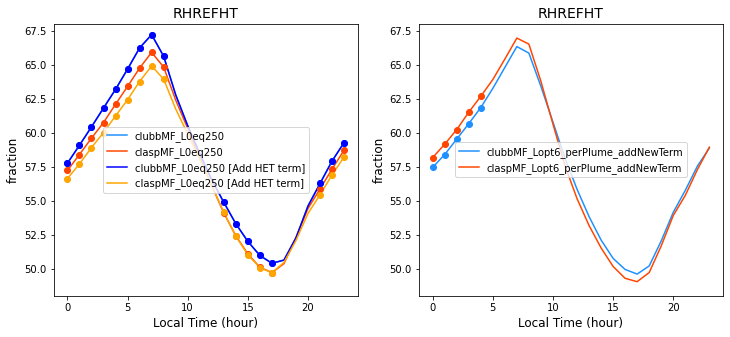

In [50]:
varPlot     = 'RHREFHT'
yMax        = 68
yMin        = 48
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     =  1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'TREFHT'}, xlabel='Local Time (hour)', ylabel='K'>,
       <AxesSubplot:title={'center':'TREFHT'}, xlabel='Local Time (hour)', ylabel='K'>],
      dtype=object)

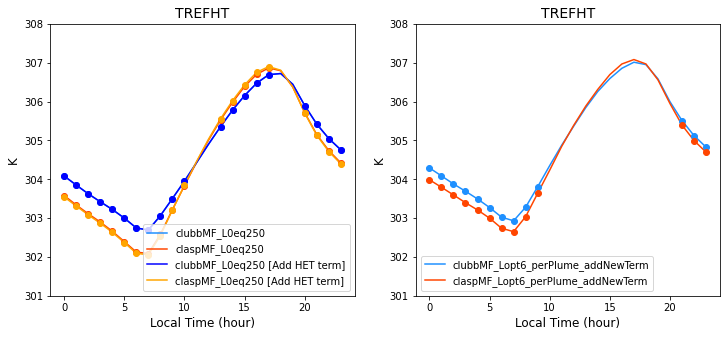

In [53]:
varPlot     = 'TREFHT'
yMax        = 308
yMin        = 301
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'CLDTOT'}, xlabel='Local Time (hour)', ylabel='fraction'>,
       <AxesSubplot:title={'center':'CLDTOT'}, xlabel='Local Time (hour)', ylabel='fraction'>],
      dtype=object)

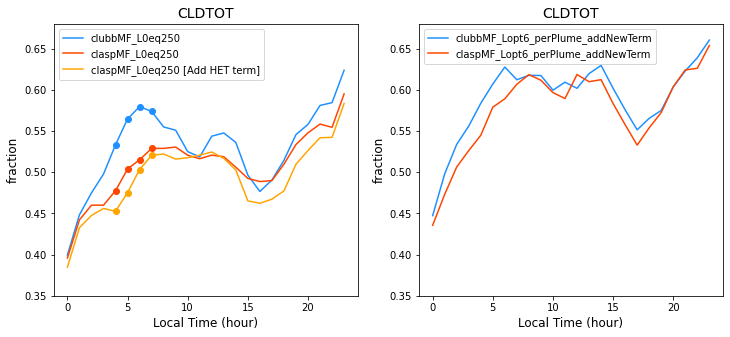

In [58]:
varPlot     = 'CLDTOT'
yMax        = 0.68
yMin        = 0.35
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'CLDLOW'}, xlabel='Local Time (hour)', ylabel='fraction'>,
       <AxesSubplot:title={'center':'CLDLOW'}, xlabel='Local Time (hour)', ylabel='fraction'>],
      dtype=object)

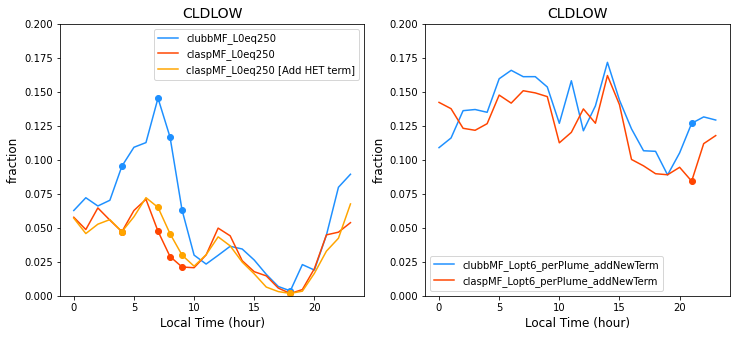

In [60]:
varPlot     = 'CLDLOW'
yMax        = 0.2
yMin        = 0.0
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'TGCLDLWP'}, xlabel='Local Time (hour)', ylabel='kg/m2'>,
       <AxesSubplot:title={'center':'TGCLDLWP'}, xlabel='Local Time (hour)', ylabel='kg/m2'>],
      dtype=object)

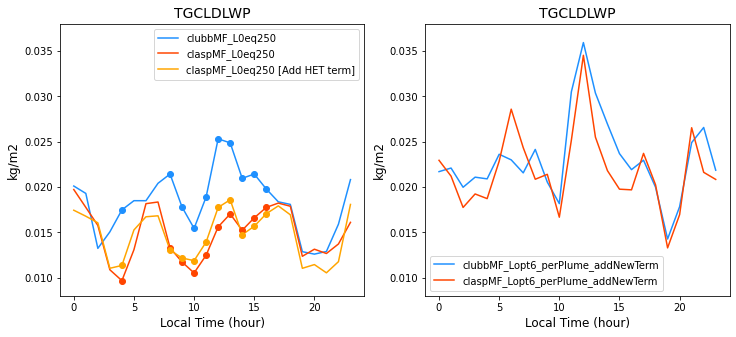

In [64]:
varPlot     = 'TGCLDLWP'
yMax        = 0.038
yMin        = 0.008
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'TMQ'}, xlabel='Local Time (hour)', ylabel='kg/m2'>,
       <AxesSubplot:title={'center':'TMQ'}, xlabel='Local Time (hour)', ylabel='kg/m2'>],
      dtype=object)

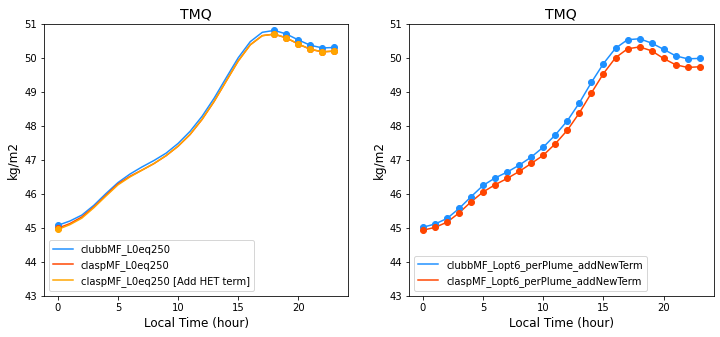

In [65]:
varPlot     = 'TMQ'
yMax        = 51
yMin        = 43
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'PBLH'}, xlabel='Local Time (hour)', ylabel='m'>,
       <AxesSubplot:title={'center':'PBLH'}, xlabel='Local Time (hour)', ylabel='m'>],
      dtype=object)

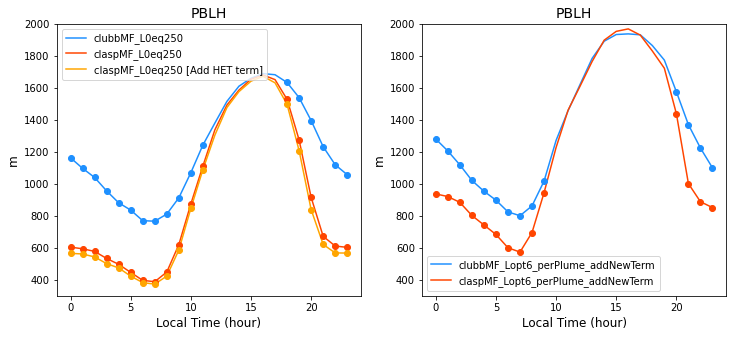

In [68]:
varPlot     = 'PBLH'
yMax        = 2000
yMin        = 300
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'PRECT'}, xlabel='Local Time (hour)', ylabel='mm/d'>,
       <AxesSubplot:title={'center':'PRECT'}, xlabel='Local Time (hour)', ylabel='mm/d'>],
      dtype=object)

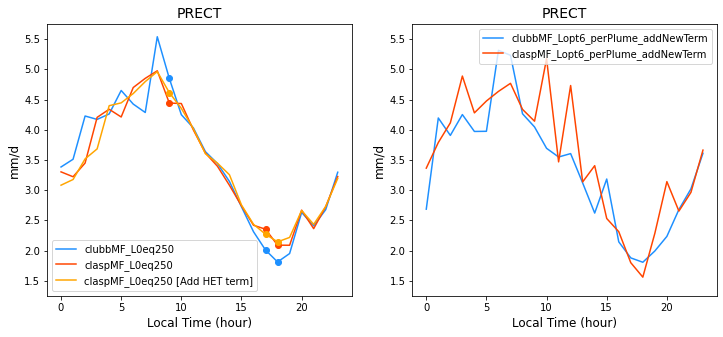

In [71]:
varPlot     = 'PRECT'
yMax        = 5.75
yMin        = 1.25
unitsString = 'mm/d'
setYlims    = True
valMult     = 86400*1e3

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'PRECC'}, xlabel='Local Time (hour)', ylabel='mm/d'>,
       <AxesSubplot:title={'center':'PRECC'}, xlabel='Local Time (hour)', ylabel='mm/d'>],
      dtype=object)

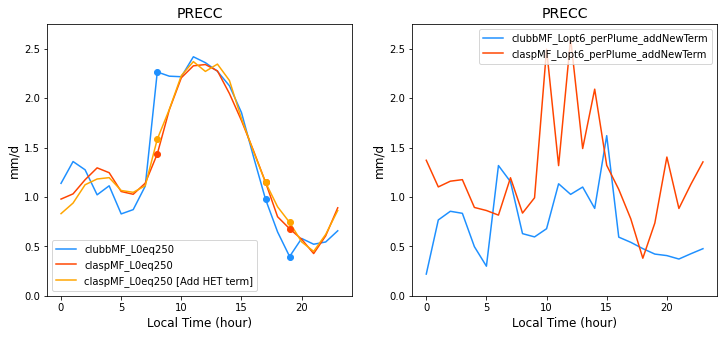

In [74]:
varPlot     = 'PRECC'
yMax        = 2.75
yMin        = 0.0
unitsString = 'mm/d'
setYlims    = True
valMult     = 86400*1e3

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'LHFLX'}, xlabel='Local Time (hour)', ylabel='W/m2'>,
       <AxesSubplot:title={'center':'LHFLX'}, xlabel='Local Time (hour)', ylabel='W/m2'>],
      dtype=object)

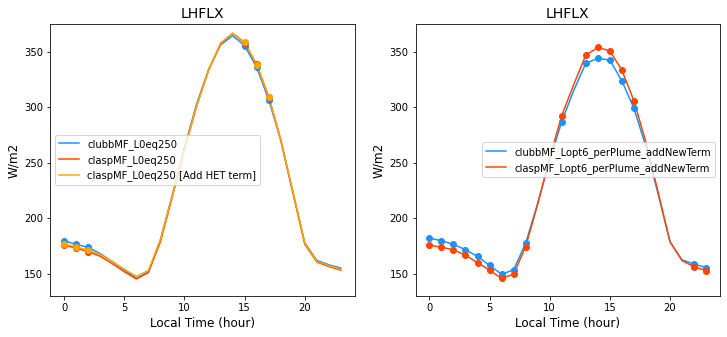

In [80]:
varPlot     = 'LHFLX'
yMax        = 375
yMin        = 130
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


array([<AxesSubplot:title={'center':'SHFLX'}, xlabel='Local Time (hour)', ylabel='W/m2'>,
       <AxesSubplot:title={'center':'SHFLX'}, xlabel='Local Time (hour)', ylabel='W/m2'>],
      dtype=object)

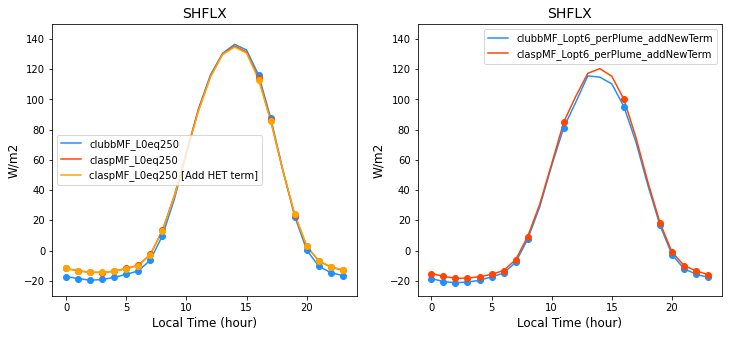

In [82]:
varPlot     = 'SHFLX'
yMax        = 150
yMin        = -30
unitsString = scamDS[varPlot].units
setYlims    = True
valMult     = 1

plotDiurnalCycle(scamDS, scamDS_addTerm, scamDS_Lopt6pp, 
                 varPlot, valMult, unitsString,
                 setYlims, yMin, yMax)


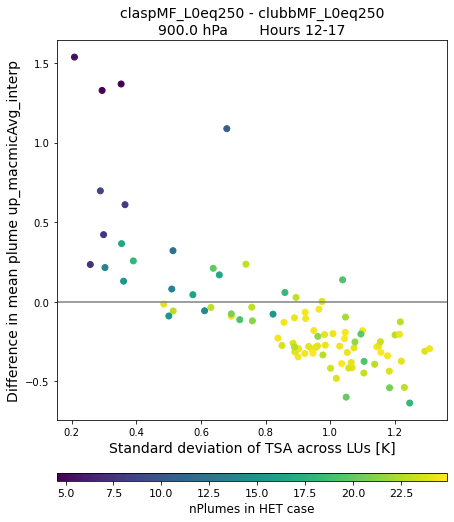

In [87]:
# ## Choose an hour range
# hrStart = 12
# hrEnd   = 17

# levInterpSel = 900.0
# ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

# var_h0 = 'nPlumesActive'
# # var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
# clmVar = 'TSA'

# hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
# thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

# hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
# thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

# hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
# thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

# ## THE UNIQUE PART: 
# ## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
# ctrlSel = 0
# caseSel = 1

# HOMwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=0).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
# HETwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=1).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


# ## Set up the plot
# fig,axs = plt.subplots(1,1,figsize=(7,7))

# splot = axs.scatter(thisHr_clm.isel(case=0).std(dim='landunit'), 
#          thisHr_h2.isel(case=1).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
#          c=thisHr_h0.isel(case=1) )

# # Add colorbar
# ax_position = axs.get_position()
# cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
# cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
# cbar.ax.tick_params(labelsize=11)
# cbar.set_label(label='nPlumes in HET case', size=12)

# # Other plot options
# axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
# axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
# axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# # axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

# axs.axhline(0,color='grey')



In [ ]:
scamDS_h2.total_wp2

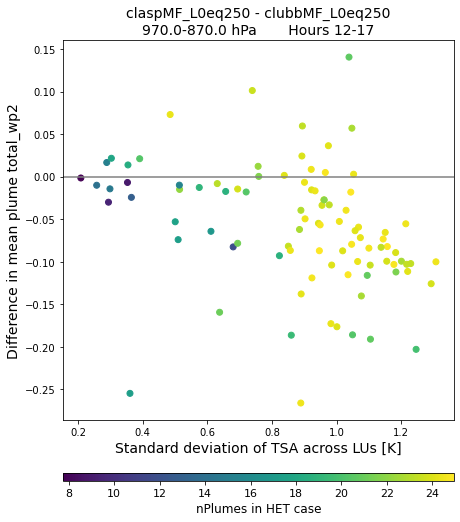

In [62]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

# levInterpSel = 900.0
# ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)


var_h0 = 'nPlumesActive'
# var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
var_h2 = 'total_wp2'
clmVar = 'TSA'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

## THE UNIQUE PART: 
## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
ctrlSel = 0
caseSel = 1

HOMwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=0).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=1).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.isel(case=0).std(dim='landunit'), 
         # thisHr_h2.isel(case=1).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         thisHr_h2.isel(case=1).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).weighted(HOMwgts).mean(dim='nens'), 
         c=thisHr_h0.isel(case=1) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
# axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



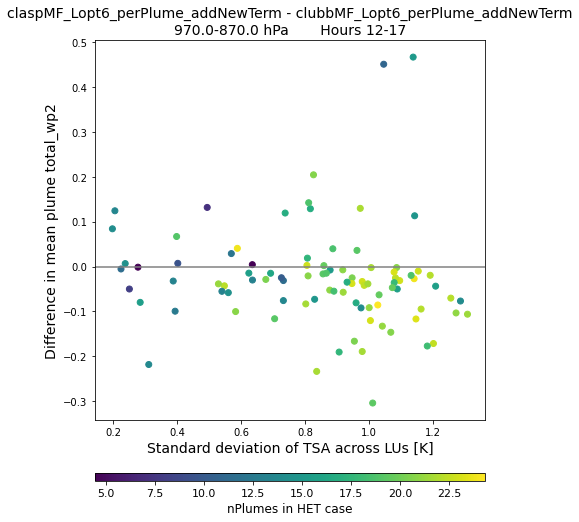

In [63]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

# levInterpSel = 900.0
# ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2_Lopt6pp.levInterp.values>=levInterpMax) & (scamDS_h2_Lopt6pp.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)


var_h0 = 'nPlumesActive'
# var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
var_h2 = 'total_wp2'
clmVar = 'TSA'

hrMean_h0 = scamDS_Lopt6pp[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2_Lopt6pp[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2_Lopt6pp[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

## THE UNIQUE PART: 
## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
ctrlSel = 0
caseSel = 1

HOMwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=0).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=1).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.isel(case=0).std(dim='landunit'), 
         # thisHr_h2.isel(case=1).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         thisHr_h2.isel(case=1).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).weighted(HOMwgts).mean(dim='nens'), 
         c=thisHr_h0.isel(case=1) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
# axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



In [75]:
clmDS_h2_Lopt6pp

<xarray.Dataset>
Dimensions:             (case: 2, column: 8, gridcell: 1, hist_interval: 2, landunit: 4, levdcmp: 1, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, pft: 8, time: 26496)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 1.0
  * time                (time) datetime64[ns] 2015-06-02T00:01:00 ... 2015-09...
  * case                (case) object 'clubbMF_Lopt6_perPlume_addNewTerm' 'cl...
Dimensions without coordinates: column, gridcell, hist_interval, landunit, lndgrid, pft
Data variables:
    mcdate              (case, time) int32 20150602 20150602 ... 20150902
    mcsec               (case, time) int32 18060 18360 18660 ... 17460 17760
    mdcur               (case, time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    mscur               (case, time) int32 0 300 600 900 ... 85500 85800 86100
    nstep               (case, time) int32 288 289 290 291 ... 572 573 574 575
    time_bounds         (case, time, hist_interval) object 2015-06-02 04:56:0...
    date_written        (case, time) |S16 b'11/06/23' ... b'11/07/23'
    time_written        (case, time) |S16 b'15:47:28' ... b'08:57:56'
    lon                 (case, lndgrid) float32 261.6 261.6
    lat                 (case, lndgrid) float32 37.67 37.67
    area                (case, lndgrid) float32 nan nan
    landfrac            (case, lndgrid) float32 1.0 1.0
    landmask            (case, lndgrid) float64 1.0 1.0
    pftmask             (case, lndgrid) float64 1.0 1.0
    nbedrock            (case, lndgrid) float64 20.0 20.0
    grid1d_lon          (case, gridcell) float64 261.6 261.6
    grid1d_lat          (case, gridcell) float64 37.67 37.67
    grid1d_ixy          (case, gridcell) float64 1.0 1.0
    grid1d_jxy          (case, gridcell) float64 1.0 1.0
    land1d_lon          (case, landunit) float64 261.6 261.6 ... 261.6 261.6
    land1d_lat          (case, landunit) float64 37.67 37.67 ... 37.67 37.67
    land1d_ixy          (case, landunit) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    land1d_jxy          (case, landunit) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    land1d_gi           (case, landunit) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    land1d_wtgcell      (case, landunit) float64 0.25 0.25 0.25 ... 0.25 0.25
    land1d_ityplunit    (case, landunit) float64 1.0 2.0 8.0 5.0 1.0 2.0 8.0 5.0
    land1d_active       (case, landunit) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    cols1d_lon          (case, column) float64 261.6 261.6 261.6 ... 261.6 261.6
    cols1d_lat          (case, column) float64 37.67 37.67 37.67 ... 37.67 37.67
    cols1d_ixy          (case, column) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cols1d_jxy          (case, column) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cols1d_gi           (case, column) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    cols1d_li           (case, column) float64 1.0 2.0 3.0 3.0 ... 3.0 3.0 4.0
    cols1d_wtgcell      (case, column) float64 0.25 0.25 0.125 ... 0.0125 0.25
    cols1d_wtlunit      (case, column) float64 1.0 1.0 0.5 ... 0.1167 0.05 1.0
    cols1d_itype_col    (case, column) float64 1.0 216.0 71.0 ... 74.0 75.0 5.0
    cols1d_itype_lunit  (case, column) float64 1.0 2.0 8.0 8.0 ... 8.0 8.0 5.0
    cols1d_active       (case, column) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    pfts1d_lon          (case, pft) float64 261.6 261.6 261.6 ... 261.6 261.6
    pfts1d_lat          (case, pft) float64 37.67 37.67 37.67 ... 37.67 37.67
    pfts1d_ixy          (case, pft) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pfts1d_jxy          (case, pft) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pfts1d_gi           (case, pft) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pfts1d_li           (case, pft) float64 1.0 2.0 3.0 3.0 ... 3.0 3.0 3.0 4.0
    pfts1d_ci 

In [80]:
clmDS_h2_Lopt6pp.Q2M

<xarray.DataArray 'Q2M' (case: 2, time: 26496, landunit: 4)>
array([[[0.01497958, 0.01489345, 0.01369286, 0.01502111],
        [0.01498448, 0.01489897, 0.01370163, 0.01502785],
        [0.01496556, 0.01487942, 0.01370472, 0.01503265],
        ...,
        [0.01434058, 0.01426241, 0.01416048, 0.01582503],
        [0.01434898, 0.01427209, 0.01417274, 0.01582858],
        [0.01435998, 0.01428281, 0.01418238, 0.01583941]],

       [[0.01544001, 0.01546431, 0.01411861, 0.01542942],
        [0.01541383, 0.01544045, 0.01407756, 0.01538226],
        [0.01534077, 0.01536342, 0.01405213, 0.01536581],
        ...,
        [0.01417492, 0.01409719, 0.01398615, 0.01566504],
        [0.01418027, 0.01410308, 0.01400422, 0.01567106],
        [0.01418496, 0.01410715, 0.01400413, 0.0156789 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-06-02T00:01:00 ... 2015-09-01T23:56:0...
  * case     (case) object 'clubbMF_Lopt6_perPlume_addNewTerm' 'claspMF_Lopt6...
Dimensions without coordinates: landunit
Attributes:
    long_name:     2m specific humidity
    units:         kg/kg
    cell_methods:  time: mean

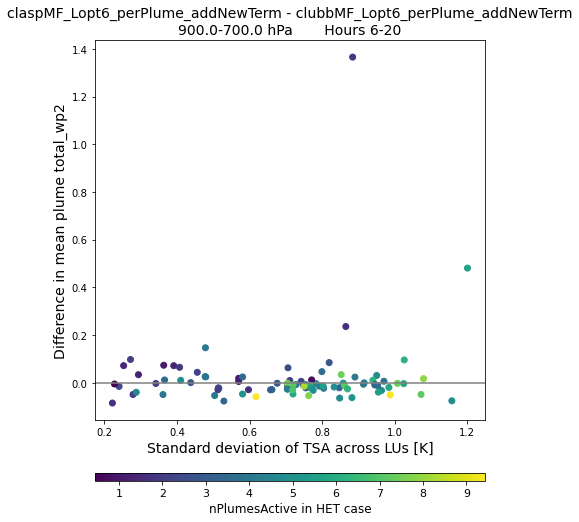

In [92]:
## Choose an hour range
# hrStart = 12
# hrEnd   = 17
hrStart = 6
hrEnd   = 20


# levInterpSel = 900.0
# ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

levInterpMax = 700.0
levInterpMin = 900.0
ilevSel = np.where( (scamDS_h2_Lopt6pp.levInterp.values>=levInterpMax) & (scamDS_h2_Lopt6pp.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)


var_h0 = 'nPlumesActive'
# var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
var_h2 = 'total_wp2'
clmVar = 'TSA'
# clmVar = 'QFLX'

hrMean_h0 = scamDS_Lopt6pp[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2_Lopt6pp[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2_Lopt6pp[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

## THE UNIQUE PART: 
## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
ctrlSel = 0
caseSel = 1

HOMwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=0).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=1).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.isel(case=0).std(dim='landunit'), 
         # thisHr_h2.isel(case=1).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         # thisHr_h2.isel(case=1).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).weighted(HOMwgts).mean(dim='nens'), 
         thisHr_h2.isel(case=1) - thisHr_h2.isel(case=0), 
         c=thisHr_h0.isel(case=1) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label=str(var_h0)+' in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
# axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



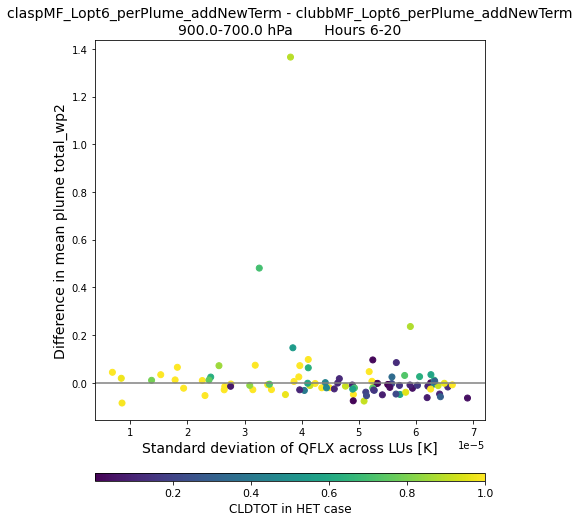

In [91]:
## Choose an hour range
# hrStart = 12
# hrEnd   = 17
hrStart = 6
hrEnd   = 20

# levInterpSel = 900.0
# ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

levInterpMax = 700.0
levInterpMin = 900.0
ilevSel = np.where( (scamDS_h2_Lopt6pp.levInterp.values>=levInterpMax) & (scamDS_h2_Lopt6pp.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)


var_h0 = 'CLDTOT'
# var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
var_h2 = 'total_wp2'
# clmVar = 'TSA'
clmVar = 'QFLX'

hrMean_h0 = scamDS_Lopt6pp[var_h0].resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2_Lopt6pp[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2_Lopt6pp[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

## THE UNIQUE PART: 
## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
ctrlSel = 0
caseSel = 1

HOMwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=0).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.isel(case=1).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.isel(case=0).std(dim='landunit'), 
         # thisHr_h2.isel(case=1).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         # thisHr_h2.isel(case=1).weighted(HETwgts).mean(dim='nens') - thisHr_h2.isel(case=0).weighted(HOMwgts).mean(dim='nens'), 
         thisHr_h2.isel(case=1) - thisHr_h2.isel(case=0), 
         c=thisHr_h0.isel(case=1) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label=str(var_h0)+' in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
# axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.set_title(str(thisHr_h2.isel(case=1).case.values)+' - '+str(thisHr_h2.isel(case=0).case.values)+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



## Test digging into where w'2 changes are positive? 

In [9]:
## Choose an hour range (full daily sample?)
hrStart = 6
hrEnd   = 20

levInterpMax = 700.0
levInterpMin = 900.0
ilevSel = np.where( (scamDS_h2_Lopt6pp.levInterp.values>=levInterpMax) & (scamDS_h2_Lopt6pp.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)

varDist = 'total_wp2'

hrMean_h2 = scamDS_h2_Lopt6pp[varDist].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

diffVar = thisHr_h2.isel(case=1) - thisHr_h2.isel(case=0)



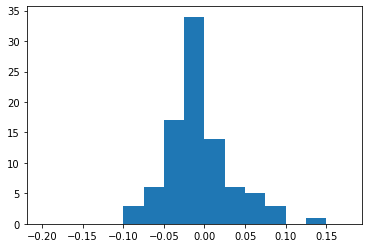

diffVar 25th percentile =  -0.026915259455557956
diffVar 75th percentile =  0.01357900344681573


In [109]:
bins = np.arange(-0.2, 0.2, 0.025)
plt.hist(diffVar, bins)
plt.show() 

print('diffVar 25th percentile = ', np.nanpercentile(diffVar,25))
print('diffVar 75th percentile = ', np.nanpercentile(diffVar,75))



In [124]:
## 10th and 90th percentiles
# nDays_positive = np.where(diffVar>=0.07)[0] 
# nDays_negative = np.where(diffVar<=-0.05)[0]

# 25th and 75th percentiles
nDays_positive = np.where(diffVar>=0.014)[0] 
nDays_negative = np.where(diffVar<=-0.027)[0]

print('nDays_positive = ', len(nDays_positive))
print('nDays_negative = ', len(nDays_negative))

## Select those days 
dailyDS_pos = thisHr_h2.isel(time=nDays_positive)
dailyDS_neg = thisHr_h2.isel(time=nDays_negative)

## Select those days in the *full* DS 
iTimes_keep_pos = []
iTimes_h0_keep_pos = []
for iDays in range(len(nDays_positive)):
    iMatch_pos = np.where( (scamDS_h2_Lopt6pp['time.month'].values == dailyDS_pos['time.month'].values[iDays]) &
                           (scamDS_h2_Lopt6pp['time.day'].values == dailyDS_pos['time.day'].values[iDays]))[0]
    iTimes_keep_pos = np.append(iTimes_keep_pos, iMatch_pos)
    
    iMatch_h0_pos = np.where( (scamDS_Lopt6pp['time.month'].values == dailyDS_pos['time.month'].values[iDays]) &
                              (scamDS_Lopt6pp['time.day'].values == dailyDS_pos['time.day'].values[iDays]))[0]
    iTimes_h0_keep_pos = np.append(iTimes_h0_keep_pos, iMatch_h0_pos)

iTimes_keep_neg = []
iTimes_h0_keep_neg = []
for iDays in range(len(nDays_negative)):
    iMatch_neg = np.where( (scamDS_h2_Lopt6pp['time.month'].values == dailyDS_neg['time.month'].values[iDays]) &
                           (scamDS_h2_Lopt6pp['time.day'].values == dailyDS_neg['time.day'].values[iDays]))[0]
    iTimes_keep_neg = np.append(iTimes_keep_neg, iMatch_neg)
    
    iMatch_h0_neg = np.where( (scamDS_Lopt6pp['time.month'].values == dailyDS_neg['time.month'].values[iDays]) &
                              (scamDS_Lopt6pp['time.day'].values == dailyDS_neg['time.day'].values[iDays]))[0]
    iTimes_h0_keep_neg = np.append(iTimes_h0_keep_neg, iMatch_h0_neg)

scamDS_h2_Lopt6pp_pos = scamDS_h2_Lopt6pp.isel(time=iTimes_keep_pos.astype(int)).resample(time='1H').mean(dim='time')
scamDS_h2_Lopt6pp_neg = scamDS_h2_Lopt6pp.isel(time=iTimes_keep_neg.astype(int)).resample(time='1H').mean(dim='time')

scamDS_Lopt6pp_pos = scamDS_Lopt6pp.isel(time=iTimes_h0_keep_pos.astype(int)).resample(time='1H').mean(dim='time')
scamDS_Lopt6pp_neg = scamDS_Lopt6pp.isel(time=iTimes_h0_keep_neg.astype(int)).resample(time='1H').mean(dim='time')


nDays_positive =  23
nDays_negative =  23


In [131]:
diurnal_Lopt6pp_pos = scamDS_Lopt6pp_pos.groupby('time.hour').mean(dim='time')
diurnal_Lopt6pp_neg = scamDS_Lopt6pp_neg.groupby('time.hour').mean(dim='time')

diurnal_h2_Lopt6pp_pos = scamDS_h2_Lopt6pp_pos.groupby('time.hour').mean(dim='time')
diurnal_h2_Lopt6pp_neg = scamDS_h2_Lopt6pp_neg.groupby('time.hour').mean(dim='time')



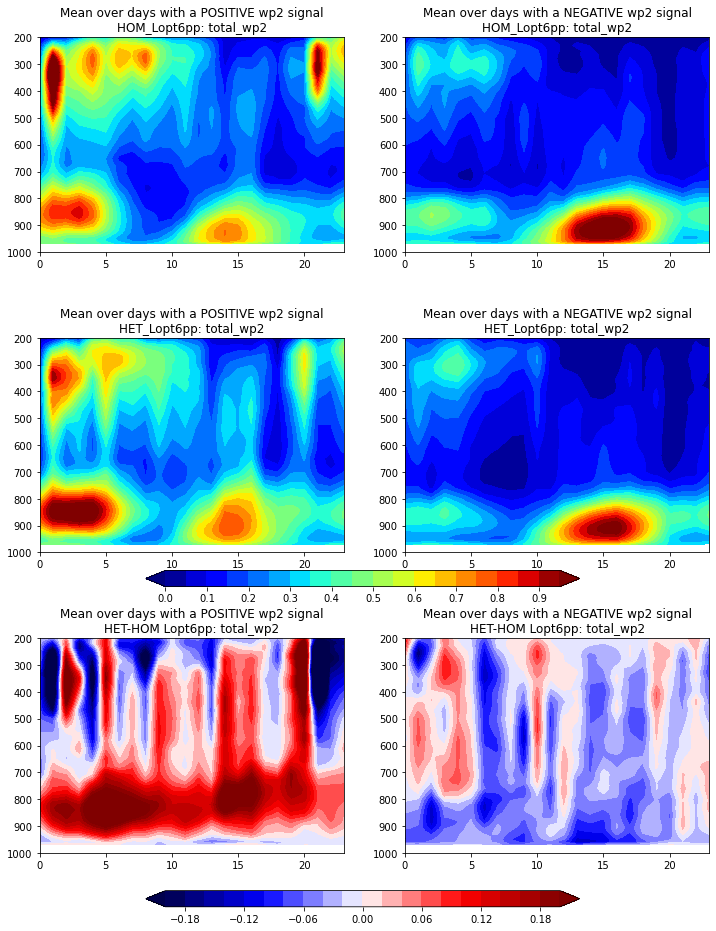

In [167]:
## Use this plot for h2 variables
varPlot = 'total_wp2'
pLims   = np.arange(0,1, 0.05)
dLims   = np.arange(-0.2, 0.22, 0.02) 

fig,axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.ravel()

axs[0].contourf(diurnal_h2_Lopt6pp_pos.hour.values, diurnal_h2_Lopt6pp_pos.levInterp.values, 
                diurnal_h2_Lopt6pp_pos[varPlot].isel(case=0).values.transpose(), pLims, cmap='jet', extend = 'both')
axs[2].contourf(diurnal_h2_Lopt6pp_pos.hour.values, diurnal_h2_Lopt6pp_pos.levInterp.values, 
                diurnal_h2_Lopt6pp_pos[varPlot].isel(case=1).values.transpose(), pLims, cmap='jet', extend = 'both')

axs[1].contourf(diurnal_h2_Lopt6pp_neg.hour.values, diurnal_h2_Lopt6pp_neg.levInterp.values, 
                diurnal_h2_Lopt6pp_neg[varPlot].isel(case=0).values.transpose(), pLims, cmap='jet', extend = 'both')
cplt = axs[3].contourf(diurnal_h2_Lopt6pp_neg.hour.values, diurnal_h2_Lopt6pp_neg.levInterp.values, 
                diurnal_h2_Lopt6pp_neg[varPlot].isel(case=1).values.transpose(), pLims, cmap='jet', extend = 'both')

#Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.02, ax_position.width+0.15, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)



## Plot difference
diff_pos = diurnal_h2_Lopt6pp_pos[varPlot].isel(case=1) - diurnal_h2_Lopt6pp_pos[varPlot].isel(case=0)
diff_neg = diurnal_h2_Lopt6pp_neg[varPlot].isel(case=1) - diurnal_h2_Lopt6pp_neg[varPlot].isel(case=0)

axs[4].contourf(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos.levInterp.values, 
             diff_pos.values.transpose(), dLims, cmap='seismic', extend = 'both')

cplt = axs[5].contourf(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg.levInterp.values, 
             diff_neg.values.transpose(), dLims, cmap='seismic', extend='both')

#Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.05, ax_position.width+0.15, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)

## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([1000,200])
axs[1].set_ylim([1000,200])
axs[2].set_ylim([1000,200])
axs[3].set_ylim([1000,200])
axs[4].set_ylim([1000,200])
axs[5].set_ylim([1000,200])

axs[0].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HOM_Lopt6pp: '+varPlot)
axs[1].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HOM_Lopt6pp: '+varPlot)
axs[2].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HET_Lopt6pp: '+varPlot)
axs[3].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HET_Lopt6pp: '+varPlot)
axs[4].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HET-HOM Lopt6pp: '+varPlot)
axs[5].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HET-HOM Lopt6pp: '+varPlot)

fig.subplots_adjust(hspace=0.4)


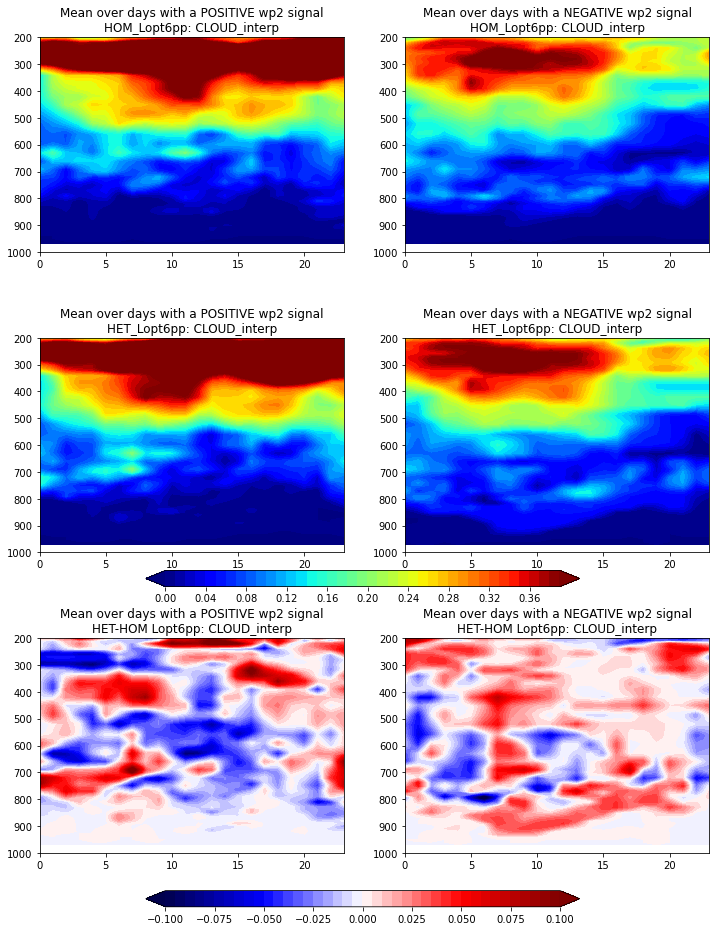

In [192]:
## Use this plot for h0 variables
varPlot = 'CLOUD_interp'
pLims   = np.arange(0,0.4,0.01)
dLims   = np.arange(-0.1, 0.105, 0.005) 

# varPlot = 'OMEGA_interp'
# pLims   = np.arange(-0.15,0.1,0.01)
# dLims   = np.arange(-3e-4, 3.1e-4, 0.1e-4) 

# varPlot = 'CLDLIQ_interp'
# pLims   = np.arange(0.0, 3e-5, 1e-6)
# dLims   = np.arange(-3e-5, 3.1e-5, 0.1e-5) 

# varPlot = 'THETAL_interp'
# pLims   = np.arange(300, 340, 1)
# dLims   = np.arange(-5, 5.1, 0.1) 

fig,axs = plt.subplots(3,2, figsize=(12,15))
axs     = axs.ravel()

axs[0].contourf(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos.levInterp.values, 
                diurnal_Lopt6pp_pos[varPlot].isel(case=0).values.transpose(), pLims, cmap='jet', extend = 'both')
axs[2].contourf(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos.levInterp.values, 
                diurnal_Lopt6pp_pos[varPlot].isel(case=1).values.transpose(), pLims, cmap='jet', extend = 'both')

axs[1].contourf(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg.levInterp.values, 
                diurnal_Lopt6pp_neg[varPlot].isel(case=0).values.transpose(), pLims, cmap='jet', extend = 'both')
cplt = axs[3].contourf(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg.levInterp.values, 
                diurnal_Lopt6pp_neg[varPlot].isel(case=1).values.transpose(), pLims, cmap='jet', extend = 'both')

#Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.02, ax_position.width+0.15, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)



## Plot difference
diff_pos = diurnal_Lopt6pp_pos[varPlot].isel(case=1) - diurnal_Lopt6pp_pos[varPlot].isel(case=0)
diff_neg = diurnal_Lopt6pp_neg[varPlot].isel(case=1) - diurnal_Lopt6pp_neg[varPlot].isel(case=0)

axs[4].contourf(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos.levInterp.values, 
             diff_pos.values.transpose(), dLims, cmap='seismic', extend = 'both')

cplt = axs[5].contourf(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg.levInterp.values, 
             diff_neg.values.transpose(), dLims, cmap='seismic', extend='both')

#Add colorbar
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.05, ax_position.width+0.15, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)

## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([1000,200])
axs[1].set_ylim([1000,200])
axs[2].set_ylim([1000,200])
axs[3].set_ylim([1000,200])
axs[4].set_ylim([1000,200])
axs[5].set_ylim([1000,200])

axs[0].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HOM_Lopt6pp: '+varPlot)
axs[1].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HOM_Lopt6pp: '+varPlot)
axs[2].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HET_Lopt6pp: '+varPlot)
axs[3].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HET_Lopt6pp: '+varPlot)
axs[4].set_title('Mean over days with a POSITIVE wp2 signal\n'+'HET-HOM Lopt6pp: '+varPlot)
axs[5].set_title('Mean over days with a NEGATIVE wp2 signal\n'+'HET-HOM Lopt6pp: '+varPlot)

fig.subplots_adjust(hspace=0.4)


Text(0.5, 1.0, 'QREFHT')

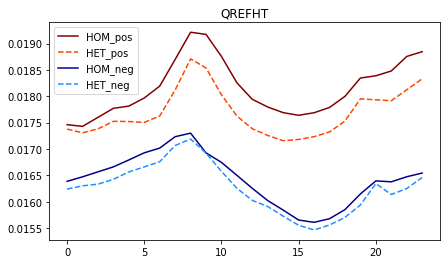

In [209]:
varPlot = 'QREFHT' 

fig,axs = plt.subplots(1,1, figsize=(7,4))

axs.plot(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos[varPlot].isel(case=0).values, color = 'maroon', label='HOM_pos')
axs.plot(diurnal_Lopt6pp_pos.hour.values, diurnal_Lopt6pp_pos[varPlot].isel(case=1).values, '--', color = 'orangered', label='HET_pos')

axs.plot(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg[varPlot].isel(case=0).values, color ='darkblue', label='HOM_neg')
axs.plot(diurnal_Lopt6pp_neg.hour.values, diurnal_Lopt6pp_neg[varPlot].isel(case=1).values, '--', color = 'dodgerblue', label='HET_neg')

axs.legend()
axs.set_title(varPlot)


In [197]:
diurnal_Lopt6pp_neg

<xarray.Dataset>
Dimensions:                 (case: 2, hour: 24, ilev: 59, lev: 58, levInterp: 78)
Coordinates:
    lat                     float64 36.6
    lon                     float64 262.5
  * ilev                    (ilev) float64 2.055 3.98 6.909 ... 995.1 1e+03
  * lev                     (lev) float64 3.018 5.445 9.087 ... 991.2 997.5
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'clubbMF_Lopt6_perPlume_addNewTerm'...
  * hour                    (hour) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
Data variables:
    wpthlp                  (hour, case, ilev) float32 0.0 ... -0.01012
    wprtp                   (hour, case, ilev) float32 0.0 ... 5.368e-05
    rtp2                    (hour, case, ilev) float32 1e-16 1e-16 ... 4.689e-08
    thlm                    (hour, case, ilev) float32 1.301e+03 ... 307.4
    rtm                     (hour, case, ilev) float32 3.75e-06 ... 0.01522
    wm_zm                   (hour, case, ilev) float32 0.0 0.0 ... 4.616e-05
    rtm_zm                  (hour, case, ilev) float32 3.8e-06 ... 0.01519
    thlm_zm                 (hour, case, ilev) float32 1.444e+03 ... 307.4
    SWCF                    (hour, case) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWCF                    (hour, case) float32 2.25 2.389 ... 2.503 2.667
    TS                      (hour, case) float32 303.3 303.1 ... 303.6 303.4
    CLOUD                   (hour, case, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    FSNS                    (hour, case) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FLNS                    (hour, case) float32 4.594 4.536 ... 4.325 4.529
    PS                      (hour, case) float32 9.706e+04 ... 9.703e+04
    QREFHT                  (hour, case) float32 0.01639 0.01624 ... 0.01646
    U10                     (hour, case) float32 4.075 3.656 ... 4.138 3.837
    CLDHGH                  (hour, case) float32 0.348 0.3901 ... 0.4565 0.4126
    CLDLIQ                  (hour, case, lev) float32 0.0 0.0 ... 1.203e-27
    CONCLD                  (hour, case, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    TMQ                     (hour, case) float32 44.87 44.82 ... 47.44 47.2
    P0                      (hour, case) float64 1e+05 1e+05 ... 1e+05 1e+05
    hyam                    (hour, case, lev) float64 0.003018 0.005445 ... 0.0
    hybm                    (hour, case, lev) float64 0.0 0.0 ... 0.9908 0.9975
    hyai                    (hour, case, ilev) float64 0.002055 0.00398 ... 0.0
    hybi                    (hour, case, ilev) float64 0.0 0.0 ... 0.9951 1.0
    PHIS                    (hour, case) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    USTAR                   (hour, case) float32 0.3809 0.3461 ... 0.3873 0.3608
    QT                      (hour, case, lev) float32 3.75e-06 ... 0.01523
    GCLDLWP                 (hour, case, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    THETAL                  (hour, case, lev) float32 1.29e+03 ... 304.7
    CDNUMC                  (hour, case) float32 5.456e+09 ... 1.246e+10
    CLDBOT                  (hour, case) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDLOW                  (hour, case) float32 0.1525 0.1546 ... 0.1435 0.1296
    CLDMED                  (hour, case) float32 0.2947 0.2877 ... 0.2426 0.2479
    CLDTOP                  (hour, case) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDTOT                  (hour, case) float32 0.4185 0.4492 ... 0.5667 0.5425
    THLP2_CLUBB             (hour, case, ilev) float32 0.0001 ... 0.00122
    CLOUDCOVER_CLUBB        (hour, case, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CLOUDFRAC_CLUBB         (hour, case, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RCM_CLUBB               (hour, case, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RTP2_CLUBB              (hour, case, ilev) float32 1e-10 1e-10 ... 0.04689
    RTPTHLP_CLUBB           (hour, case, ilev) float32 0.0 ... -0.001599
    RVMTEND_CLUBB           (hour, case, lev) float32 0.0 0.0 ... 9.814e

In [215]:
## Choose an hour range (full daily sample?)
hrStart = 6
hrEnd   = 20

hrMean_h2 = scamDS_h2_Lopt6pp.resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h0 = scamDS_Lopt6pp.resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')



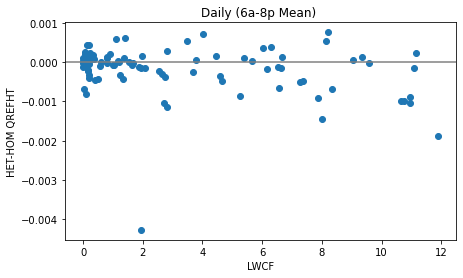

In [222]:
## Plot scatters
ctrlVar     = 'LWCF'
responseVar = 'QREFHT'

diffPlt = thisHr_h0[responseVar].isel(case=1) - thisHr_h0[responseVar].isel(case=0)

fig,axs = plt.subplots(1,1,figsize=(7,4))

axs.scatter(thisHr_h0[ctrlVar].isel(case=0).values, diffPlt.values)
axs.set_title('Daily (6a-8p Mean) ')
axs.set_xlabel(ctrlVar)
axs.set_ylabel('HET-HOM '+responseVar)

axs.axhline(0, color='grey')


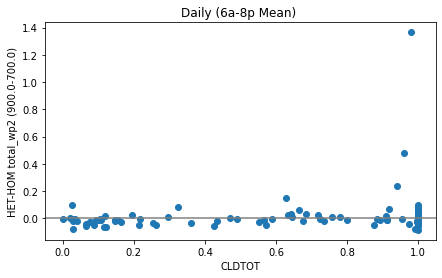

In [227]:
## Plot scatters
ctrlVar     = 'CLDTOT'
responseVar_h2 = 'total_wp2'

levInterpMax = 700.0
levInterpMin = 900.0
ilevSel = np.where( (scamDS_h2_Lopt6pp.levInterp.values>=levInterpMax) & (scamDS_h2_Lopt6pp.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2_Lopt6pp.levInterp.isel(levInterp=ilevSel).values)

hrMean_h2 = scamDS_h2_Lopt6pp[responseVar_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

diffPlt = thisHr_h2.isel(case=1) - thisHr_h2.isel(case=0)

fig,axs = plt.subplots(1,1,figsize=(7,4))

axs.scatter(thisHr_h0[ctrlVar].isel(case=0).values, diffPlt.values)
axs.set_title('Daily (6a-8p Mean) ')
axs.set_xlabel(ctrlVar)
axs.set_ylabel('HET-HOM '+responseVar_h2 +' ('+str(levInterpMin)+'-'+str(levInterpMax)+')')

axs.axhline(0, color='grey')


## <font color='magenta'> What about Meng's definition of days again? </font>

In [ ]:
# scamDS_Lopt6pp
# scamDS_addTerm

In [25]:
## Use Meng's definition of clear/cloudy/rain days 

DSuse = scamDS_addTerm
# DSuse = scamDS_Lopt6pp

DSuse_h2 = scamDS_h2_addTerm
# DSuse_h2 = scamDS_h2_Lopt6pp

q_var = 'CLDLIQ_interp'
# q_ctl  = scamDS_Lopt6pp.isel(case=0)[q_var]
# q_test = scamDS_Lopt6pp.isel(case=1)[q_var]
q_ctl  = DSuse.isel(case=0)[q_var]
q_test = DSuse.isel(case=1)[q_var]

p_var = 'PRECT'
# p_ctl  = scamDS_Lopt6pp.isel(case=0)[p_var]
# p_test = scamDS_Lopt6pp.isel(case=1)[p_var]
p_ctl  = DSuse.isel(case=0)[p_var]
p_test = DSuse.isel(case=1)[p_var]

# plim = 0.5   #mm/day -- Value used in Huang et al. 
# qlim = 1e-6  #kg/kg  -- Value used in Huang et al. 

# Lopt6pp
plim = 1   #mm/day
qlim = 1e-5  #kg/kg


# L0_addTerm
plim = 1.76   #mm/day
qlim = 1.54e-7  #kg/kg


minHr = 6
maxHr = 18

selHours = np.where( (DSuse['time.hour'].values>=minHr) & (DSuse['time.hour'].values<=maxHr) )[0]

levSel   = np.where((DSuse.levInterp.values>600))[0]

# Daily mean rain rate in right units:
p_dailyMean = p_ctl.isel(time=selHours).resample(time='1D').mean(dim='time')*1e3*86400
p_dailyMean_test = p_test.isel(time=selHours).resample(time='1D').mean(dim='time')*1e3*86400

# Select lower levels
q_dailyMax      = q_ctl.isel(levInterp=levSel, time=selHours).resample(time='1D').mean(dim='time').max(dim='levInterp')
q_dailyMax_test = q_test.isel(levInterp=levSel, time=selHours).resample(time='1D').mean(dim='time').max(dim='levInterp')


# Define days using their indices...
iRainDay  = np.where(  (p_dailyMean >= plim) & (p_dailyMean_test >= plim) )[0]

iCloudDay = np.where( (p_dailyMean < plim) & (q_dailyMax>=qlim) & 
                      (p_dailyMean_test < plim) & (q_dailyMax_test>=qlim))[0]

iClearDay = np.where( (p_dailyMean < plim) & (q_dailyMax<qlim) & 
                      (p_dailyMean_test < plim) & (q_dailyMax_test<qlim))[0]

print('Number of rainy  days: ', len(iRainDay))
print('Number of cloudy days: ', len(iCloudDay))
print('Number of clear  days: ', len(iClearDay))


Number of rainy  days:  34
Number of cloudy days:  12
Number of clear  days:  41


In [26]:
np.nanpercentile(q_dailyMax, 55)

1.536670755299493e-07

In [27]:
np.nanpercentile(p_dailyMean, 61)

1.759414951724466

In [28]:
# Also get those days in the full DS 

iclear_times  = []
icloudy_times = []
irainy_times  = []

for iT in range(len(p_dailyMean.time.values)):
    thisDay = p_dailyMean.isel(time=iT)
    iTimes = np.where((DSuse['time.year'].values==thisDay['time.year'].values) & 
                      (DSuse['time.month'].values==thisDay['time.month'].values) &
                      (DSuse['time.day'].values==thisDay['time.day'].values))[0]
    
    if iT in iClearDay:
        iclear_times = np.append(iclear_times, iTimes) 
    elif iT in iCloudDay:
        icloudy_times = np.append(icloudy_times, iTimes) 
    elif iT in iRainDay: 
        irainy_times = np.append(irainy_times, iTimes) 
    else:
        print('Day not defined!! iT = ',iT)
        
clearDays_DS  = DSuse.isel(time=iclear_times.astype(int))
cloudyDays_DS = DSuse.isel(time=icloudy_times.astype(int))
rainyDays_DS  = DSuse.isel(time=irainy_times.astype(int))


Day not defined!! iT =  0
Day not defined!! iT =  5
Day not defined!! iT =  6
Day not defined!! iT =  20
Day not defined!! iT =  83


In [29]:
clearDays_DS_h2  = DSuse_h2.isel(time=iclear_times.astype(int))
cloudyDays_DS_h2 = DSuse_h2.isel(time=icloudy_times.astype(int))
rainyDays_DS_h2  = DSuse_h2.isel(time=irainy_times.astype(int))

DSuse_CLM = clmDS_h2_addTerm
# DSuse_CLM = clmDS_h2_Lopt6pp

clearDays_clmDS  = DSuse_CLM.isel(time=iclear_times.astype(int))
cloudyDays_clmDS = DSuse_CLM.isel(time=icloudy_times.astype(int))
rainyDays_clmDS  = DSuse_CLM.isel(time=irainy_times.astype(int))


In [30]:
## Plot all the days together...?

# Prep data...
hourlyDS_clear  = clearDays_DS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_cloudy = cloudyDays_DS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_rainy  = rainyDays_DS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')

hourlyDS_h2_clear  = clearDays_DS_h2.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_h2_cloudy = cloudyDays_DS_h2.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_h2_rainy  = rainyDays_DS_h2.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')

hourlyDSclm_h2_clear  = clearDays_clmDS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDSclm_h2_cloudy = cloudyDays_clmDS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDSclm_h2_rainy  = rainyDays_clmDS.resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')


In [31]:
veryRoughPBLH_clear  = np.full([2,24], np.nan)
veryRoughPBLH_cloudy = np.full([2,24], np.nan)
veryRoughPBLH_rainy  = np.full([2,24], np.nan)

for iHr in range(24):
    pblh_hom_clear    = hourlyDS_clear.PBLH.isel(case=0, hour=iHr).values
    pblh_het_clear    = hourlyDS_clear.PBLH.isel(case=1, hour=iHr).values
    fullZ3_hom_clear  = hourlyDS_clear.Z3_interp.isel(case=0, hour=iHr).values    
    fullZ3_het_clear  = hourlyDS_clear.Z3_interp.isel(case=1, hour=iHr).values    
    veryRoughPBLH_clear[0,iHr] = hourlyDS_clear.levInterp.values[np.abs(fullZ3_hom_clear - pblh_hom_clear).argmin()]
    veryRoughPBLH_clear[1,iHr] = hourlyDS_clear.levInterp.values[np.abs(fullZ3_hom_clear - pblh_het_clear).argmin()]
    
    pblh_hom_cloudy    = hourlyDS_cloudy.PBLH.isel(case=0, hour=iHr).values
    pblh_het_cloudy    = hourlyDS_cloudy.PBLH.isel(case=1, hour=iHr).values
    fullZ3_hom_cloudy  = hourlyDS_cloudy.Z3_interp.isel(case=0, hour=iHr).values    
    fullZ3_het_cloudy  = hourlyDS_cloudy.Z3_interp.isel(case=1, hour=iHr).values    
    veryRoughPBLH_cloudy[0,iHr] = hourlyDS_cloudy.levInterp.values[np.abs(fullZ3_hom_cloudy - pblh_hom_cloudy).argmin()]
    veryRoughPBLH_cloudy[1,iHr] = hourlyDS_cloudy.levInterp.values[np.abs(fullZ3_hom_cloudy - pblh_het_cloudy).argmin()]
    
    pblh_hom_rainy    = hourlyDS_rainy.PBLH.isel(case=0, hour=iHr).values
    pblh_het_rainy    = hourlyDS_rainy.PBLH.isel(case=1, hour=iHr).values
    fullZ3_hom_rainy  = hourlyDS_rainy.Z3_interp.isel(case=0, hour=iHr).values    
    fullZ3_het_rainy  = hourlyDS_rainy.Z3_interp.isel(case=1, hour=iHr).values    
    veryRoughPBLH_rainy[0,iHr] = hourlyDS_rainy.levInterp.values[np.abs(fullZ3_hom_rainy - pblh_hom_rainy).argmin()]
    veryRoughPBLH_rainy[1,iHr] = hourlyDS_rainy.levInterp.values[np.abs(fullZ3_hom_rainy - pblh_het_rainy).argmin()]
    
    


Text(0.5, 0, 'Local Hour')

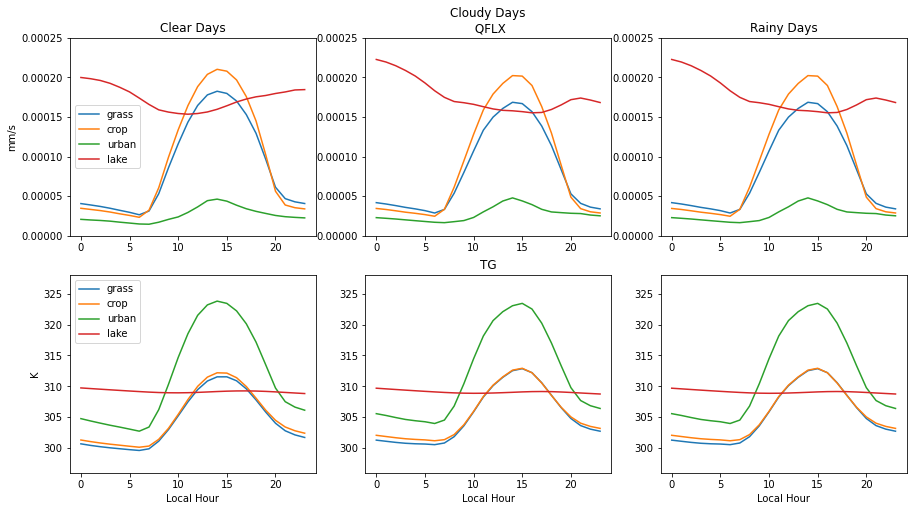

In [32]:
## What about making the plots? 

# ----- CLM plots ----- #
fig,axs = plt.subplots(2,3,figsize=(15,8))
axs     = axs.ravel()

for iLU in range(4):
    axs[0].plot(hourlyDSclm_h2_clear['hour'].values, hourlyDSclm_h2_clear.isel(case=0).isel(landunit=iLU).QFLX.values)
    axs[3].plot(hourlyDSclm_h2_clear['hour'].values, hourlyDSclm_h2_clear.isel(case=0).isel(landunit=iLU).TG.values)

    axs[1].plot(hourlyDSclm_h2_cloudy['hour'].values, hourlyDSclm_h2_cloudy.isel(case=0).isel(landunit=iLU).QFLX.values)
    axs[4].plot(hourlyDSclm_h2_cloudy['hour'].values, hourlyDSclm_h2_cloudy.isel(case=0).isel(landunit=iLU).TG.values)

    axs[2].plot(hourlyDSclm_h2_rainy['hour'].values, hourlyDSclm_h2_cloudy.isel(case=0).isel(landunit=iLU).QFLX.values)
    axs[5].plot(hourlyDSclm_h2_rainy['hour'].values, hourlyDSclm_h2_cloudy.isel(case=0).isel(landunit=iLU).TG.values)

axs[0].legend(['grass','crop','urban','lake'])   
axs[3].legend(['grass','crop','urban','lake'])   

axs[0].set_title('Clear Days') 
axs[1].set_title('Cloudy Days\n QFLX')
axs[2].set_title('Rainy Days')
axs[4].set_title('TG')

axs[0].set_ylim([0.0, 0.00025])
axs[1].set_ylim([0.0, 0.00025])
axs[2].set_ylim([0.0, 0.00025])
axs[3].set_ylim([296, 328])
axs[4].set_ylim([296, 328])
axs[5].set_ylim([296, 328])

axs[0].set_ylabel('mm/s')
axs[3].set_ylabel('K')

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')    
axs[5].set_xlabel('Local Hour')    
    

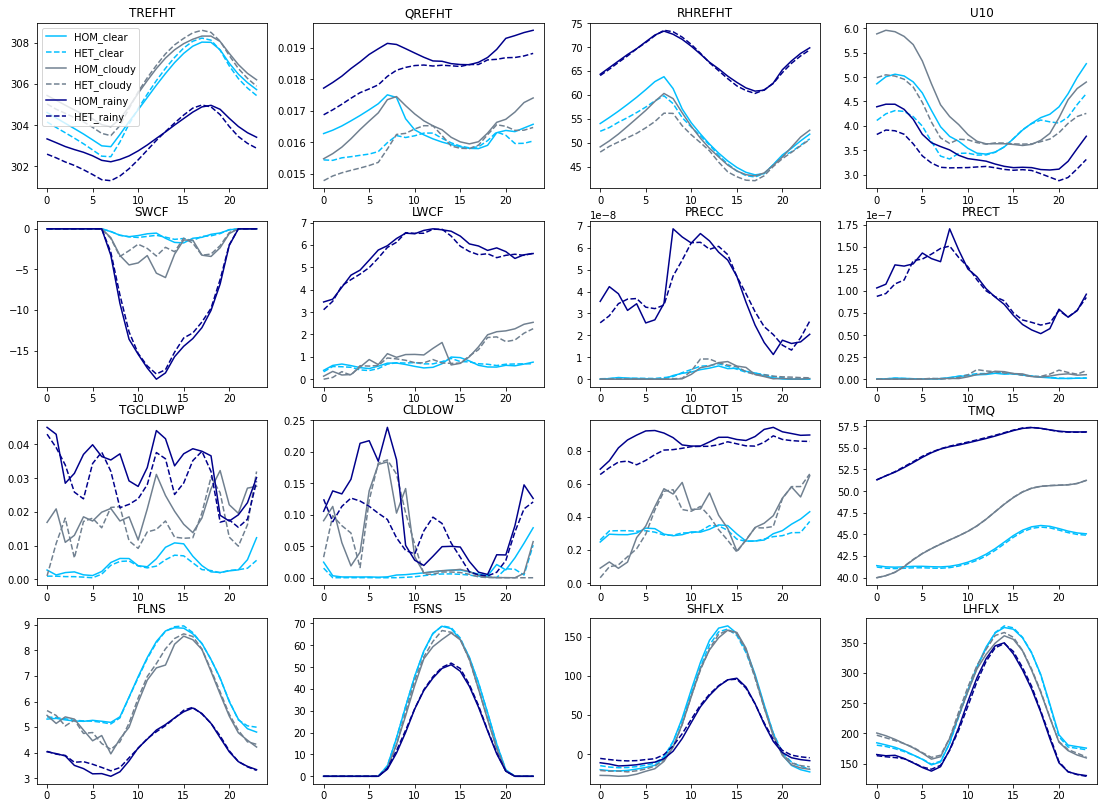

In [33]:
# ----- 2D CAM plots ----- #
pltVars = ['TREFHT','QREFHT','RHREFHT',
           'U10','SWCF','LWCF','PRECC',
           'PRECT','TGCLDLWP',
          'CLDLOW','CLDTOT','TMQ', 
          'FLNS','FSNS','SHFLX','LHFLX']  

fig,axs = plt.subplots(4,4, figsize=(19,14))
axs     = axs.ravel()

for iVar in range(len(pltVars)): 
    axs[iVar].plot(hourlyDS_clear['hour'].values, hourlyDS_clear[pltVars[iVar]].isel(case=0), 
                   color='deepskyblue', label='HOM_clear' )
    axs[iVar].plot(hourlyDS_clear['hour'].values, hourlyDS_clear[pltVars[iVar]].isel(case=1), 
                   '--', color='deepskyblue', label='HET_clear' )
    
    axs[iVar].plot(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy[pltVars[iVar]].isel(case=0), 
                   color='slategrey', label='HOM_cloudy' )
    axs[iVar].plot(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy[pltVars[iVar]].isel(case=1), 
                   '--', color='slategrey', label='HET_cloudy' )
        
    axs[iVar].plot(hourlyDS_rainy['hour'].values, hourlyDS_rainy[pltVars[iVar]].isel(case=0), 
                   color='darkblue', label='HOM_rainy' )
    axs[iVar].plot(hourlyDS_rainy['hour'].values, hourlyDS_rainy[pltVars[iVar]].isel(case=1), 
                   '--', color='darkblue', label='HET_rainy' )
    
    if pltVars[iVar]=='TREFHT':    
        axs[iVar].legend()
    axs[iVar].set_title(pltVars[iVar])


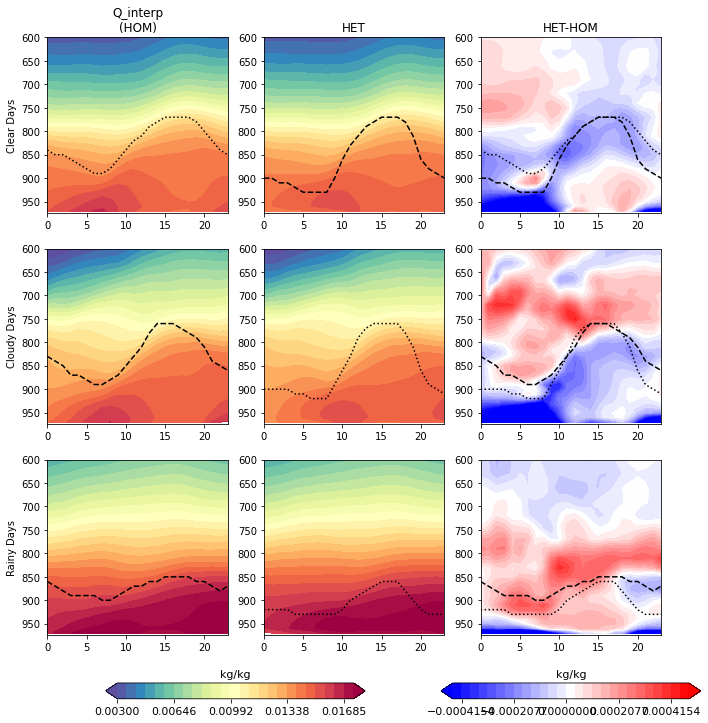

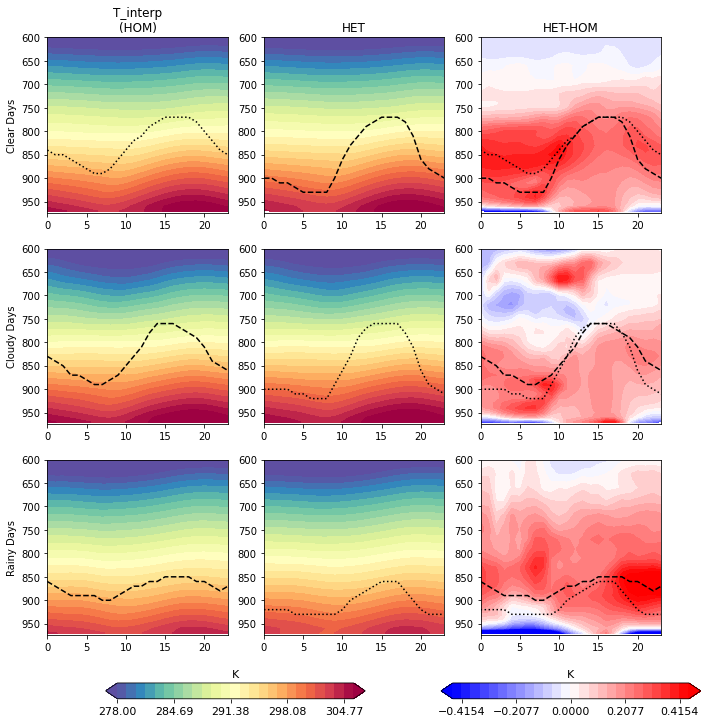

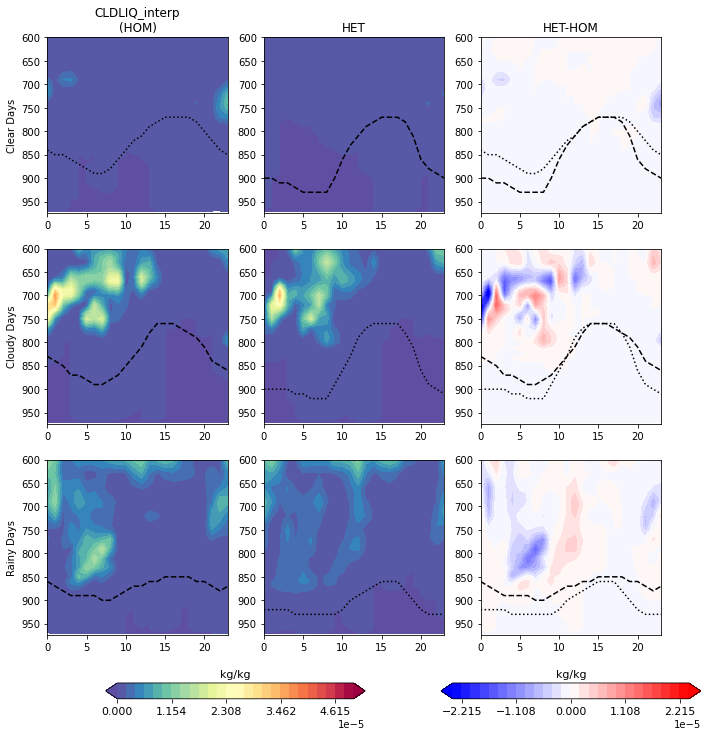

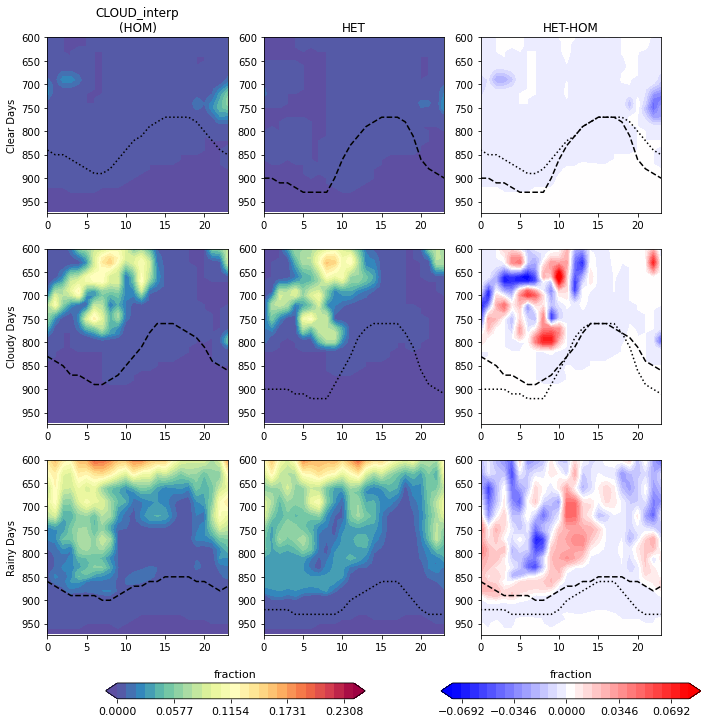

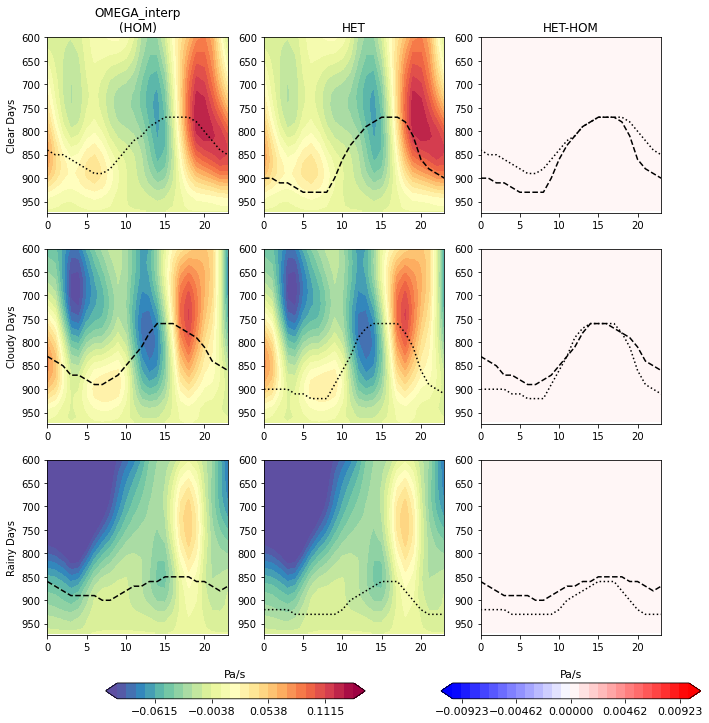

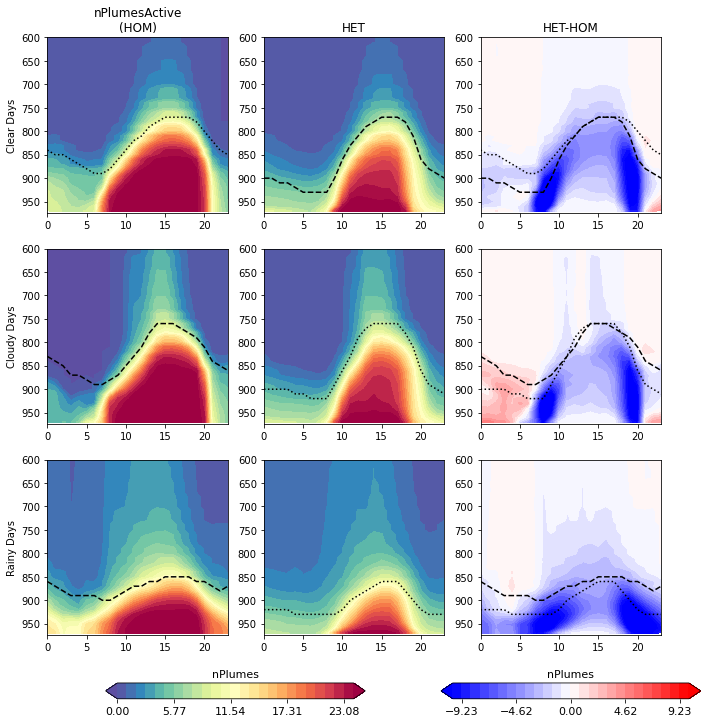

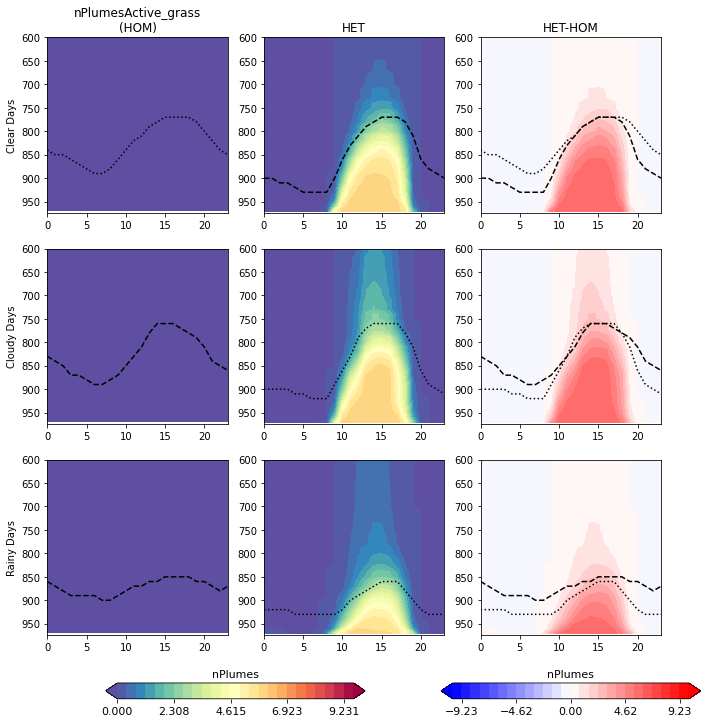

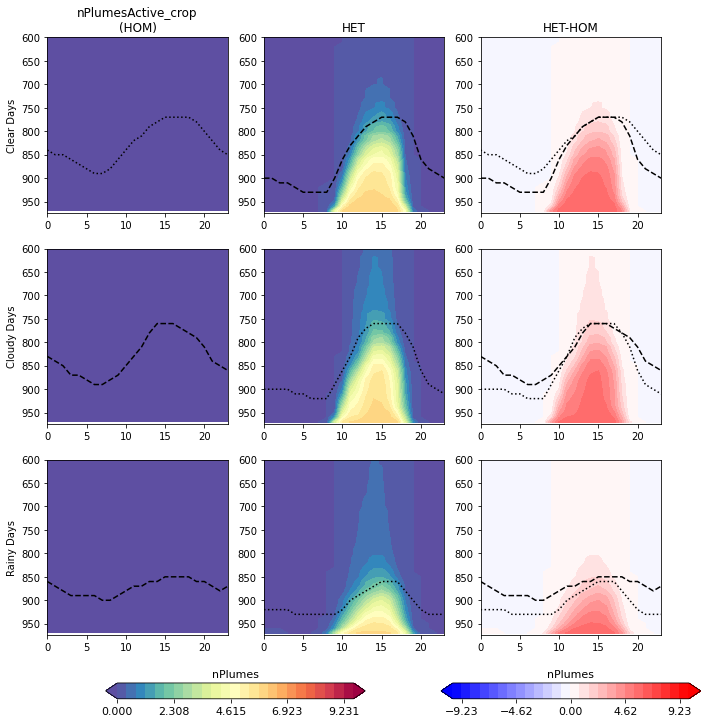

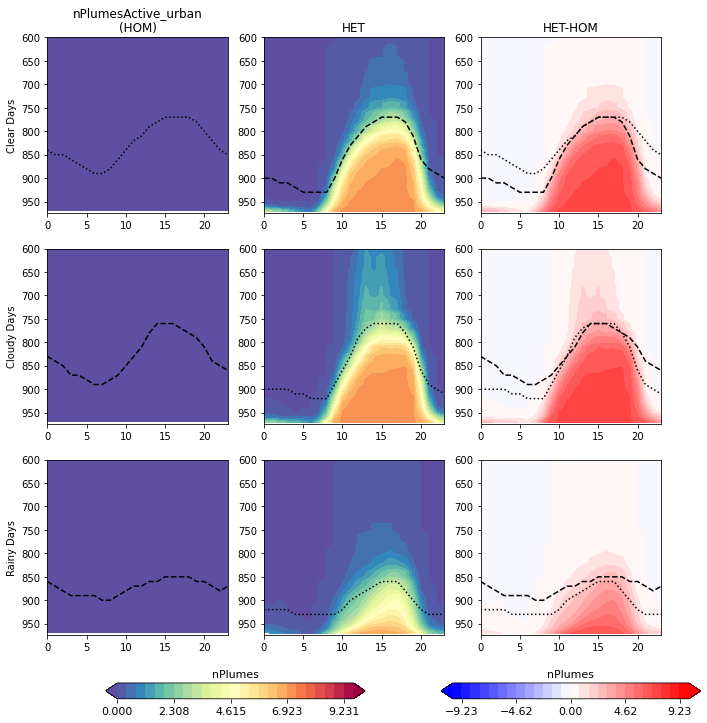

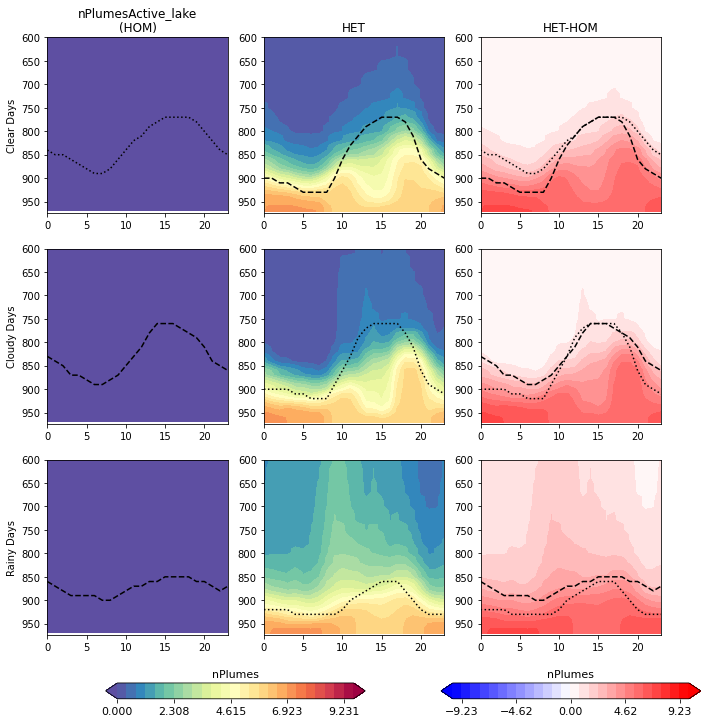

In [34]:
# ----- 3D CAM plots ----- #
pltVars = ['Q_interp','T_interp','CLDLIQ_interp','CLOUD_interp','OMEGA_interp','nPlumesActive',
          'nPlumesActive_grass','nPlumesActive_crop','nPlumesActive_urban','nPlumesActive_lake']

cMin    = [0.003,  278,    0.0,  0.0,     -0.1,    0,   0,  0,  0,  0]
cMax    = [0.018,  307,   5e-5,  0.25,   0.15,  25,  10, 10, 10, 10]
diffMax = [0.00045, 0.45,  2.4e-5, 0.075, 0.01,   10,  10, 10, 10, 10]
unitsStr = [DSuse['Q'].units,     DSuse['T'].units,      DSuse['CLDLIQ'].units, 
            DSuse['CLOUD'].units, DSuse['OMEGA'].units, 'nPlumes',
             'nPlumes',  'nPlumes',  'nPlumes',  'nPlumes']
maxLev  = 600.0

for iVar in range(len(pltVars)): 
    # - - - - - - - - - - - - - - - -  
#     ## Paired T-test for significance
#     # - - - - - - - - - - - - - - - -  
#     pVal_clear  = np.full([24, len(hourlyDS_clear.levInterp.values)], np.nan)
#     pVal_cloudy = np.full([24, len(hourlyDS_cloudy.levInterp.values)], np.nan)
#     pVal_rainy  = np.full([24, len(hourlyDS_crainy.levInterp.values)], np.nan)
#     for iHr in range(24): 
#         t,pDS1 = stats.ttest_rel(
#                                 DS1[varPlot].isel(case=0).where(DS1['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS1).mean(dim='nens'),
#                                 DS1[varPlot].isel(case=1).where(DS1['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS1).mean(dim='nens'),
#                                 nan_policy = 'omit')
#         iValDS1 = np.where(pDS1<0.05)[0]
#         pVal_DS1[iHr,iValDS1]=1
        
#         t,pDS2 = stats.ttest_rel(
#                                 DS2[varPlot].isel(case=0).where(DS2['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS2).mean(dim='nens'),
#                                 DS2[varPlot].isel(case=1).where(DS2['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS2).mean(dim='nens'),
#                                 nan_policy = 'omit')
#         iValDS2 = np.where(pDS2<0.05)[0]
#         pVal_DS2[iHr,iValDS2]=1
        
#         t,pDS3 = stats.ttest_rel(
#                                 DS3[varPlot].isel(case=0).where(DS3['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsDS2).mean(dim='nens'),
#                                 DS3[varPlot].isel(case=1).where(DS3['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsDS2).mean(dim='nens'),
#                                 nan_policy = 'omit')
#         iValDS3 = np.where(pDS3<0.05)[0]
#         pVal_DS3[iHr,iValDS3]=1
   
    
    
    fig,axs = plt.subplots(3,3,figsize=(11,11))
    axs     = axs.ravel()

    ## Clear Days 
    axs[0].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       np.squeeze(hourlyDS_clear[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[1].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       np.squeeze(hourlyDS_clear[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_clear[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_clear[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[2].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')

    ## Cloudy Days 
    axs[3].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       np.squeeze(hourlyDS_cloudy[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[4].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       np.squeeze(hourlyDS_cloudy[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_cloudy[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_cloudy[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[5].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    
    ## Rainy Days 
    axs[6].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                       np.squeeze(hourlyDS_rainy[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    cplt = axs[7].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                       np.squeeze(hourlyDS_rainy[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    # cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal', format='%.1e')
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    
    diffVar = np.squeeze(hourlyDS_rainy[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_rainy[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[8].contourf(hourlyDS_rainy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    # Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    # cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal', format='%.1e')
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    axs[0].set_title(pltVars[iVar]+'\n(HOM)')
    axs[1].set_title('HET')
    axs[2].set_title('HET-HOM')

    axs[0].set_ylabel('Clear Days')
    axs[3].set_ylabel('Cloudy Days')
    axs[6].set_ylabel('Rainy Days') 
    
    ## Add PBLH???
    axs[0].plot(hourlyDS_clear.hour.values, veryRoughPBLH_clear[0,:],'k:')
    axs[1].plot(hourlyDS_clear.hour.values, veryRoughPBLH_clear[1,:],'k--')
    axs[2].plot(hourlyDS_clear.hour.values, veryRoughPBLH_clear[0,:],'k:')
    axs[2].plot(hourlyDS_clear.hour.values, veryRoughPBLH_clear[1,:],'k--')
    axs[3].plot(hourlyDS_cloudy.hour.values, veryRoughPBLH_cloudy[0,:],'k--')
    axs[4].plot(hourlyDS_cloudy.hour.values, veryRoughPBLH_cloudy[1,:],'k:')
    axs[5].plot(hourlyDS_cloudy.hour.values, veryRoughPBLH_cloudy[0,:],'k--')
    axs[5].plot(hourlyDS_cloudy.hour.values, veryRoughPBLH_cloudy[1,:],'k:')
    axs[6].plot(hourlyDS_rainy.hour.values, veryRoughPBLH_rainy[0,:],'k--')
    axs[7].plot(hourlyDS_rainy.hour.values, veryRoughPBLH_rainy[1,:],'k:')
    axs[8].plot(hourlyDS_rainy.hour.values, veryRoughPBLH_rainy[0,:],'k--')
    axs[8].plot(hourlyDS_rainy.hour.values, veryRoughPBLH_rainy[1,:],'k:')
    

    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([975,maxLev])
    axs[1].set_ylim([975,maxLev])
    axs[2].set_ylim([975,maxLev])
    axs[3].set_ylim([975,maxLev])
    axs[4].set_ylim([975,maxLev])
    axs[5].set_ylim([975,maxLev])
    axs[6].set_ylim([975,maxLev])
    axs[7].set_ylim([975,maxLev])
    axs[8].set_ylim([975,maxLev])


(975.0, 600.0)

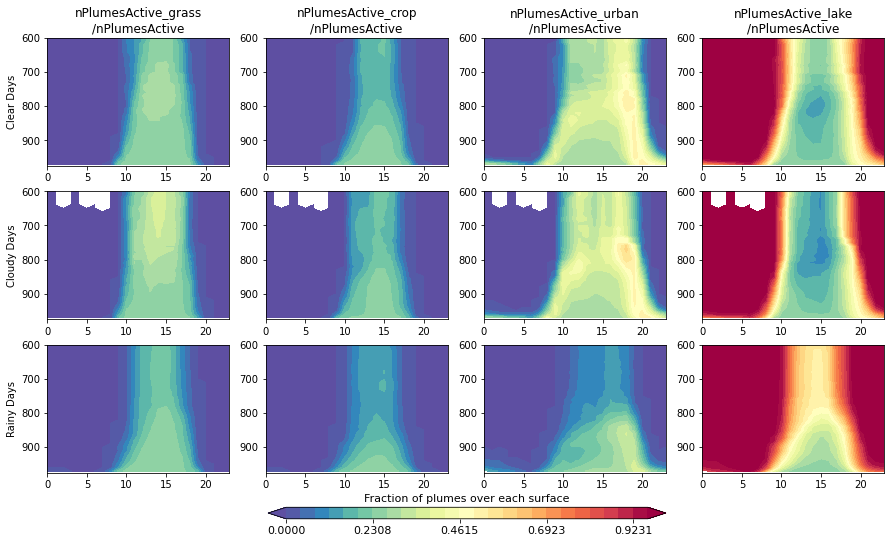

In [35]:
fig,axs = plt.subplots(3,4, figsize=(15,8))
axs     = axs.ravel()

maxLev  = 600.0


# for iHr in range(len(hourlyDS_clear.hour.values)): 
#     fillGrid = 0
#     for iLev in range(len(hourlyDS_clear.levInterp.values)): 
#         numGrass = hourlyDS_clear.isel(case=1).nPlumesActive_grass.isel(hour=iHr, levInterp=iLev)
#         numCrop  = hourlyDS_clear.isel(case=1).nPlumesActive_crop.isel(hour=iHr, levInterp=iLev)
#         numUrban = hourlyDS_clear.isel(case=1).nPlumesActive_urban.isel(hour=iHr, levInterp=iLev)
#         numLake  = hourlyDS_clear.isel(case=1).nPlumesActive_lake.isel(hour=iHr, levInterp=iLev)


## Clear Days 
axs[0].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_grass'].isel(case=1)).transpose()/np.squeeze(hourlyDS_clear['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[1].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_crop'].isel(case=1)).transpose()/np.squeeze(hourlyDS_clear['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[2].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_urban'].isel(case=1)).transpose()/np.squeeze(hourlyDS_clear['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[3].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_lake'].isel(case=1)).transpose()/np.squeeze(hourlyDS_clear['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')

## Cloudy Days 
axs[4].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_grass'].isel(case=1)).transpose()/np.squeeze(hourlyDS_cloudy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[5].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_crop'].isel(case=1)).transpose()/np.squeeze(hourlyDS_cloudy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[6].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_urban'].isel(case=1)).transpose()/np.squeeze(hourlyDS_cloudy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[7].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_lake'].isel(case=1)).transpose()/np.squeeze(hourlyDS_cloudy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')


## Rainy Days 
axs[8].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_grass'].isel(case=1)).transpose()/np.squeeze(hourlyDS_rainy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
axs[9].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_crop'].isel(case=1)).transpose()/np.squeeze(hourlyDS_rainy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
cplt = axs[10].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_urban'].isel(case=1)).transpose()/np.squeeze(hourlyDS_rainy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
ax_position = axs[10].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.02])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title('Fraction of plumes over each surface', fontsize=11)
cbar.ax.tick_params(labelsize=11) 

axs[11].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_lake'].isel(case=1)).transpose()/np.squeeze(hourlyDS_rainy['nPlumesActive'].isel(case=1)).transpose(),
                   np.arange(0, 1, 1/26), 
                   cmap='Spectral_r', extend='both')



axs[0].set_ylabel('Clear Days')
axs[4].set_ylabel('Cloudy Days')
axs[8].set_ylabel('Rainy Days') 

axs[0].set_title('nPlumesActive_grass\n/nPlumesActive')
axs[1].set_title('nPlumesActive_crop\n/nPlumesActive')
axs[2].set_title('nPlumesActive_urban\n/nPlumesActive')
axs[3].set_title('nPlumesActive_lake\n/nPlumesActive')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()
axs[9].invert_yaxis()
axs[10].invert_yaxis()
axs[11].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])
axs[9].set_ylim([975,maxLev])
axs[10].set_ylim([975,maxLev])
axs[11].set_ylim([975,maxLev])
    
    

(975.0, 600.0)

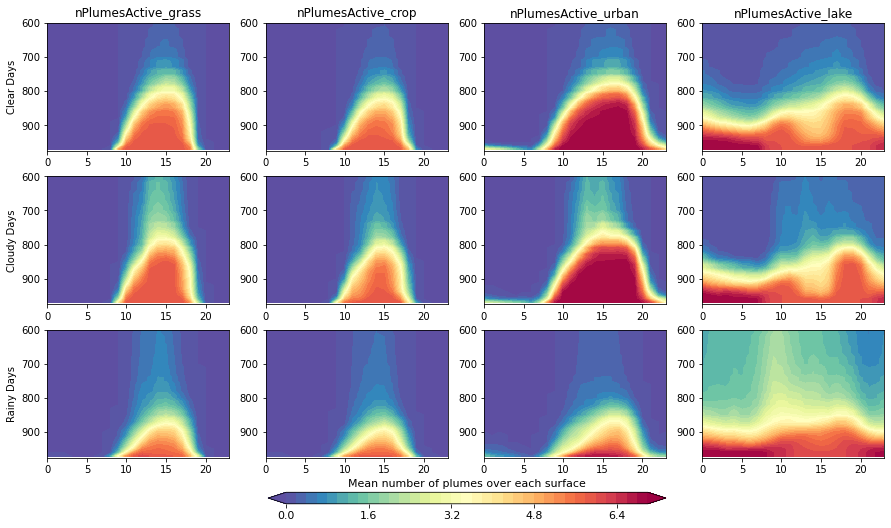

In [36]:
fig,axs = plt.subplots(3,4, figsize=(15,8))
axs     = axs.ravel()

maxLev  = 600.0


# for iHr in range(len(hourlyDS_clear.hour.values)): 
#     fillGrid = 0
#     for iLev in range(len(hourlyDS_clear.levInterp.values)): 
#         numGrass = hourlyDS_clear.isel(case=1).nPlumesActive_grass.isel(hour=iHr, levInterp=iLev)
#         numCrop  = hourlyDS_clear.isel(case=1).nPlumesActive_crop.isel(hour=iHr, levInterp=iLev)
#         numUrban = hourlyDS_clear.isel(case=1).nPlumesActive_urban.isel(hour=iHr, levInterp=iLev)
#         numLake  = hourlyDS_clear.isel(case=1).nPlumesActive_lake.isel(hour=iHr, levInterp=iLev)


## Clear Days 
axs[0].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_grass'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[1].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_crop'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[2].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_urban'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[3].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                   np.squeeze(hourlyDS_clear['nPlumesActive_lake'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')

## Cloudy Days 
axs[4].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_grass'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[5].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_crop'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[6].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_urban'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[7].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                   np.squeeze(hourlyDS_cloudy['nPlumesActive_lake'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')


## Rainy Days 
axs[8].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_grass'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
axs[9].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_crop'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
cplt = axs[10].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_urban'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')
# Add colorbar
ax_position = axs[10].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.2, 0.02])
cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
cbar.ax.locator_params(nbins=6)
cbar.ax.set_title('Mean number of plumes over each surface', fontsize=11)
cbar.ax.tick_params(labelsize=11) 

axs[11].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                   np.squeeze(hourlyDS_rainy['nPlumesActive_lake'].isel(case=1)).transpose(),
                   np.arange(0, 7.2, 0.2), 
                   cmap='Spectral_r', extend='both')



axs[0].set_ylabel('Clear Days')
axs[4].set_ylabel('Cloudy Days')
axs[8].set_ylabel('Rainy Days') 

axs[0].set_title('nPlumesActive_grass')
axs[1].set_title('nPlumesActive_crop')
axs[2].set_title('nPlumesActive_urban')
axs[3].set_title('nPlumesActive_lake')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()
axs[9].invert_yaxis()
axs[10].invert_yaxis()
axs[11].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])
axs[9].set_ylim([975,maxLev])
axs[10].set_ylim([975,maxLev])
axs[11].set_ylim([975,maxLev])
    
    

In [37]:
wgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_clear_wgted = clearDays_DS_h2.resample(time='1H').mean(dim='time').weighted(wgts_clear).mean(dim='nens').groupby('time.hour').mean(dim='time')

wgts_cloudy = cloudyDays_DS_h2.upa_macmicAvg_interp.resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_cloudy_wgted = cloudyDays_DS_h2.resample(time='1H').mean(dim='time').weighted(wgts_cloudy).mean(dim='nens').groupby('time.hour').mean(dim='time')

wgts_rainy = rainyDays_DS_h2.upa_macmicAvg_interp.resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_rainy_wgted = rainyDays_DS_h2.resample(time='1H').mean(dim='time').weighted(wgts_rainy).mean(dim='nens').groupby('time.hour').mean(dim='time')


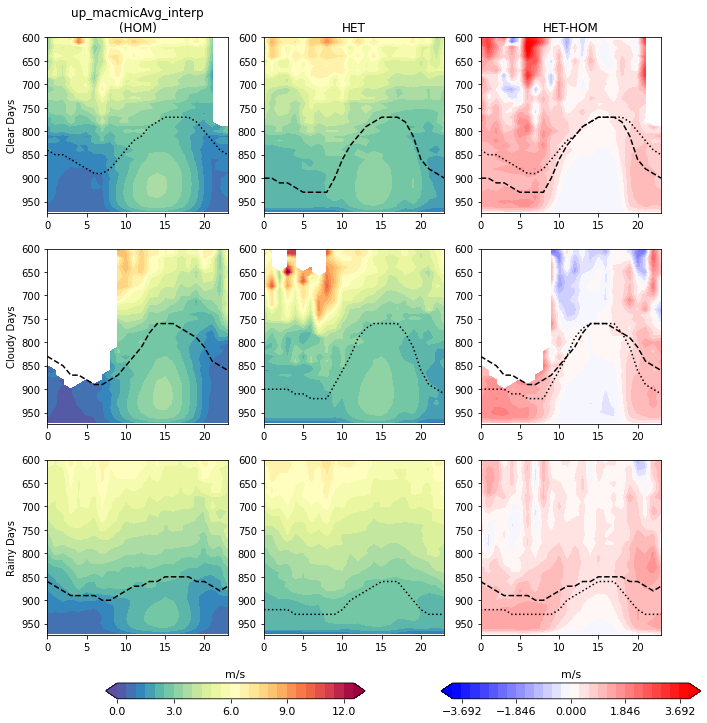

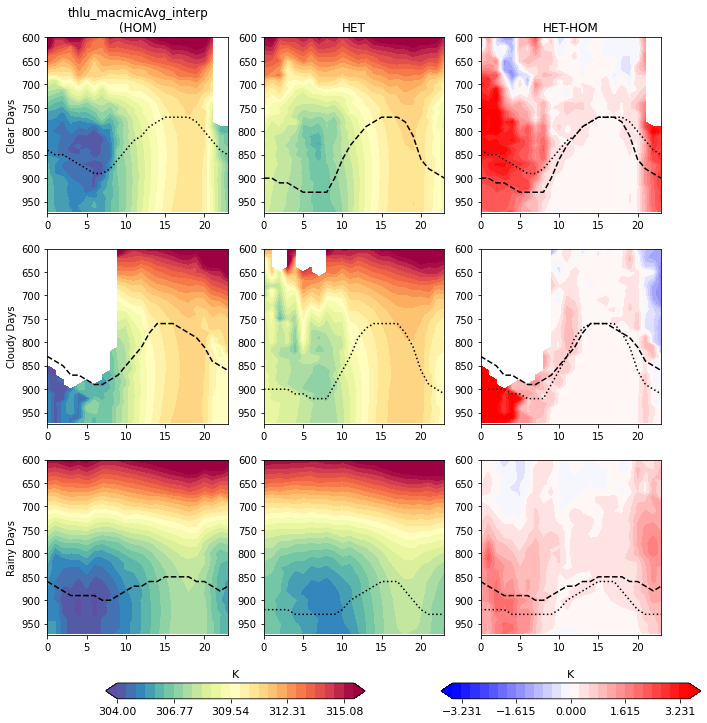

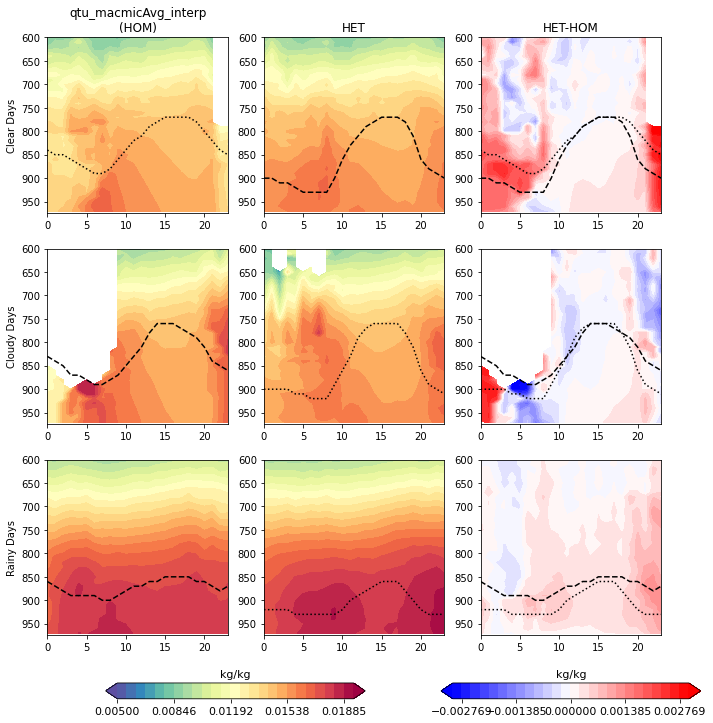

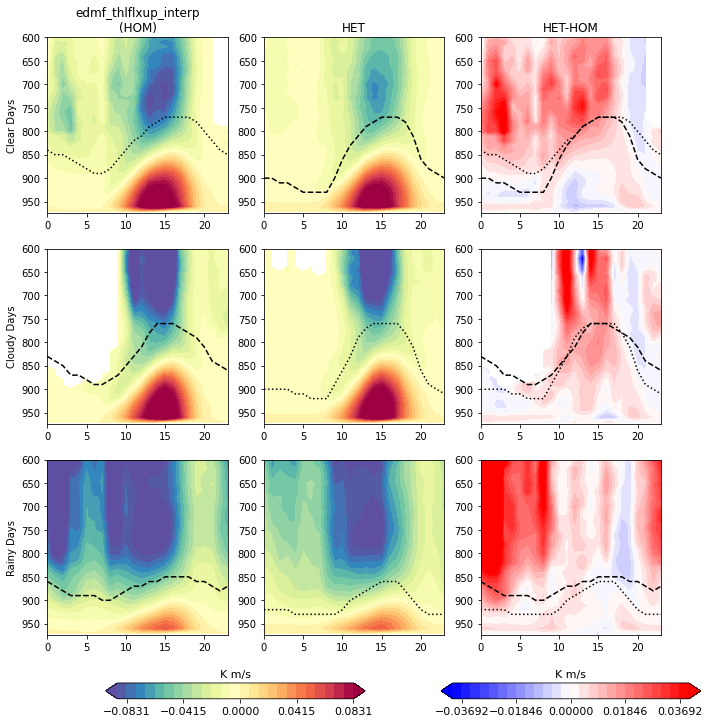

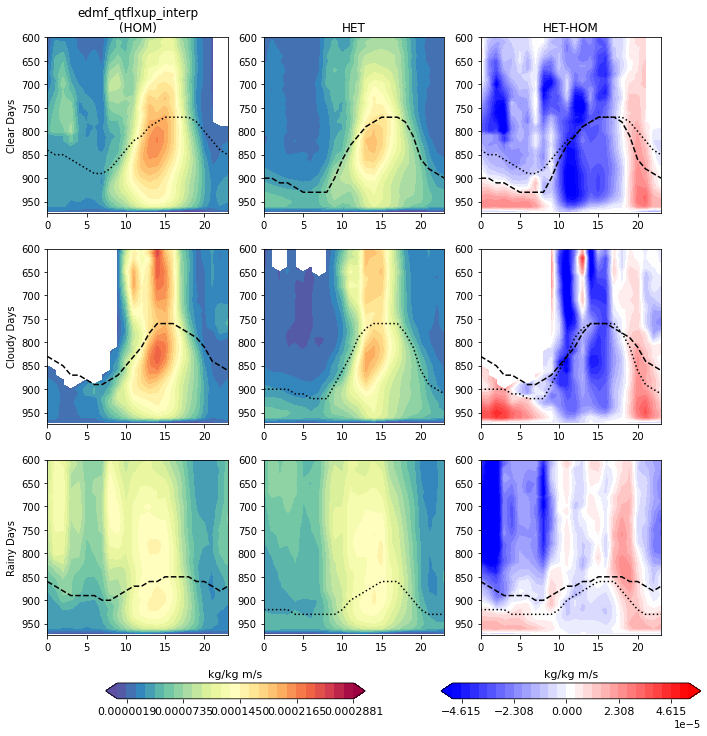

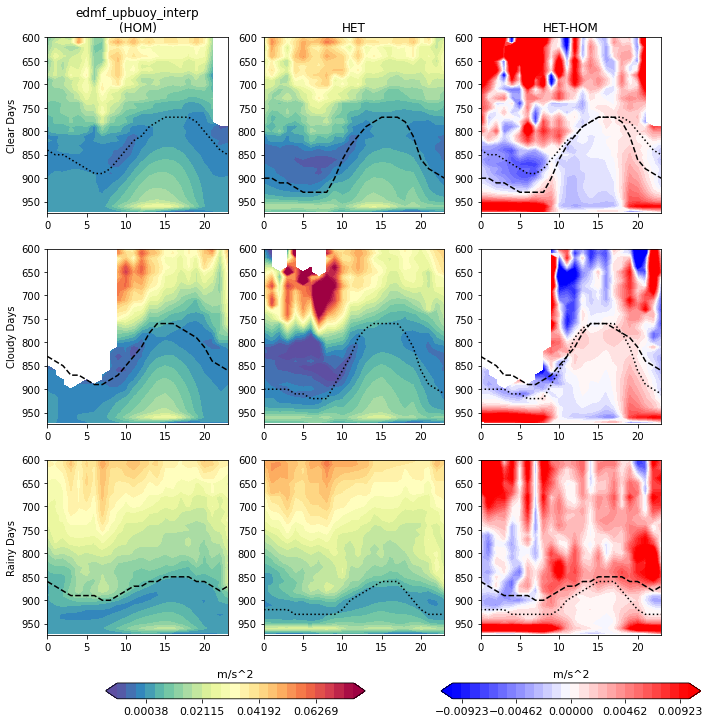

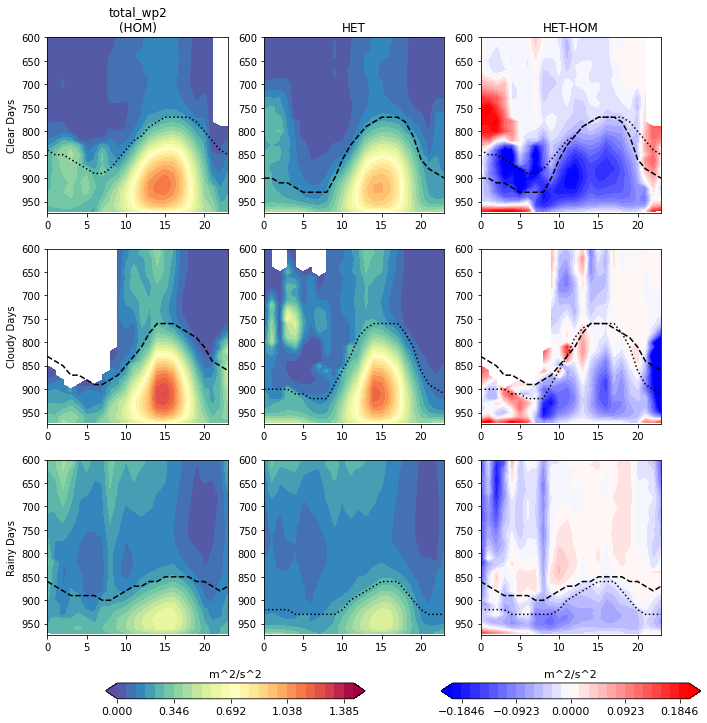

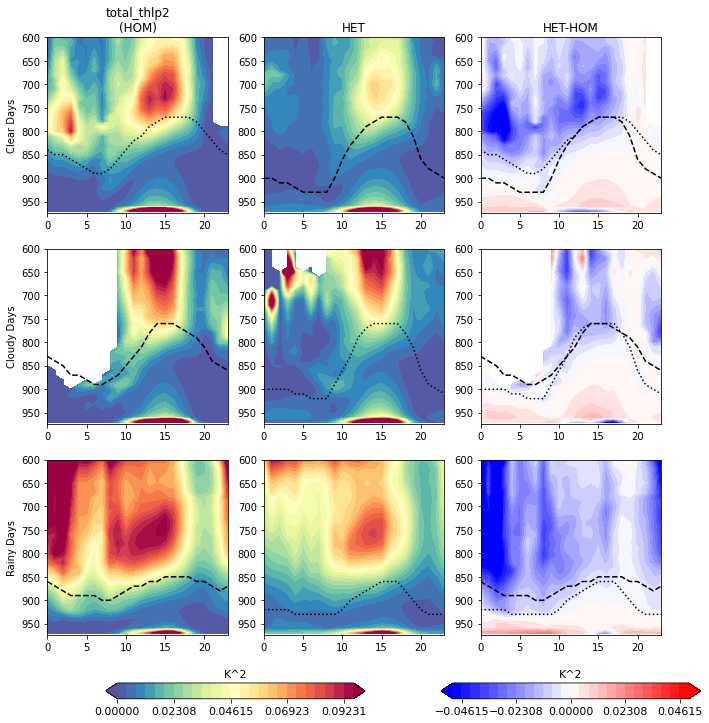

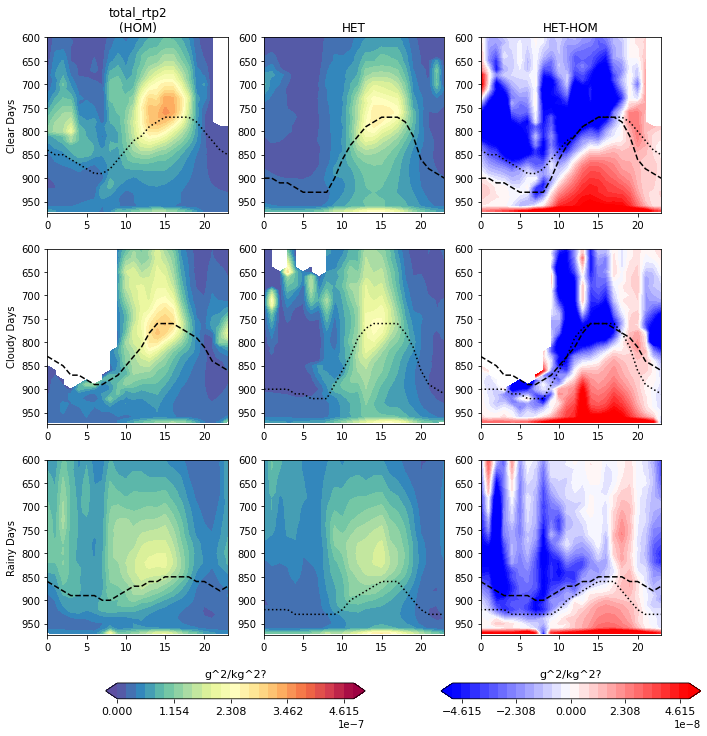

In [38]:
# ----- 3D CAM plots ----- #
pltVars = ['up_macmicAvg_interp','thlu_macmicAvg_interp','qtu_macmicAvg_interp',
           'edmf_thlflxup_interp','edmf_qtflxup_interp','edmf_upbuoy_interp',
           'total_wp2','total_thlp2','total_rtp2',
           # 'total_wpthlp','total_wprtp',
          ]

cMin    = [0,    304,     5e-3,   -0.09,     -1e-5,     -0.01,    0.0,     0.0,    0.0,     -0.02]
cMax    = [13,    316,     0.02,    0.09,      3e-4,      0.08,    1.5,     0.1,   5e-7,      0.02]
diffMax = [4,    3.5,    0.003,    0.04,      5e-5,      0.01,    0.2,    0.05,   5e-8,     0.005]
unitsStr = ['m/s', 'K', 'kg/kg', 'K m/s', 'kg/kg m/s', 'm/s^2', 'm^2/s^2', 'K^2', 'g^2/kg^2?', '']
maxLev  = 600.0

for iVar in range(len(pltVars)): 
    fig,axs = plt.subplots(3,3,figsize=(11,11))
    axs     = axs.ravel()

    ## Clear Days 
    axs[0].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[1].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[2].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')

    ## Cloudy Days 
    axs[3].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[4].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[5].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    
    ## Rainy Days 
    axs[6].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].isel(case=0)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    cplt = axs[7].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].isel(case=1)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    
    diffVar = np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].isel(case=1)) - np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].isel(case=0))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[8].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    # Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    ## Add PBLH???
    axs[0].plot(hourlyDS_h2_clear_wgted.hour.values, veryRoughPBLH_clear[0,:],'k:')
    axs[1].plot(hourlyDS_h2_clear_wgted.hour.values, veryRoughPBLH_clear[1,:],'k--')
    axs[2].plot(hourlyDS_h2_clear_wgted.hour.values, veryRoughPBLH_clear[0,:],'k:')
    axs[2].plot(hourlyDS_h2_clear_wgted.hour.values, veryRoughPBLH_clear[1,:],'k--')
    axs[3].plot(hourlyDS_h2_cloudy_wgted.hour.values, veryRoughPBLH_cloudy[0,:],'k--')
    axs[4].plot(hourlyDS_h2_cloudy_wgted.hour.values, veryRoughPBLH_cloudy[1,:],'k:')
    axs[5].plot(hourlyDS_h2_cloudy_wgted.hour.values, veryRoughPBLH_cloudy[0,:],'k--')
    axs[5].plot(hourlyDS_h2_cloudy_wgted.hour.values, veryRoughPBLH_cloudy[1,:],'k:')
    axs[6].plot(hourlyDS_h2_rainy_wgted.hour.values, veryRoughPBLH_rainy[0,:],'k--')
    axs[7].plot(hourlyDS_h2_rainy_wgted.hour.values, veryRoughPBLH_rainy[1,:],'k:')
    axs[8].plot(hourlyDS_h2_rainy_wgted.hour.values, veryRoughPBLH_rainy[0,:],'k--')
    axs[8].plot(hourlyDS_h2_rainy_wgted.hour.values, veryRoughPBLH_rainy[1,:],'k:')
    

    axs[0].set_title(pltVars[iVar]+'\n(HOM)')
    axs[1].set_title('HET')
    axs[2].set_title('HET-HOM')

    axs[0].set_ylabel('Clear Days')
    axs[3].set_ylabel('Cloudy Days')
    axs[6].set_ylabel('Rainy Days') 
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([975,maxLev])
    axs[1].set_ylim([975,maxLev])
    axs[2].set_ylim([975,maxLev])
    axs[3].set_ylim([975,maxLev])
    axs[4].set_ylim([975,maxLev])
    axs[5].set_ylim([975,maxLev])
    axs[6].set_ylim([975,maxLev])
    axs[7].set_ylim([975,maxLev])
    axs[8].set_ylim([975,maxLev])


## Test digging into one day

**Extra test case**

In [9]:
dataDir  = '/glade/scratch/mdfowler/temp/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataTRUE_setSfcFlxTRUE_25UrbanLakeGrassIrrCrop_Lopt6pp_nup25_LUbased_addNewTermStarVals.LASSO_20150628.'

shortName = 'Lopt6pp_newTerm_CLASP'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(dataDir+caseName+'*cam.h0.2015*'))
listFiles_h1 = np.sort(glob.glob(dataDir+caseName+'*cam.h1.2015*'))
listFiles_h2 = np.sort(glob.glob(dataDir+caseName+'*cam.h2.2015*'))
listFiles_h3 = np.sort(glob.glob(dataDir+caseName+'*cam.h3.2015*'))

case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')
case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h1 files loaded')

case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h2 files loaded with mfdataset')
case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h2 2D data loaded with mfdataset')

case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h3 files loaded with mfdataset')

# Merge cases and load
caseFull = xr.merge([case_h1, case_h0])
# caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
case_h0.close()
case_h1.close()

caseH2   = xr.merge([case_h2, case_h2_2d])
caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
case_h2.close()
case_h2_2d.close()

caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
case_h3.close()

del case_h0,case_h1,case_h2,case_h2_2d,case_h3
# del case_h0,case_h1,case_h2,case_h2_2d

print('DS merged and loaded')

## Process data 
procDS    = process_camData( caseFull )
del caseFull
procDS_h2 = process_camData_h2( caseH2, procDS  )
del caseH2

procDS_h3_combine = combineMacmic_beforeInterp(caseH3)
del caseH3
procDS_h3 = process_camData_h3( procDS_h3_combine, procDS  )
del procDS_h3_combine

procDS_h2 = xr.merge([procDS_h2, procDS_h3])
# procDS_h2 = combineMacmic(procDS_h3, procDS_h2)
del procDS_h3

## Combine all the cases into 
case_allDays      = procDS.squeeze().assign_coords({"case":  shortName})
h2_allDays        = procDS_h2.squeeze().assign_coords({"case":  shortName})
# h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
del procDS_h2, procDS

## Drop excessive variables to save space
h2_allDays = h2_allDays.drop_vars(['ntrk','ntrn','ntrm','gw','hyam','hybm',                                  
                             'P0','hyai','hybi','date','datesec','time_bnds','date_written',
                             'time_written','ndbase','nsbase','nbdate','nbsec','mdt','ndcur',
                             'nscur','co2vmr','ch4vmr','n2ovmr','f11vmr','f12vmr','sol_tsi','nsteph',
                              ## Also remove downdraft data (not active here)
                             'qtd_macmicAvg_interp','thld_macmicAvg_interp','dna_macmicAvg_interp',
                              'dn_macmicAvg_interp','qtd_macmicAvg','thld_macmicAvg','dna_macmicAvg',
                              'dn_macmicAvg','upa_macmic2','upa_macmic1','edmf_dnw_interp',
                              ## Also drop macmicAvg if not interpolated 
                              'up_macmicAvg','upa_macmicAvg','thlu_macmicAvg','qtu_macmicAvg',
                              ## Riskier - but drop the things that are just the last time-step
                              # 'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                                    ])
    



h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...


In [24]:
tot_wp2 = h2_allDays.edmf_S_AWW_interp.values + case_allDays.WP2_CLUBB_interp.values
h2_allDays['total_wp2']  = (('time','levInterp'), tot_wp2)

tot_thlp2 = h2_allDays.edmf_S_ATHLTHL_interp.values + case_allDays.THLP2_CLUBB_interp.values
h2_allDays['total_thlp2']  = (('time','levInterp'), tot_thlp2)

tot_rtp2 = h2_allDays.edmf_S_AQTQT_interp.values + (1e-6 * case_allDays.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
h2_allDays['total_rtp2']  = (('time','levInterp'), tot_rtp2)

tot_wpthlp = h2_allDays.edmf_thlflxup_interp.values + (case_allDays.wpthlp_interp.values)
h2_allDays['total_wpthlp']  = (('time','levInterp'), tot_wpthlp)

tot_wprtp = h2_allDays.edmf_qtflxup_interp.values + (case_allDays.wprtp_interp.values)
h2_allDays['total_wprtp']  = (('time','levInterp'), tot_wprtp)



In [32]:
dataDir  = '/glade/scratch/mdfowler/temp/'
caseName = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_setSfcFlxTRUE_25UrbanLakeGrassIrrCrop_Lopt6pp_nup25_LUbased_addNewTermStarVals.LASSO_20150628.'

shortName = 'Lopt6pp_newTerm_CTRL'

## Get list of files 
listFiles_h0 = np.sort(glob.glob(dataDir+caseName+'*cam.h0.2015*'))
listFiles_h1 = np.sort(glob.glob(dataDir+caseName+'*cam.h1.2015*'))
listFiles_h2 = np.sort(glob.glob(dataDir+caseName+'*cam.h2.2015*'))
listFiles_h3 = np.sort(glob.glob(dataDir+caseName+'*cam.h3.2015*'))

case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h0 files loaded')
case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h1 files loaded')

case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h2 files loaded with mfdataset')
case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h2 2D data loaded with mfdataset')

case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                            combine='nested', decode_times=False, 
                            data_vars='minimal')
print('h3 files loaded with mfdataset')

# Merge cases and load
caseFull = xr.merge([case_h1, case_h0])
# caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
case_h0.close()
case_h1.close()

caseH2   = xr.merge([case_h2, case_h2_2d])
caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
case_h2.close()
case_h2_2d.close()

caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
case_h3.close()

del case_h0,case_h1,case_h2,case_h2_2d,case_h3
# del case_h0,case_h1,case_h2,case_h2_2d

print('DS merged and loaded')

## Process data 
procDS    = process_camData( caseFull )
del caseFull
procDS_h2 = process_camData_h2( caseH2, procDS  )
del caseH2

procDS_h3_combine = combineMacmic_beforeInterp(caseH3)
del caseH3
procDS_h3 = process_camData_h3( procDS_h3_combine, procDS  )
del procDS_h3_combine

procDS_h2 = xr.merge([procDS_h2, procDS_h3])
# procDS_h2 = combineMacmic(procDS_h3, procDS_h2)
del procDS_h3

## Combine all the cases into 
case_allDays_ctrl      = procDS.squeeze().assign_coords({"case":  shortName})
h2_allDays_ctrl        = procDS_h2.squeeze().assign_coords({"case":  shortName})
# h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
del procDS_h2, procDS

## Drop excessive variables to save space
h2_allDays_ctrl = h2_allDays_ctrl.drop_vars(['ntrk','ntrn','ntrm','gw','hyam','hybm',                                  
                             'P0','hyai','hybi','date','datesec','time_bnds','date_written',
                             'time_written','ndbase','nsbase','nbdate','nbsec','mdt','ndcur',
                             'nscur','co2vmr','ch4vmr','n2ovmr','f11vmr','f12vmr','sol_tsi','nsteph',
                              ## Also remove downdraft data (not active here)
                             'qtd_macmicAvg_interp','thld_macmicAvg_interp','dna_macmicAvg_interp',
                              'dn_macmicAvg_interp','qtd_macmicAvg','thld_macmicAvg','dna_macmicAvg',
                              'dn_macmicAvg','upa_macmic2','upa_macmic1','edmf_dnw_interp',
                              ## Also drop macmicAvg if not interpolated 
                              'up_macmicAvg','upa_macmicAvg','thlu_macmicAvg','qtu_macmicAvg',
                              ## Riskier - but drop the things that are just the last time-step
                              # 'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                                    ])
    



h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...


In [33]:
tot_wp2 = h2_allDays_ctrl.edmf_S_AWW_interp.values + case_allDays_ctrl.WP2_CLUBB_interp.values
h2_allDays_ctrl['total_wp2']  = (('time','levInterp'), tot_wp2)

tot_thlp2 = h2_allDays_ctrl.edmf_S_ATHLTHL_interp.values + case_allDays_ctrl.THLP2_CLUBB_interp.values
h2_allDays_ctrl['total_thlp2']  = (('time','levInterp'), tot_thlp2)

tot_rtp2 = h2_allDays_ctrl.edmf_S_AQTQT_interp.values + (1e-6 * case_allDays_ctrl.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
h2_allDays_ctrl['total_rtp2']  = (('time','levInterp'), tot_rtp2)

tot_wpthlp = h2_allDays_ctrl.edmf_thlflxup_interp.values + (case_allDays_ctrl.wpthlp_interp.values)
h2_allDays_ctrl['total_wpthlp']  = (('time','levInterp'), tot_wpthlp)

tot_wprtp = h2_allDays_ctrl.edmf_qtflxup_interp.values + (case_allDays_ctrl.wprtp_interp.values)
h2_allDays_ctrl['total_wprtp']  = (('time','levInterp'), tot_wprtp)



**Isolate the one day**

In [16]:
selYear = 2015
selMon  = 6
selDay  = 29

iTime_addTerm = np.where((scamDS_addTerm['time.year'].values==selYear) & 
                         (scamDS_addTerm['time.month'].values==selMon) & 
                         (scamDS_addTerm['time.day'].values==selDay) )[0]

scamDS_addTerm_thisDay    = scamDS_addTerm.isel(time=iTime_addTerm)
scamDS_h2_addTerm_thisDay = scamDS_h2_addTerm.isel(time=iTime_addTerm)


iTime = np.where((scamDS['time.year'].values==selYear) & 
                 (scamDS['time.month'].values==selMon) & 
                 (scamDS['time.day'].values==selDay) )[0]

scamDS_thisDay    = scamDS.isel(time=iTime)
scamDS_h2_thisDay = scamDS_h2.isel(time=iTime)


In [34]:
diurnalDay_h2_addTerm = scamDS_h2_addTerm_thisDay.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnalDay_h2         = scamDS_h2_thisDay.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h2_Lopt6pp    = h2_allDays.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diurnal_h2_Lopt6pp_ctrl = h2_allDays_ctrl.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


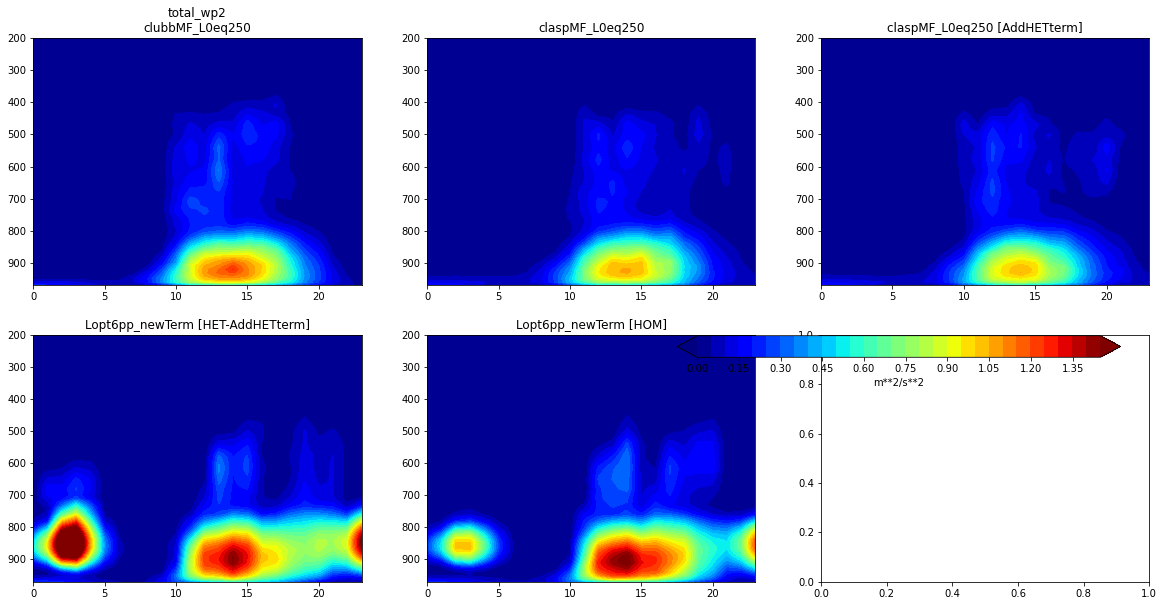

In [36]:
# varPlot = 'total_thlp2'
# unitsStr = 'K**2'
# clims = np.arange(0,0.1,0.005)

varPlot = 'total_wp2'
unitsStr = 'm**2/s**2'
clims = np.arange(0,1.5,0.05)

fig,axs = plt.subplots(2,3, figsize=(20,10))
axs     = axs.ravel()

axs[0].contourf(diurnalDay_h2.hour.values, diurnalDay_h2.levInterp.values, diurnalDay_h2[varPlot].isel(case=0).transpose().values, clims, cmap = 'jet', extend='both')
axs[1].contourf(diurnalDay_h2.hour.values, diurnalDay_h2.levInterp.values, diurnalDay_h2[varPlot].isel(case=1).transpose().values, clims, cmap = 'jet', extend='both')
cplt = axs[2].contourf(diurnalDay_h2_addTerm.hour.values, diurnalDay_h2_addTerm.levInterp.values, diurnalDay_h2_addTerm[varPlot].isel(case=1).transpose().values, clims, cmap = 'jet', extend='both')
#Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.1, ax_position.width+0.08, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

axs[3].contourf(diurnal_h2_Lopt6pp.hour.values, diurnal_h2_Lopt6pp.levInterp.values, 
                diurnal_h2_Lopt6pp[varPlot].transpose().values, clims, cmap = 'jet', extend='both')

axs[4].contourf(diurnal_h2_Lopt6pp_ctrl.hour.values, diurnal_h2_Lopt6pp_ctrl.levInterp.values, 
                diurnal_h2_Lopt6pp_ctrl[varPlot].transpose().values, clims, cmap = 'jet', extend='both')

axs[0].set_title(varPlot+'\n'+str(scamDS_h2_thisDay[varPlot].isel(case=0).case.values))
axs[1].set_title(scamDS_h2_thisDay[varPlot].isel(case=1).case.values)
axs[2].set_title(str(scamDS_h2_addTerm_thisDay[varPlot].isel(case=1).case.values) + ' [AddHETterm]')
axs[3].set_title(str(h2_allDays[varPlot].case.values) + ' [HET-AddHETterm]')
axs[4].set_title(str(h2_allDays[varPlot].case.values) + ' [HOM]')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()


*profiles*

In [ ]:
# diurnalDay_h2_addTerm = scamDS_h2_addTerm.resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# diurnalDay_h2         = scamDS_h2_thisDay.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


In [71]:
# Deal with weights 
HOMwgts = scamDS_h2_thisDay.upa_macmicAvg_interp.isel(case=0).resample(time='1H').mean().fillna(0)
HETwgts = scamDS_h2_thisDay.upa_macmicAvg_interp.isel(case=1).resample(time='1H').mean().fillna(0)
HETwgts_addTerm = scamDS_h2_addTerm.upa_macmicAvg_interp.isel(case=1).resample(time='1H').mean().fillna(0)


# homMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
# hetMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
# diff_L0eq50 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens')).groupby('time.hour').mean(dim='time')


Text(0.5, 1.0, 'thlu_macmicAvg_interp std @ 1p')

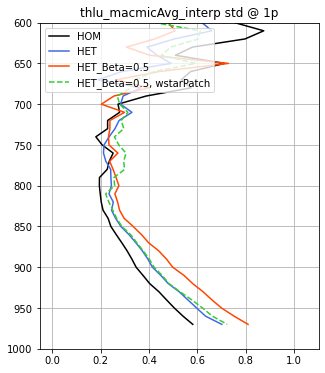

In [52]:
# var_h2 = 'edmf_upthl_interp'
var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'qtu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
# var_h2 = 'upa_macmicAvg_interp'

hrSel = 13

var_addTerm = scamDS_h2_addTerm_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')
var_before  = scamDS_h2_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')

## Plot standard devition of plumes as Nathan's done
stdVar_addTerm = var_addTerm.std(axis=1)
stdVar_before  = var_before.std(axis=1)

fig,axs = plt.subplots(1,1,figsize=(5,6))

axs.plot(stdVar_before.isel(case=0).values, stdVar_before.levInterp.values, color='k', label='HOM')
axs.plot(stdVar_before.isel(case=1).values, stdVar_before.levInterp.values, color='royalblue', label='HET')
# axs.plot(stdVar_addTerm.isel(case=0).values, stdVar_addTerm.levInterp.values,'--', color='grey',label='HOM_Beta=0.5')
axs.plot(stdVar_addTerm.isel(case=1).values, stdVar_addTerm.levInterp.values, color='orangered',label='HET_Beta=0.5')
axs.legend(loc='upper left')

axs.invert_yaxis()

axs.set_ylim([1000,600])
# axs.set_xlim(0.2,2.75)

axs.grid()

axs.set_title(var_h2+' std @ 1p')


Text(0.5, 1.0, 'up_macmicAvg_interp mean @ 1p')

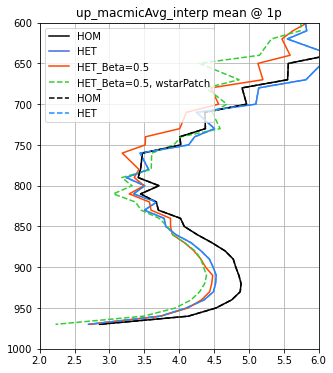

In [76]:
# var_h2 = 'edmf_upthl_interp'
# var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'qtu_macmicAvg_interp'
var_h2 = 'up_macmicAvg_interp'
# var_h2 = 'upa_macmicAvg_interp'

hrSel = 13

var_addTerm = scamDS_h2_addTerm_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')
var_before  = scamDS_h2_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')

## Plot standard devition of plumes as Nathan's done
# meanVar_HOM = scamDS_h2_thisDay[var_h2].isel(case=0).resample(time='1H').mean().weighted(HOMwgts).mean(dim='nens').groupby('time.hour').mean(dim='time')
# meanVar_HOM = meanVar_HOM.isel(hour=hrSel)

# meanVar_HET = scamDS_h2_thisDay[var_h2].isel(case=1).resample(time='1H').mean().weighted(HOMwgts).mean(dim='nens').groupby('time.hour').mean(dim='time')
# meanVar_HET = meanVar_HET.isel(hour=hrSel)
meanVar_addTerm = var_addTerm.mean(axis=1)
meanVar_before  = var_before.mean(axis=1)

fig,axs = plt.subplots(1,1,figsize=(5,6))

axs.plot(meanVar_before.isel(case=0).values, meanVar_before.levInterp.values, color='k', label='HOM')
axs.plot(meanVar_before.isel(case=1).values, meanVar_before.levInterp.values, color='royalblue', label='HET')
# axs.plot(meanVar_addTerm.isel(case=0).values, meanVar_addTerm.levInterp.values,'--', color='grey',label='HOM_Beta=0.5')
axs.plot(meanVar_addTerm.isel(case=1).values, meanVar_addTerm.levInterp.values, color='orangered',label='HET_Beta=0.5')

# axs.plot(meanVar_before.isel(case=0).values, meanVar_before.levInterp.values, '--', color='k', label='HOM')
# axs.plot(meanVar_before.isel(case=1).values, meanVar_before.levInterp.values, '--', color='dodgerblue', label='HET')

axs.legend()

axs.invert_yaxis()

axs.set_ylim([1000,600])
axs.set_xlim([2.0,6])
# axs.set_xlim([308, 314])
# axs.set_xlim([0.008,0.016])
# axs.set_xlim([0.0015,0.0028])

axs.grid()

axs.set_title(var_h2+' mean @ 1p')


Text(0.5, 1.0, 'total_thlp2 @ 1p')

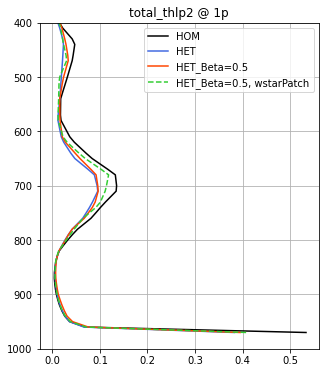

In [78]:
# var_h2 = 'edmf_S_ATHLTHL_interp'
# var_h2 = 'edmf_S_AQTQT_interp'
# var_h2 = 'edmf_S_AWW_interp'

var_h2 = 'total_thlp2'
# var_h2 = 'total_rtp2'
# var_h2 = 'total_wp2'

hrSel = 13

var_addTerm = scamDS_h2_addTerm_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')
var_before  = scamDS_h2_thisDay[var_h2].isel(time=np.where(scamDS_h2_addTerm_thisDay['time.hour'].values==hrSel)[0]).mean(dim='time')

## Plot MF variable (not plume specific)
fig,axs = plt.subplots(1,1,figsize=(5,6))

axs.plot(var_before.isel(case=0).values, var_before.levInterp.values, color='k', label='HOM')
axs.plot(var_before.isel(case=1).values, var_before.levInterp.values, color='royalblue', label='HET')
# axs.plot(var_addTerm.isel(case=0).values, var_addTerm.levInterp.values,'--', color='grey',label='HOM_Beta=0.5')
axs.plot(var_addTerm.isel(case=1).values, var_addTerm.levInterp.values, color='orangered',label='HET_Beta=0.5')
axs.legend()

axs.invert_yaxis()

axs.set_ylim([1000,400])
# axs.set_ylim([1000,800])

axs.grid()

axs.set_title(var_h2+' @ 1p')
